# Implémentez un modèle de scoring
## Partie 1 : Preprocessing et analyse

Pour ce projet, je suis data scientist pour une entreprise qui propose des crédits. L'entreprise souhaite développer un modèle de scoring de la probabilité de défaut du client et l'associer à un tableau de bord interactif afin que les responsables de la relation client puissent expliquer avec la plus grande transparence les décisions d'octroi ou non d'un crédit.

Dans ce notebook, j'effectue le prétraitement des données et une exploration de celles-ci.

### Librairie 

In [2]:
# General
# File system management
import os
import glob

# Visualisation
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno

import math
import scipy
import scipy.stats as stats
from scipy.stats import variation

import collections
from collections import Counter

from termcolor import colored

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline

### Paramètres

In [3]:
# Format & option
sns.set(rc={"figure.figsize": (16, 9)})
pd.options.display.max_columns = 150

# Style use
sns.set_style("darkgrid")
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

### 1 - Import des données 

In [4]:
#Liste des fichiers.
chemin = "./data/"
print(os.listdir(chemin))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


Il y a un total de 9 fichiers : 1 fichier principal pour l'entraînement (avec la cible) 1 fichier principal pour le test (sans la cible), 1 fichier de description, et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

**application_{train|test}.csv**
les principales données de formation et de test contenant des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de demande d'entraînement sont accompagnées de la caractéristique TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.

**bureau.csv**
données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits précédents.

**bureau_balance.csv**
données mensuelles concernant les crédits précédents dans le bureau. Chaque ligne correspond à un mois de crédit antérieur, et un crédit antérieur unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.

**POS_CASH_balance.csv**
données mensuelles sur les prêts au point de vente ou au comptant que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.

**credit_card_balance.csv**
données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.

**previous_application.csv**
demandes précédentes de prêts au Home Credit des clients qui ont des prêts dans les données de demande. Chaque prêt actuel dans les données de la demande peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.

**installments_payments.csv**
historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

**HomeCredit_columns_description.csv**
Ce fichier contient les descriptions des colonnes des différents fichiers de données.

##### Relations existantes entre les différents fichiers

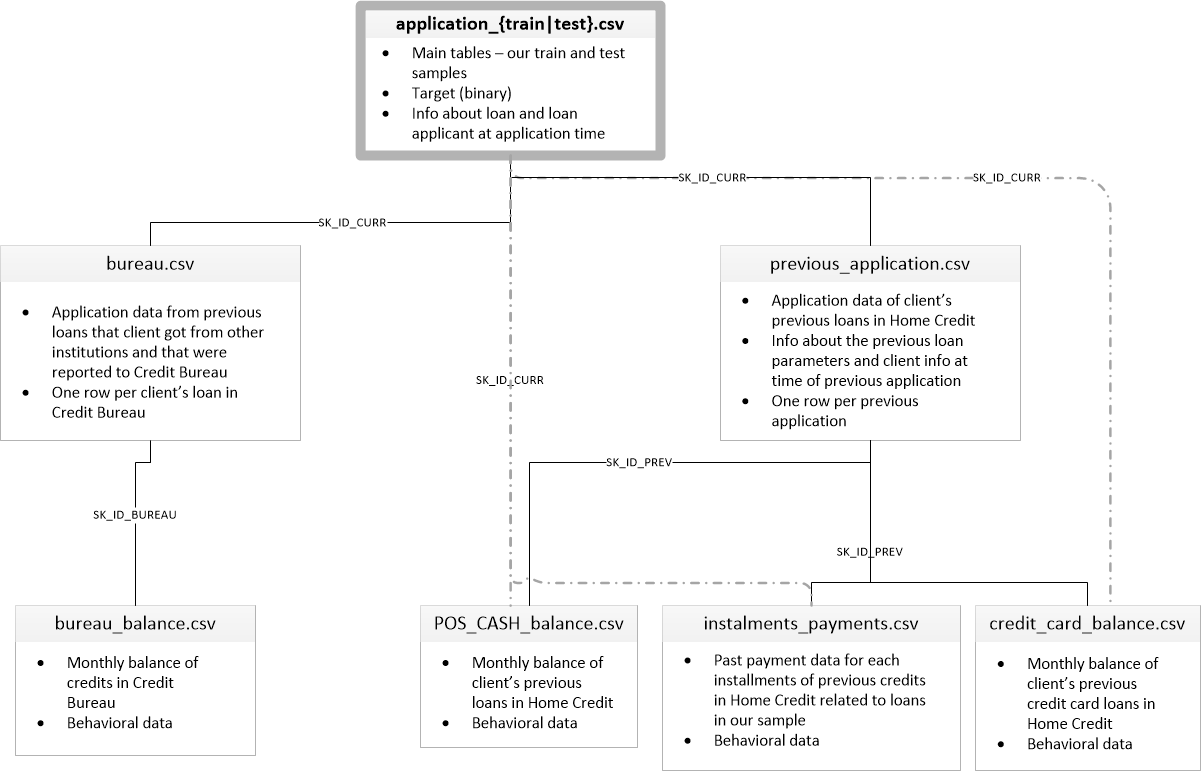

#### 1.2 Train & Test

In [5]:
# Définition du répertoire par défaut où se trouvent les fichiers de données
default_dir = "./data/"

# Lecture des fichiers de données d'entraînement et de test à l'aide du répertoire spécifié
app_train = pd.read_csv(os.path.join(default_dir, "application_train.csv"))
app_test = pd.read_csv(os.path.join(default_dir, "application_test.csv"))

# Affichage de la forme (nombre de lignes et de colonnes) des données d'entraînement et de test
print(f"Forme des données d'entraînement : {app_train.shape}")
print(f"Forme des données de test : {app_test.shape}")

# Affichage des premières lignes des données d'entraînement
app_train.head()

Forme des données d'entraînement : (307511, 122)
Forme des données de test : (48744, 121)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

Le CSV train contient la cible (target), contrairement au CSV test.

#### 1.3 lecture des autres fichiers CSV

In [6]:
# fonction pour spécifier manuellement le type de la variable 
def get_balance_data():
    # Définition des types de données pour chaque fichier CSV
    pos_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "MONTHS_BALANCE": np.int64, "SK_DPD": np.int64, 
        "SK_DPD_DEF": np.int64, "CNT_INSTALMENT": np.float64, "CNT_INSTALMENT_FUTURE": np.float64,
    }

    install_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "NUM_INSTALMENT_NUMBER": np.int64, "NUM_INSTALMENT_VERSION": np.float64,
        "DAYS_INSTALMENT": np.float64, "DAYS_ENTRY_PAYMENT": np.float64, "AMT_INSTALMENT": np.float64, "AMT_PAYMENT": np.float64
    }

    card_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "MONTHS_BALANCE": np.int64, "AMT_CREDIT_LIMIT_ACTUAL": np.int64,
        "CNT_DRAWINGS_CURRENT": np.int64, "SK_DPD": np.int64, "SK_DPD_DEF": np.int64, "AMT_BALANCE": np.float64,
        "AMT_DRAWINGS_ATM_CURRENT": np.float64, "AMT_DRAWINGS_CURRENT": np.float64, "AMT_DRAWINGS_OTHER_CURRENT": np.float64,
        "AMT_DRAWINGS_POS_CURRENT": np.float64, "AMT_INST_MIN_REGULARITY": np.float64, "AMT_PAYMENT_CURRENT": np.float64,
        "AMT_PAYMENT_TOTAL_CURRENT": np.float64, "AMT_RECEIVABLE_PRINCIPAL": np.float64, "AMT_RECIVABLE": np.float64,
        "AMT_TOTAL_RECEIVABLE": np.float64, "CNT_DRAWINGS_ATM_CURRENT": np.float64, "CNT_DRAWINGS_OTHER_CURRENT": np.float64,
        "CNT_DRAWINGS_POS_CURRENT": np.float64,  "CNT_INSTALMENT_MATURE_CUM": np.float64
    }

    bureau_dtype = {
        "SK_ID_BUREAU": np.uint64, "SK_ID_CURR": np.uint64, "DAYS_CREDIT": np.int64, "CREDIT_DAY_OVERDUE": np.int64,
        "DAYS_CREDIT_ENDDATE": np.float64, "DAYS_ENDDATE_FACT": np.float64, "AMT_CREDIT_MAX_OVERDUE": np.float64,
        "CNT_CREDIT_PROLONG": np.int64, "AMT_CREDIT_SUM": np.float64, "AMT_CREDIT_SUM_DEBT": np.float64,
        "AMT_CREDIT_SUM_LIMIT": np.float64, "AMT_CREDIT_SUM_OVERDUE": np.float64, "DAYS_CREDIT_UPDATE": np.int64,
        "AMT_ANNUITY": np.float64
    }

    previous_application_dtype = {
        "SK_ID_PREV": np.uint64, "SK_ID_CURR": np.uint64, "AMT_ANNUITY": np.float64, "AMT_APPLICATION": np.float64,
        "AMT_CREDIT": np.float64, "AMT_DOWN_PAYMENT": np.float64, "AMT_GOODS_PRICE": np.float64, "HOUR_APPR_PROCESS_START": np.float64,
        "NFLAG_LAST_APPL_IN_DAY": np.float64, "RATE_DOWN_PAYMENT": np.float64, "RATE_INTEREST_PRIMARY": np.float64,
        "RATE_INTEREST_PRIVILEGED": np.float64, "DAYS_DECISION": np.int64, "SELLERPLACE_AREA": np.int64,
        "CNT_PAYMENT": np.float64, "DAYS_FIRST_DRAWING": np.float64, "DAYS_FIRST_DUE": np.float64, "DAYS_LAST_DUE_1ST_VERSION": np.float64,
        "DAYS_LAST_DUE": np.float64, "DAYS_TERMINATION": np.float64, "NFLAG_INSURED_ON_APPROVAL": np.float64
    }
    
    bureau_balance_dtype = {
        "SK_ID_BUREAU": np.uint64, "MONTHS_BALANCE": np.int64
    }

    # Lecture des fichiers CSV avec les types de données spécifiés
    POS_CASH_balance = pd.read_csv(os.path.join(default_dir, "POS_CASH_balance.csv"), dtype=pos_dtype)

    installments_payments = pd.read_csv(os.path.join(default_dir, "installments_payments.csv"), dtype=install_dtype)

    credit_card_balance = pd.read_csv(os.path.join(default_dir, "credit_card_balance.csv"), dtype=card_dtype)

    bureau = pd.read_csv(os.path.join(default_dir, "bureau.csv"), dtype=bureau_dtype)

    previous_application = pd.read_csv(os.path.join(default_dir, "previous_application.csv"), dtype=previous_application_dtype)
    
    bureau_balance = pd.read_csv(os.path.join(default_dir, "bureau_balance.csv"), dtype=bureau_balance_dtype)
    
    # Retourne les données lues à partir des fichiers CSV
    return POS_CASH_balance, installments_payments, credit_card_balance, bureau, previous_application, bureau_balance


In [7]:
# appliquer la fonction 
POS_CASH_balance, installments_payments, credit_card_balance, bureau, previous_application, bureau_balance = get_balance_data()

In [8]:
# Lecture du fichier sample_submission.csv qui contient les échantillons de soumission
sample_submission = pd.read_csv(os.path.join(default_dir, "sample_submission.csv"))

# Définition de la largeur maximale de la colonne à 400 caractères
pd.set_option("max_colwidth", 400)

# Lecture du fichier HomeCredit_columns_description.csv qui contient les descriptions des colonnes
# Utilisation de l'encodage 'mac_roman' pour assurer une lecture correcte des caractères
HomeCredit_columns_description = pd.read_csv(os.path.join(default_dir, "HomeCredit_columns_description.csv"), encoding='mac_roman')
HomeCredit_columns_description

Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                                                                                                                                                                     Description  \
0                                                                                                                                                                       ID of loan in our sample   
1    Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
2                                                                                                                                                    Identification if loan is cash or revolving   
3                                                                                                                                                                           Gender of the client   
4                                                                                                                                                                  Flag if the client owns a car   
..                                                                                                                                                                                           ...   
214                                                                                                                                                      On which installment we observe payment   
215                                                                               When the installment of previous credit was supposed to be paid (relative to application date of current loan)   
216                                                                                    When was the installments of previous credit paid actually (relative to application date of current loan)   
217                                                                                                            What was the prescribed installment amount of previous credit on this installment   
218                                                                                                                         What the client actually paid on previous credit on this installment   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [9]:
# Fonction qui retourne des information sur le dataset 
def data_describe(folder):
    '''Vérifiez le nombre de lignes, de colonnes, de valeurs manquantes et de doublons.
        Compter le type de colonnes.
        Indicateur de mémoire'''

    # Création d'un dictionnaire pour stocker les informations des fichiers
    data_dict = {}

    # Parcours des fichiers dans le dossier spécifié
    for file in folder:
        # Lecture du fichier avec l'encodage 'mac_roman'
        data = pd.read_csv(file, encoding='mac_roman')

        # Calcul des différentes métriques pour le fichier
        data_dict[file] = [data.shape[0],  # Nombre de lignes
                           data.shape[1],  # Nombre de colonnes
                           round(data.isna().sum().sum() / data.size * 100, 2),  # Pourcentage de valeurs manquantes
                           round(data.duplicated().sum().sum() / data.size * 100, 2),  # Pourcentage de valeurs dupliquées
                           data.select_dtypes(include=['object']).shape[1],  # Nombre de colonnes de type object
                           data.select_dtypes(include=['float']).shape[1],  # Nombre de colonnes de type float
                           data.select_dtypes(include=['int']).shape[1],  # Nombre de colonnes de type int
                           data.select_dtypes(include=['bool']).shape[1],  # Nombre de colonnes de type bool
                           round(data.memory_usage().sum() / 1024 ** 2, 3)]  # Utilisation mémoire en MB

    # Création d'un DataFrame à partir du dictionnaire de données
    comparative_table = pd.DataFrame.from_dict(data=data_dict,
                                               columns=['Rows', 'Columns', '%NaN', '%Duplicate',
                                                        'object_dtype', 'float_dtype', 'int_dtype',
                                                        'bool_dtype', 'MB_Memory'],
                                               orient='index')

    # Affichage d'un message résumant les fichiers analysés
    print("SUMMARY FILES…")
    return comparative_table


In [10]:
# data description de tout les fichier CSV
data_describe(glob.glob("./data/*.csv"))

SUMMARY FILES…


Rows  Columns   %NaN  \
./data\application_test.csv                   48744      121  23.81   
./data\application_train.csv                 307511      122  24.40   
./data\bureau.csv                           1716428       17  13.50   
./data\bureau_balance.csv                  27299925        3   0.00   
./data\credit_card_balance.csv              3840312       23   6.65   
./data\HomeCredit_columns_description.csv       219        5  12.15   
./data\installments_payments.csv           13605401        8   0.01   
./data\POS_CASH_balance.csv                10001358        8   0.07   
./data\previous_application.csv             1670214       37  17.98   
./data\sample_submission.csv                  48744        2   0.00   

                                           %Duplicate  object_dtype  \
./data\application_test.csv                       0.0            16   
./data\application_train.csv                      0.0            16   
./data\bureau.csv                                 0.0             3   
./data\bureau_balance.csv                         0.0             1   
./data\credit_card_balance.csv                    0.0             1   
./data\HomeCredit_columns_description.csv         0.0             4   
./data\installments_payments.csv                  0.0             0   
./data\POS_CASH_balance.csv                       0.0             1   
./data\previous_application.csv                   0.0            16   
./data\sample_submission.csv                      0.0             0   

                                           float_dtype  int_dtype  bool_dtype  \
./data\application_test.csv                         65         40           0   
./data\application_train.csv                        65         41           0   
./data\bureau.csv                                    8          6           0   
./data\bureau_balance.csv                            0          2           0   
./data\credit_card_balance.csv                      15          7           0   
./data\HomeCredit_columns_description.csv            0          1           0   
./data\installments_payments.csv                     5          3           0   
./data\POS_CASH_balance.csv                          2          5           0   
./data\previous_application.csv                     15          6           0   
./data\sample_submission.csv                         1          1           0   

                                           MB_Memory  
./data\application_test.csv                   44.998  
./data\application_train.csv                 286.227  
./data\bureau.csv                            222.620  
./data\bureau_balance.csv                    624.846  
./data\credit_card_balance.csv               673.883  
./data\HomeCredit_columns_description.csv      0.008  
./data\installments_payments.csv             830.408  
./data\POS_CASH_balance.csv                  610.435  
./data\previous_application.csv              471.481  
./data\sample_submission.csv                   0.744

In [11]:
# fonnction qui sépare les données numériques et objects
def features(folder):
    '''Données comparatives avec valeurs manquantes,
       et de nombreuses statistiques descriptives.'''
    
    # Dictionnaire pour stocker les caractéristiques de type 'object' des fichiers
    data_object = {}
    # Dictionnaire pour stocker les caractéristiques numériques des fichiers
    data_numeric = {}
    
    # Parcours des fichiers dans le dossier spécifié
    for file in folder:
        # Lecture du fichier avec l'encodage 'mac_roman'
        data = pd.read_csv(file, encoding='mac_roman')
        
        # Analyse des caractéristiques de type 'object'
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        # Analyse des caractéristiques numériques
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    # Création d'un DataFrame à partir du dictionnaire de caractéristiques 'object'
    comparative_object = pd.DataFrame.from_dict(data=data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    # Création d'un DataFrame à partir du dictionnaire de caractéristiques numériques
    comparative_numeric = pd.DataFrame.from_dict(data=data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2


In [12]:
# data description description de tout les fichier CSV ([0] : accéder au premier DataFrame)
features(glob.glob("./data/*.csv"))[0]

features  \
./data\application_test.csv               0            NAME_CONTRACT_TYPE   
                                          1                   CODE_GENDER   
                                          2                  FLAG_OWN_CAR   
                                          3               FLAG_OWN_REALTY   
                                          4               NAME_TYPE_SUITE   
                                          5              NAME_INCOME_TYPE   
                                          6           NAME_EDUCATION_TYPE   
                                          7            NAME_FAMILY_STATUS   
                                          8             NAME_HOUSING_TYPE   
                                          9               OCCUPATION_TYPE   
                                          10   WEEKDAY_APPR_PROCESS_START   
                                          11            ORGANIZATION_TYPE   
                                          12           FONDKAPREMONT_MODE   
                                          13               HOUSETYPE_MODE   
                                          14           WALLSMATERIAL_MODE   
                                          15          EMERGENCYSTATE_MODE   
./data\application_train.csv              0            NAME_CONTRACT_TYPE   
                                          1                   CODE_GENDER   
                                          2                  FLAG_OWN_CAR   
                                          3               FLAG_OWN_REALTY   
                                          4               NAME_TYPE_SUITE   
                                          5              NAME_INCOME_TYPE   
                                          6           NAME_EDUCATION_TYPE   
                                          7            NAME_FAMILY_STATUS   
                                          8             NAME_HOUSING_TYPE   
                                          9               OCCUPATION_TYPE   
                                          10   WEEKDAY_APPR_PROCESS_START   
                                          11            ORGANIZATION_TYPE   
                                          12           FONDKAPREMONT_MODE   
                                          13               HOUSETYPE_MODE   
                                          14           WALLSMATERIAL_MODE   
                                          15          EMERGENCYSTATE_MODE   
./data\bureau.csv                         0                 CREDIT_ACTIVE   
                                          1               CREDIT_CURRENCY   
                                          2                   CREDIT_TYPE   
./data\bureau_balance.csv                 0                        STATUS   
./data\credit_card_balance.csv            0          NAME_CONTRACT_STATUS   
./data\HomeCredit_columns_description.csv 0                         Table   
                                          1                           Row   
                                          2                   Description   
                                          3                       Special   
./data\POS_CASH_balance.csv               0          NAME_CONTRACT_STATUS   
./data\previous_application.csv           0            NAME_CONTRACT_TYPE   
                                          1    WEEKDAY_APPR_PROCESS_START   
                                          2   FLAG_LAST_APPL_PER_CONTRACT   
                                          3        NAME_CASH_LOAN_PURPOSE   
                                          4          NAME_CONTRACT_STATUS   
                                          5             NAME_PAYMENT_TYPE   
                                          6            CODE_REJECT_REASON   
                                          7               NAME_TYPE_SUITE   
                                          8              NAME_CLIENT_TYPE   
                                          9           NAME_GO

In [13]:
# data description description de tout les fichier CSV ([1] : accéder au deuxième DataFrame)
features(glob.glob("./data/*.csv"))[1]

features    dtype  \
./data\application_test.csv     0                  SK_ID_CURR    int64   
                                1                CNT_CHILDREN    int64   
                                2            AMT_INCOME_TOTAL  float64   
                                3                  AMT_CREDIT  float64   
                                4                 AMT_ANNUITY  float64   
...                                                       ...      ...   
./data\previous_application.csv 18              DAYS_LAST_DUE  float64   
                                19           DAYS_TERMINATION  float64   
                                20  NFLAG_INSURED_ON_APPROVAL  float64   
./data\sample_submission.csv    0                  SK_ID_CURR    int64   
                                1                      TARGET  float64   

                                       nan   count    mean       std  \
./data\application_test.csv     0        0   48744  277796  103169.5   
                                1        0   48744       0       0.7   
                                2        0   48744  178431  101522.6   
                                3        0   48744  516740  365397.0   
                                4       24   48720   29426   16016.4   
...                                    ...     ...     ...       ...   
./data\previous_application.csv 18  673065  997149   76582  149647.4   
                                19  673065  997149   81992  153303.5   
                                20  673065  997149       0       0.5   
./data\sample_submission.csv    0        0   48744  277796  103169.5   
                                1        0   48744       0       0.0   

                                         min        max  
./data\application_test.csv     0   100001.0   456250.0  
                                1        0.0       20.0  
                                2    26941.5  4410000.0  
                                3    45000.0  2245500.0  
                                4     2295.0   180576.0  
...                                      ...        ...  
./data\previous_application.csv 18   -2889.0   365243.0  
                                19   -2874.0   365243.0  
                                20       0.0        1.0  
./data\sample_submission.csv    0   100001.0   456250.0  
                                1        0.5        0.5  

[288 rows x 8 columns]

### 2 - Analyse exploratoire des données (EDA)

Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET). Données statistiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

#### 2.1 Premières observations

In [14]:
def informations(dataframe):
    """Cette fonction donne les informations générales d'un dataset.
     Il renvoie le nombre de lignes et de colonnes du dataset.
     dataframe: dataset"""

    # Affichage de l'en-tête en rouge pour indiquer un aperçu du jeu de données
    print(colored("\n Aperçu de l'ensemble de données : \n", 'red'))
    
    # Calcul du nombre de lignes et de colonnes du DataFrame
    lines = dataframe.shape[0]
    columns = dataframe.shape[1]
    
    # Affichage du nombre de lignes et de colonnes en bleu
    print(colored(f"L'ensemble de données à {lines} ligens et {columns} "
                  "colonnes. \n \n", 'blue'))
    
    # Affichage des noms des colonnes en vert
    print(colored("Nom de la colonne : \n", 'green'))
    print(list(dataframe.columns))
    print("\n")
    
    # Affichage des types de données des colonnes en vert
    print(colored("Type de colonne: \n", 'green'))
    print(list(dataframe.dtypes))
    print("\n")


In [15]:
# Appliquer la fonction
informations(app_train)


 Aperçu de l'ensemble de données : 

L'ensemble de données à 307511 ligens et 122 colonnes. 
 

Nom de la colonne : 

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SO

L'ensemble d'apprentissage comporte 307 511 observations (prêts) et 122 colonnes. 

In [16]:
# Affiche les colonnes qui sont différentes dans les deux DataFrames
# Vérifiez si 'TARGET' est la seule différence
print("Vérifiez quelles colonnes sont différentes dans les deux fichiers.")
display(app_train.columns.difference(app_test.columns))

Vérifiez quelles colonnes sont différentes dans les deux fichiers.


Index(['TARGET'], dtype='object')

La TARGET est ce que l'on nous demande de prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie.

In [17]:
# afficher le de prêt accordé ou non (0:accordé) (1:non accordé)
app_train.groupby(['TARGET'])['SK_ID_CURR'].count()

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

In [18]:
def graphe_col_category(dataframe, col, size, name):
    """
    Affiche un graphique à barres et un diagramme circulaire pour une colonne catégorielle.

    Arguments :
    - dataframe : le jeu de données
    - col : le nom de la colonne catégorielle à représenter
    - size : la taille de la figure (X, X)
    - name : les noms des catégories

    """
    # Compter les occurrences de chaque valeur dans la colonne
    values = dataframe[col].value_counts()
    labels = dataframe[col].value_counts().index
    
    # Créer une figure avec la taille spécifiée
    plt.figure(figsize=size)
    
    # Afficher un graphique à barres
    plt.subplot(2, 2, 1)
    sns.barplot(x=labels, y=values, palette='pink')
    
    # Afficher un diagramme circulaire
    plt.subplot(2, 2, 2)
    plt.title(f"Représentation de la variable {col}", fontsize=20)
    plt.pie(values, labels=name, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    plt.axis('equal')
    plt.tight_layout()
    plt.legend


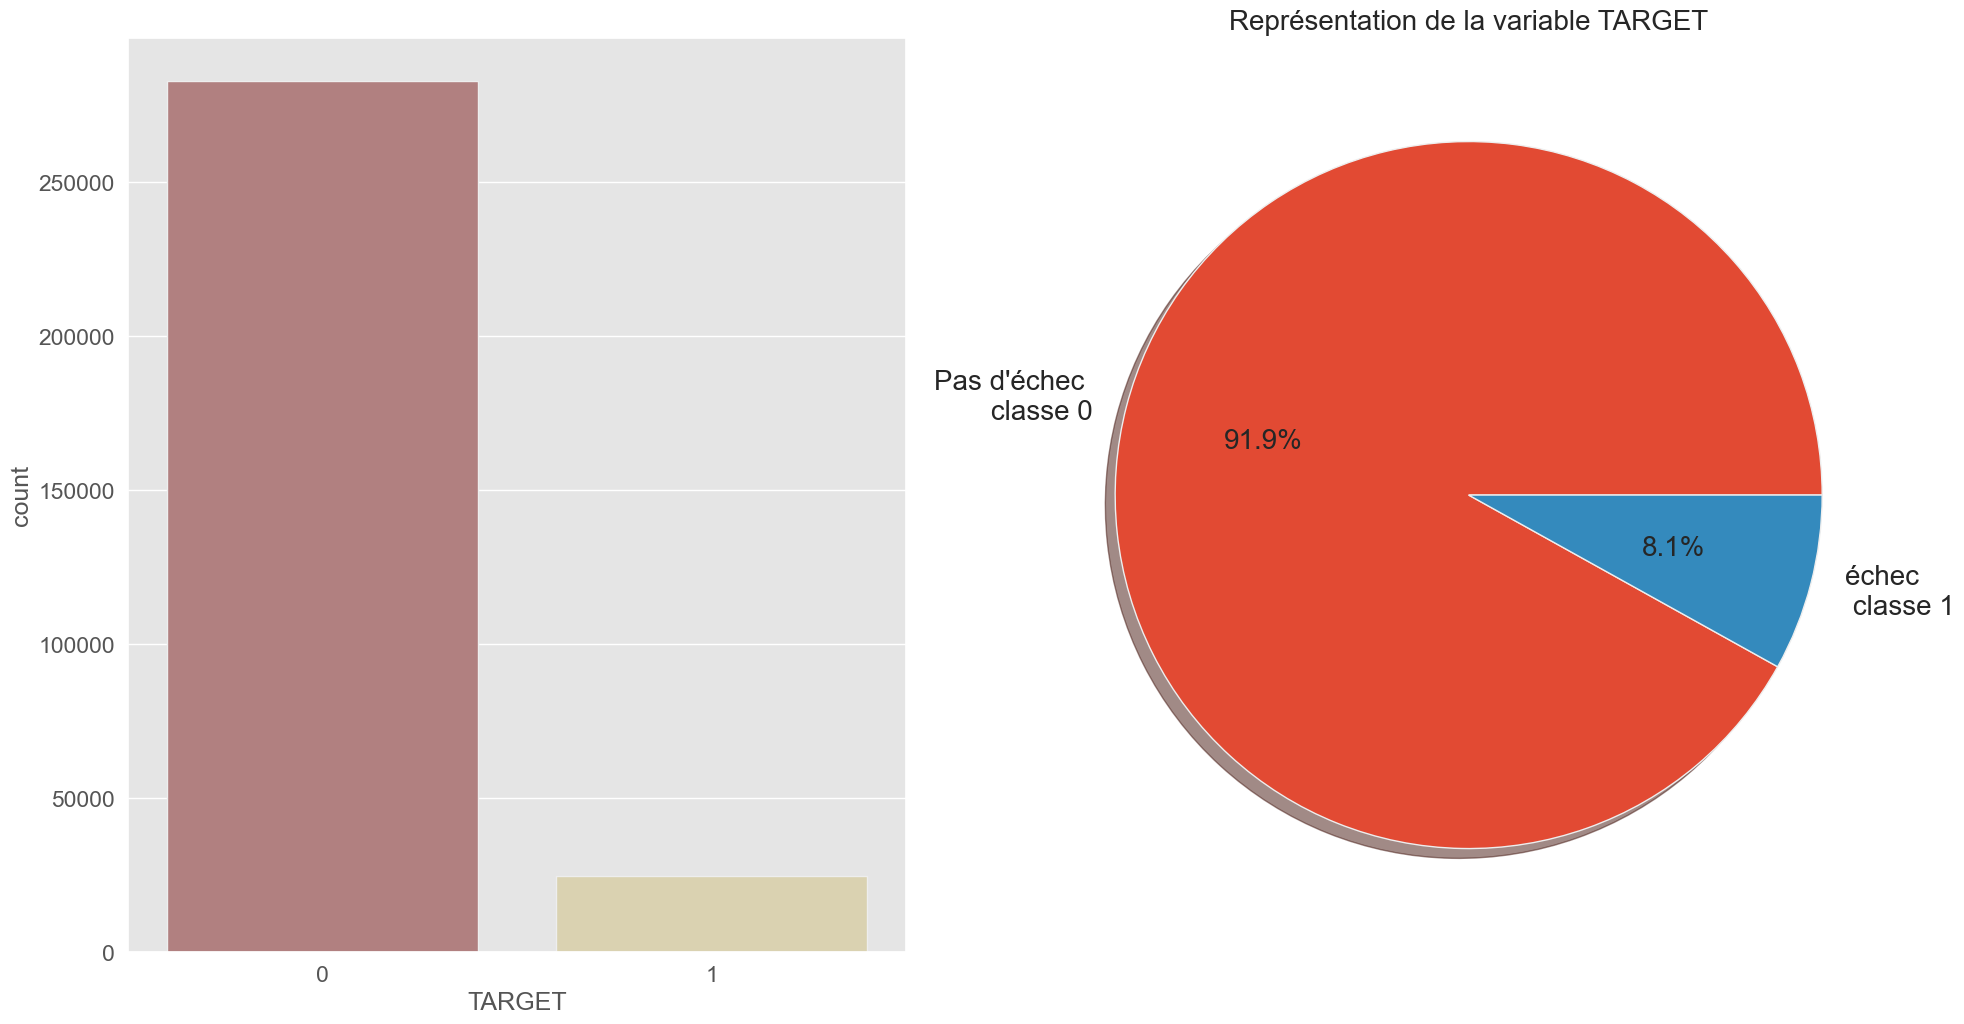

In [19]:
# Appliquer la fonction 
graphe_col_category(app_train, 'TARGET', (20,20), ["Pas d'échec \n classe 0", "échec \n classe 1"])

On remarque que les classes sont déséquilibrées, il y a beaucoup plus d'individus dans la classe 0 que de dans la classe 1. 
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [22]:
import imblearn 

In [24]:
print(imblearn.__version__)

0.10.1


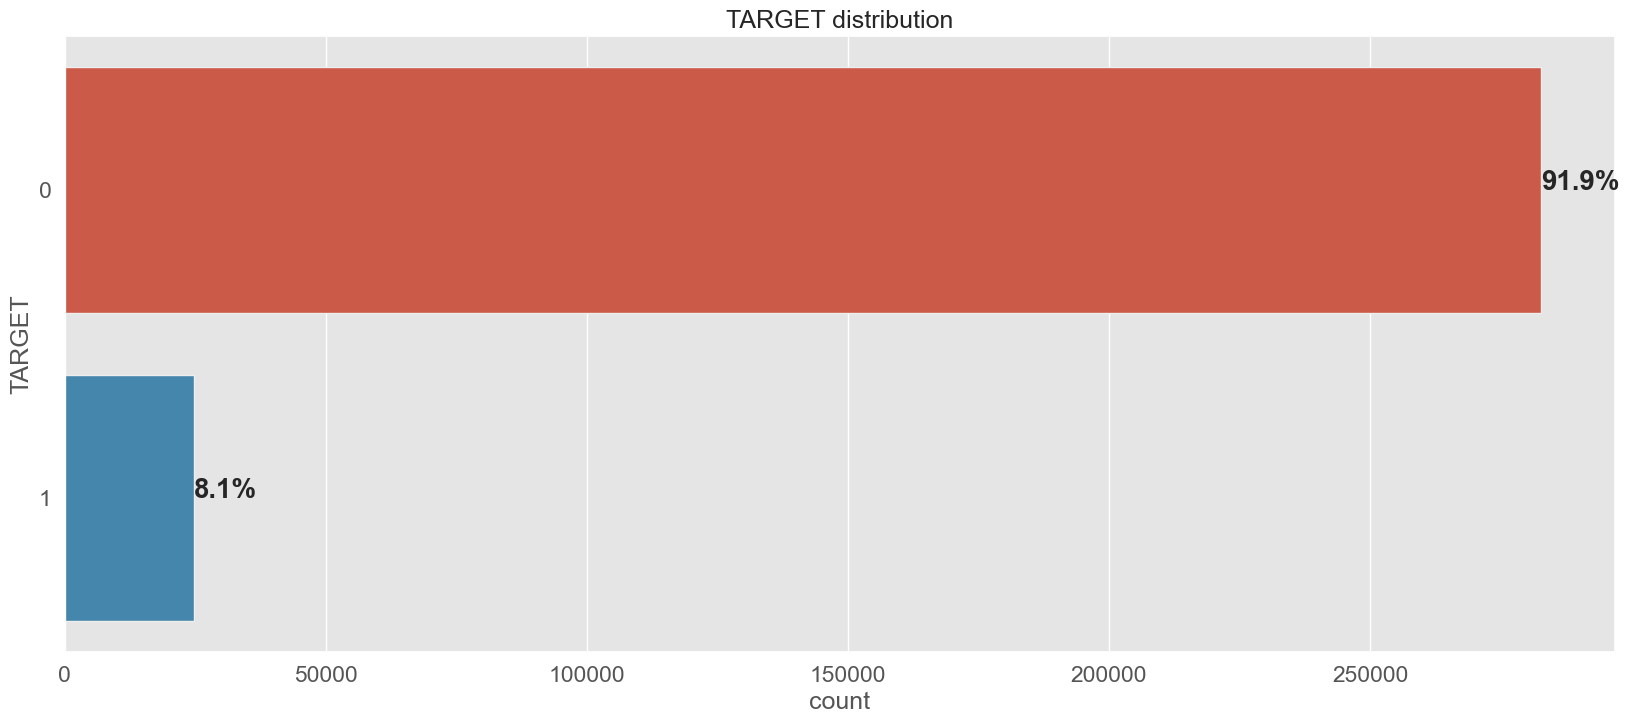

In [25]:
# Créer une figure et des axes
ax, fig = plt.subplots(figsize=(20,8))

# Tracer le countplot en utilisant la colonne 'TARGET' du DataFrame 'app_train'
ax = sns.countplot(y='TARGET', data=app_train)

# Définir le titre du graphique
ax.set_title("TARGET distribution")

# Ajouter des annotations pour afficher les pourcentages
for p in ax.patches:
    # Calculer le pourcentage
    percentage = '{:.1f}%'.format(100 * p.get_width()/len(app_train.TARGET))
    # Déterminer les coordonnées de l'annotation
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    # Ajouter l'annotation au graphique
    ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

# Afficher le graphique
plt.show()


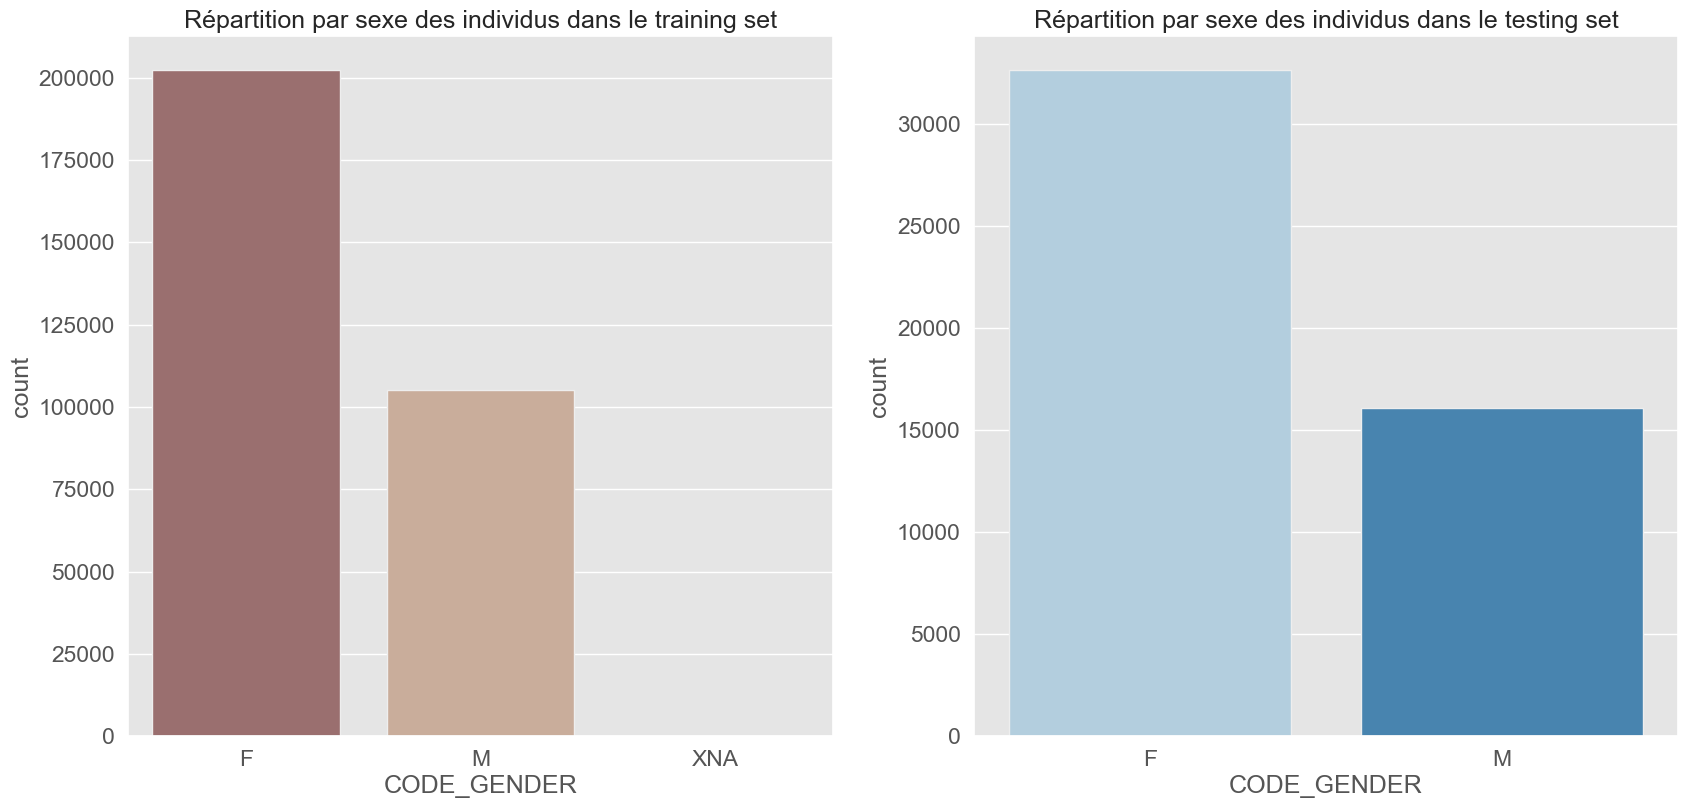

In [26]:
# Créer une figure de taille 20x20 pouces
plt.figure(figsize=(20, 20))

# Tracer le premier subplot (subplot 2x2, position 1)
plt.subplot(2, 2, 1)
# Tracer un graphique à barres pour la distribution des genres dans le jeu de données d'entraînement
sns.barplot(x=app_train['CODE_GENDER'].value_counts().index, 
            y=app_train['CODE_GENDER'].value_counts(), palette='pink').set_title("Répartition par sexe des individus dans le training set")

# Tracer le deuxième subplot (subplot 2x2, position 2)
plt.subplot(2, 2, 2)
# Tracer un graphique à barres pour la distribution des genres dans le jeu de données de test
sns.barplot(x=app_test['CODE_GENDER'].value_counts().index, 
            y=app_test['CODE_GENDER'].value_counts(), palette='Blues').set_title("Répartition par sexe des individus dans le testing set")

# Afficher les graphiques
plt.show()


depuis le graphique, on peut voir qu'il y a une troisième modalité pour le sexe (également présente pour d'autres colonnes) qui semble correspondre à des données manquantes (différentes notations entre les personnes).

In [27]:
app_train[app_train["CODE_GENDER"] == "XNA"]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
35657       141289       0    Revolving loans         XNA            Y   
38566       144669       0    Revolving loans         XNA            N   
83382       196708       0    Revolving loans         XNA            N   
189640      319880       0    Revolving loans         XNA            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657                Y             0          207000.0    382500.0   
38566                Y             2          157500.0    270000.0   
83382                Y             1          135000.0    405000.0   
189640               Y             0          247500.0    540000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
35657       19125.0         337500.0   Unaccompanied               Working   
38566       13500.0         225000.0          Family               Working   
83382       20250.0         225000.0   Unaccompanied               Working   
189640      27000.0         900000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
35657   Secondary / secondary special            Married  Municipal apartment   
38566   Secondary / secondary special            Married    House / apartment   
83382                Higher education            Married    House / apartment   
189640              Incomplete higher     Civil marriage    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
35657                     0.020713      -20232         -10044   
38566                     0.026392      -13717          -2797   
83382                     0.035792      -10647          -1228   
189640                    0.035792       -9649          -2293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
35657            -10024.0            -3537         13.0           1   
38566             -2241.0            -4659          NaN           1   
83382              -183.0            -1671          NaN           1   
189640            -4099.0            -2326          8.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
35657                1                1                 1           1   
38566                1                1                 1           1   
83382                1                1                 1           1   
189640               1                1                 1           1   

        FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
35657            0                 NaN              2.0                     3   
38566            0  Low-skill Laborers              4.0                     2   
83382            0          Core staff              3.0                     2   
189640           0                 NaN              2.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
35657                             3                    TUESDAY   
38566                             2                     FRIDAY   
83382                             2                   THURSDAY   
189640                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
35657                        10                           0   
38566                        16                           0   
83382                        15                           0   
189640                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
35657                            0                            0   
38566                            0                            0   
83382                            0                            0   
189640                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CI

In [28]:
# Remplacer la valeur 'XNA' par NaN dans le DataFrame app_train
app_train = app_train.replace('XNA', np.nan)

# Remplacer la valeur 'XNA' par NaN dans le DataFrame app_test
app_test = app_test.replace('XNA', np.nan)


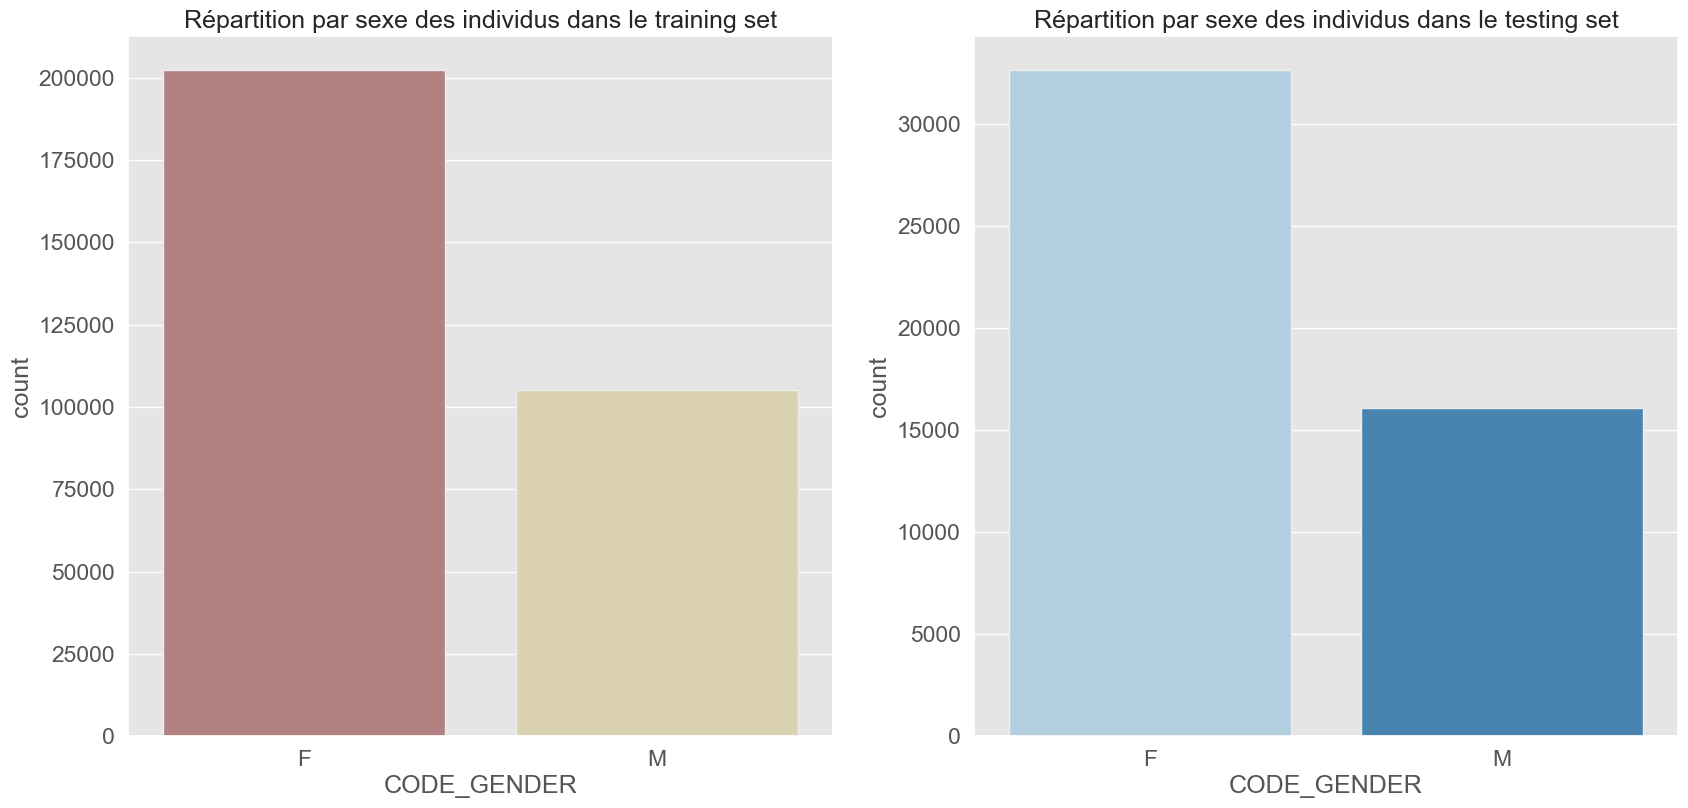

In [29]:
# Créer une figure de taille 20x20 pouces
plt.figure(figsize=(20, 20))

# Tracer le premier subplot (subplot 2x2, position 1)
plt.subplot(2, 2, 1)
# Tracer un graphique à barres pour la distribution des genres dans le jeu de données d'entraînement
sns.barplot(x=app_train['CODE_GENDER'].value_counts().index, 
            y=app_train['CODE_GENDER'].value_counts(), palette='pink').set_title("Répartition par sexe des individus dans le training set")

# Tracer le deuxième subplot (subplot 2x2, position 2)
plt.subplot(2, 2, 2)
# Tracer un graphique à barres pour la distribution des genres dans le jeu de données de test
sns.barplot(x=app_test['CODE_GENDER'].value_counts().index, 
            y=app_test['CODE_GENDER'].value_counts(), palette='Blues').set_title("Répartition par sexe des individus dans le testing set")

# Afficher les graphiques
plt.show()

In [30]:
app_train['CODE_GENDER'].describe()

count     307507
unique         2
top            F
freq      202448
Name: CODE_GENDER, dtype: object

#### 2.2 Types de colonnes

In [31]:
# nombre de colonnes par type.
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

##### 2.2.1 Types de colonnesNombre unique d'entrées pour chaque colonne de chaque type de données

In [32]:
# Sélectionner les colonnes de type 'int64' dans le DataFrame app_train à l'aide de la méthode select_dtypes('object').
# Appliquer la fonction pd.Series.nunique à chaque colonne de ce sous-DataFrame pour compter le nombre de valeurs uniques dans chaque colonne.
app_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.

In [33]:
# Sélectionner les colonnes de type 'int64' dans le DataFrame app_train à l'aide de la méthode select_dtypes('int64').
# Appliquer la fonction pd.Series.nunique à chaque colonne de ce sous-DataFrame pour compter le nombre de valeurs uniques dans chaque colonne.
app_train.select_dtypes('int64').apply(pd.Series.nunique)


SK_ID_CURR                     307511
TARGET                              2
CNT_CHILDREN                       15
DAYS_BIRTH                      17460
DAYS_EMPLOYED                   12574
DAYS_ID_PUBLISH                  6168
FLAG_MOBIL                          2
FLAG_EMP_PHONE                      2
FLAG_WORK_PHONE                     2
FLAG_CONT_MOBILE                    2
FLAG_PHONE                          2
FLAG_EMAIL                          2
REGION_RATING_CLIENT                3
REGION_RATING_CLIENT_W_CITY         3
HOUR_APPR_PROCESS_START            24
REG_REGION_NOT_LIVE_REGION          2
REG_REGION_NOT_WORK_REGION          2
LIVE_REGION_NOT_WORK_REGION         2
REG_CITY_NOT_LIVE_CITY              2
REG_CITY_NOT_WORK_CITY              2
LIVE_CITY_NOT_WORK_CITY             2
FLAG_DOCUMENT_2                     2
FLAG_DOCUMENT_3                     2
FLAG_DOCUMENT_4                     2
FLAG_DOCUMENT_5                     2
FLAG_DOCUMENT_6                     2
FLAG_DOCUMEN

In [34]:
# Sélectionner les colonnes avec le type de données 'int64' dans le jeu de données d'entraînement (app_train)
app_train_int = list(app_train.select_dtypes('int64'))

# Sélectionner les colonnes avec le type de données 'int64' dans le jeu de données de test (app_test)
app_test_int = list(app_test.select_dtypes('int64'))


In [35]:
# Sélectionner les colonnes de type 'float' dans le DataFrame app_train à l'aide de la méthode select_dtypes('float').
# Ensuite, appliquer la fonction pd.Series.nunique à chaque colonne de ce sous-DataFrame pour compter le nombre de valeurs uniques dans chaque colonne.
app_train.select_dtypes('float').apply(pd.Series.nunique)

AMT_INCOME_TOTAL               2548
AMT_CREDIT                     5603
AMT_ANNUITY                   13672
AMT_GOODS_PRICE                1002
REGION_POPULATION_RELATIVE       81
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY         9
AMT_REQ_CREDIT_BUREAU_WEEK        9
AMT_REQ_CREDIT_BUREAU_MON        24
AMT_REQ_CREDIT_BUREAU_QRT        11
AMT_REQ_CREDIT_BUREAU_YEAR       25
Length: 65, dtype: int64

#### 2.3 Données manquantes

In [36]:
def pie_NaN(dataframe, size):
    """Cette fonction permet de faire un camembert montrant le
     proportion de données manquantes sur l'ensemble de données.
     dataframe : dataset
     taille : taille de la figure (X,X)"""

    # Calculer le nombre de lignes et de colonnes dans le DataFrame.
    lines = dataframe.shape[0]
    columns = dataframe.shape[1]
    
    # Calculer le nombre total de données non manquantes dans le DataFrame.
    nb_data = dataframe.count().sum()
    
    # Calculer le nombre total de données attendues dans le DataFrame s'il n'y avait pas de valeurs manquantes.
    nb_totale = (columns * lines)
    
    # Calculer le taux de données non manquantes dans le DataFrame.
    rate_dataOK = (nb_data / nb_totale)
    
    # Afficher le taux de remplissage du jeu de données (taux de données non manquantes) et le taux de données manquantes.
    print(f"Le jeu de données est rempli à {rate_dataOK :.2%}")
    print(f"et il a {1 - rate_dataOK :.2%} de données manquantes")
    print("\n \n ")
    
    # Préparer les données pour le diagramme circulaire.
    rates = [rate_dataOK, 1 - rate_dataOK]
    labels = ["Données", "NAN"]
    explode = (0, 0.1)  # Pour faire ressortir la part des données manquantes.
    colors = ['gold', 'pink']
    
    # Créer le diagramme circulaire en utilisant matplotlib et afficher le pourcentage de chaque part.
    plt.figure(figsize=size)
    plt.pie(rates, explode=explode, labels=labels, colors=colors,
            autopct='%.2f%%', shadow=True, textprops={'fontsize': 26})
    
    # Définir le titre du diagramme circulaire.
    ttl = plt.title("Taux de remplissage du jeu de données", fontsize=32)
    ttl.set_position([0.5, 0.85])
    
    plt.axis('equal')  # Assurer que le diagramme circulaire est bien un cercle.
    plt.tight_layout()  # Ajuster la disposition pour éviter les coupures de texte.
    plt.show()  # Afficher le diagramme circulaire.


Le jeu de données est rempli à 75.46%
et il a 24.54% de données manquantes

 
 


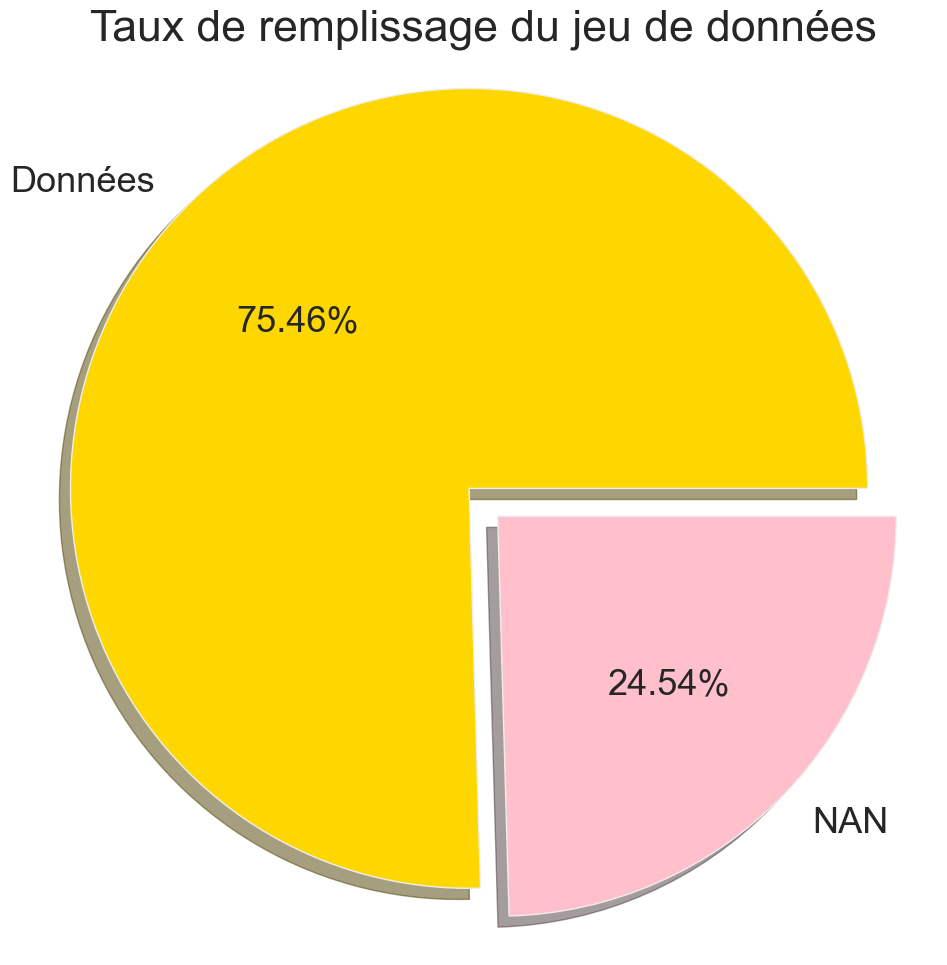

In [37]:
# afficher la proportion de données manquantes pour le dataset app_train
pie_NaN(app_train, (10,10))

Dans le jeu de données de formation, il y a plus de 24% de données manquantes, voyons dans quelles colonnes précisément.

<Axes: >

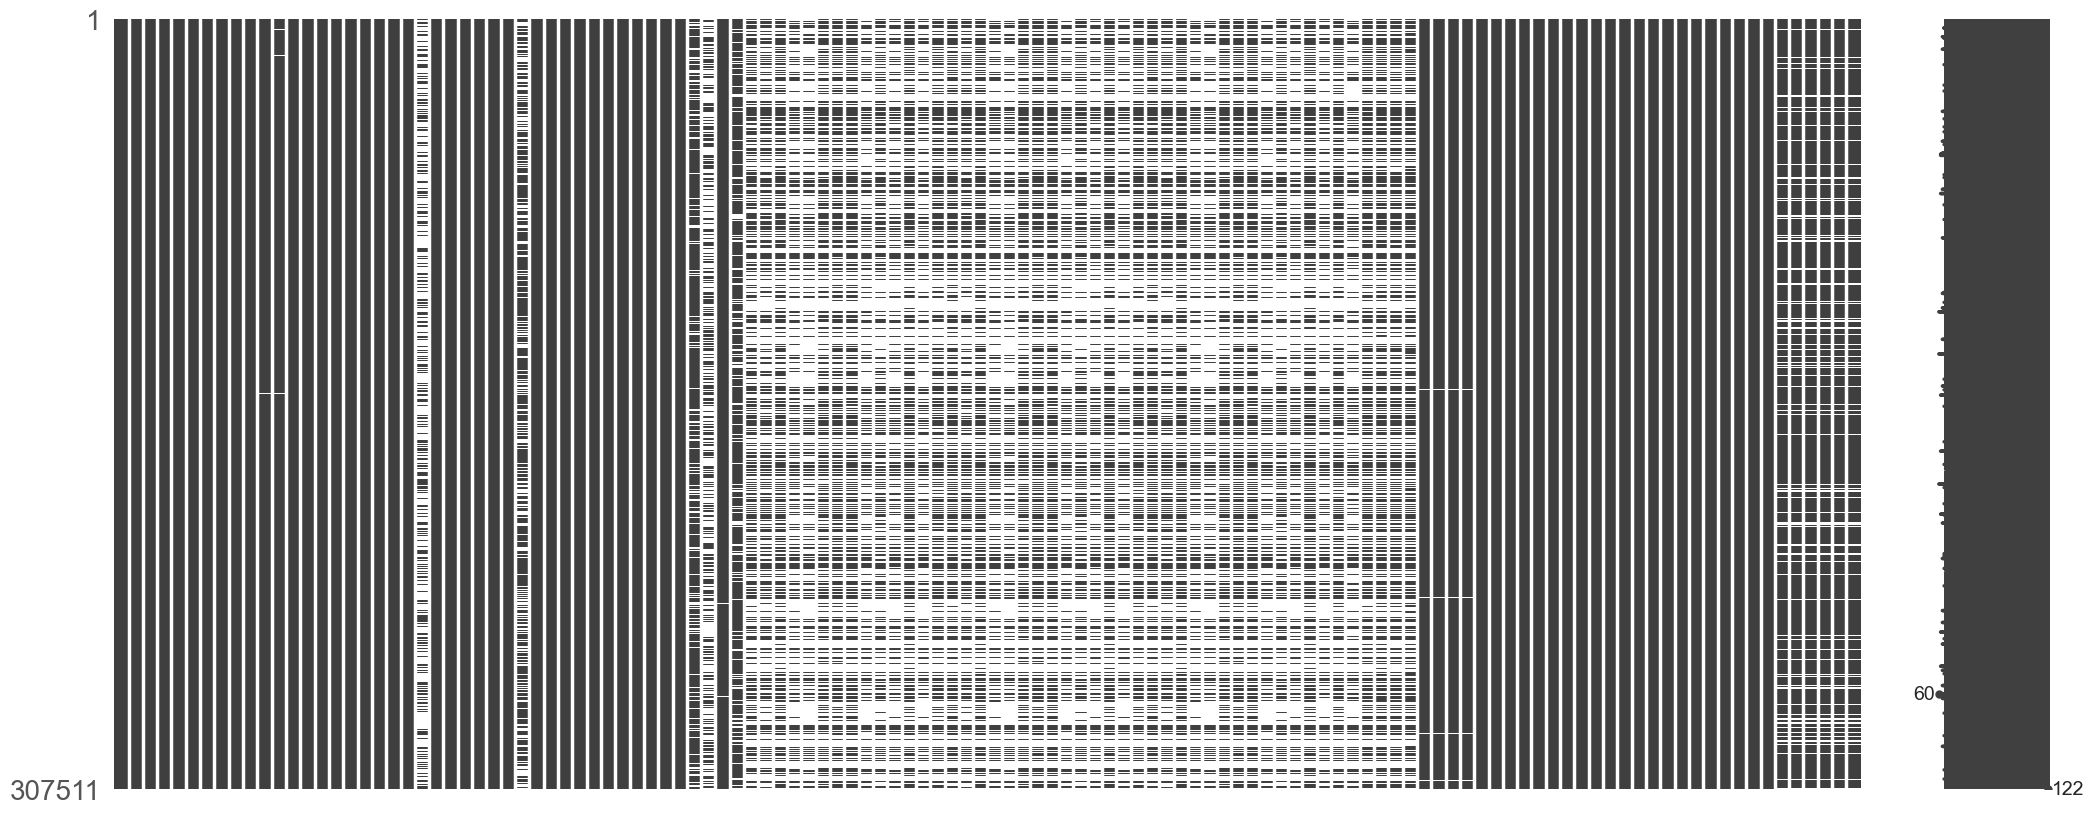

In [38]:
# appliquer la matrix pour visualiser les colonnes avec des valeurs NAN
msno.matrix(app_train)

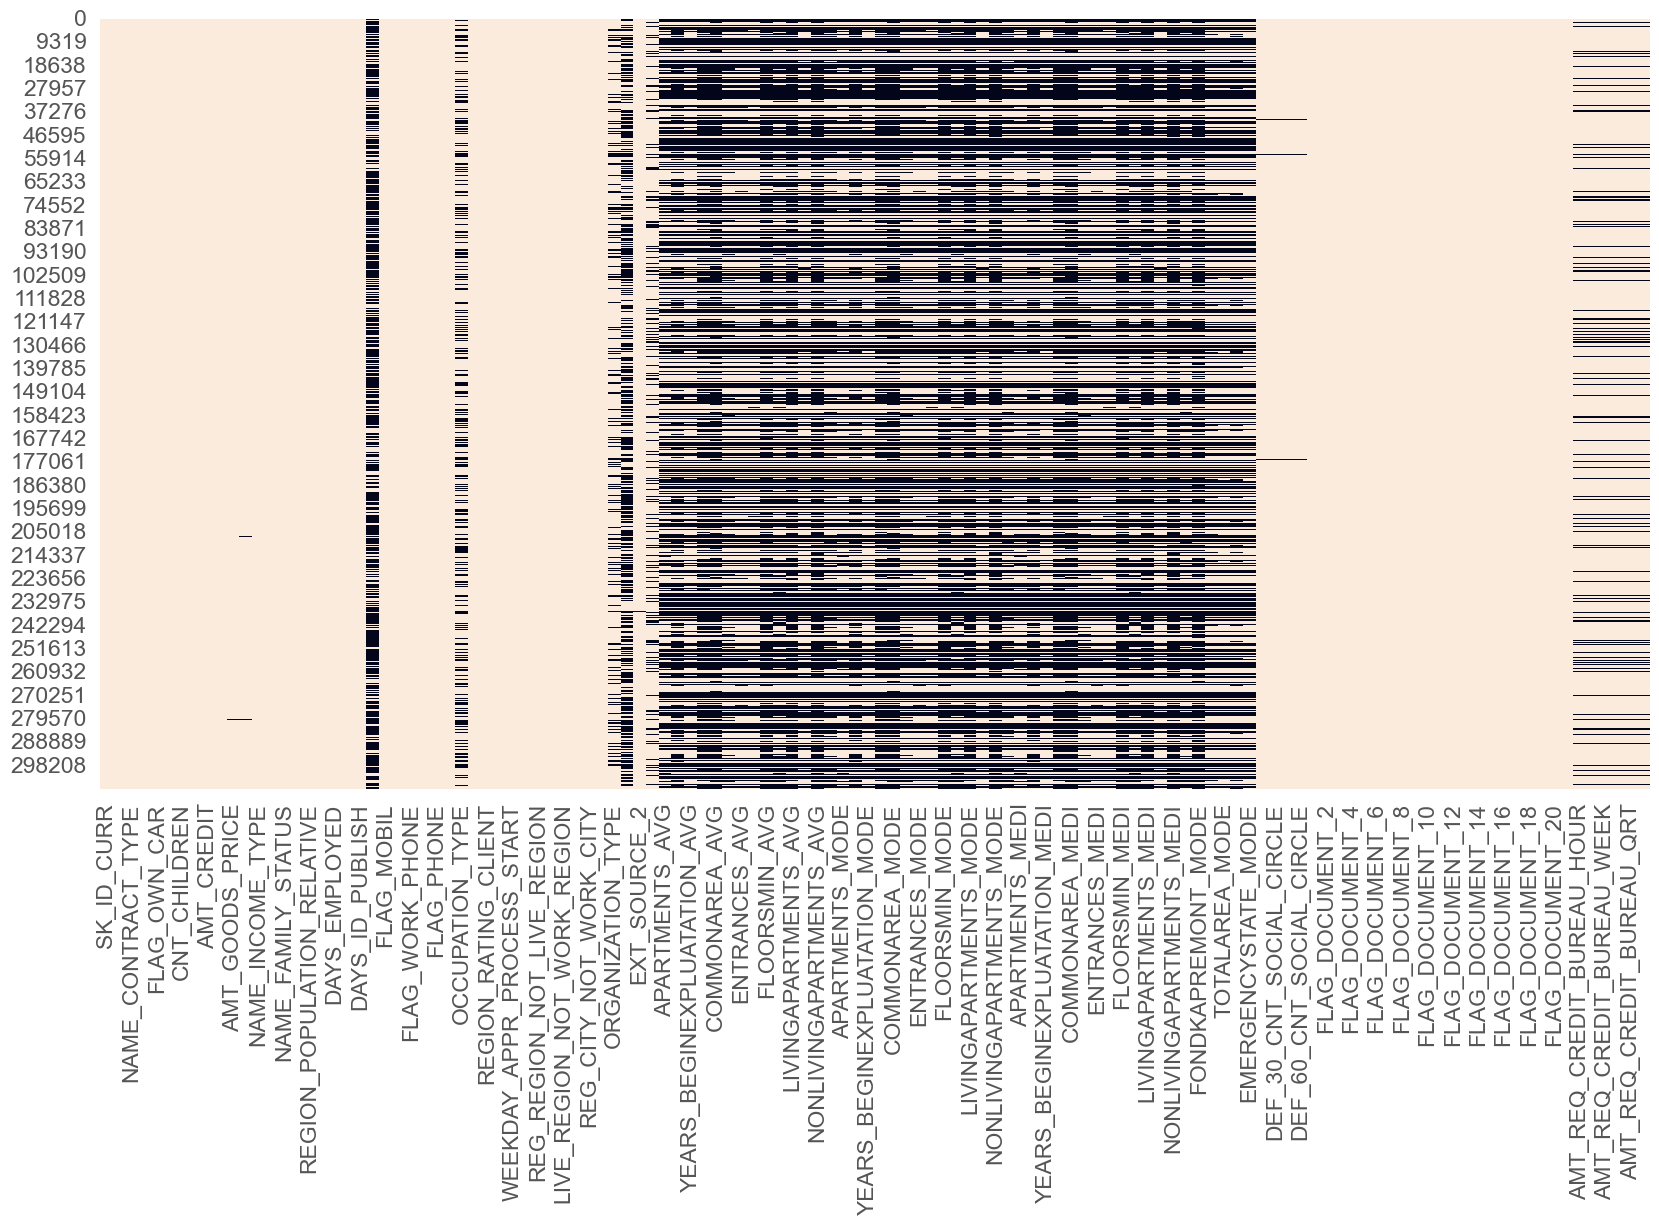

In [39]:
# Vue globale des valeurs manquantes (noir)

plt.figure(figsize=(20,10))  # Crée une nouvelle figure avec la taille spécifiée (20 pouces de largeur, 10 pouces de hauteur).

# Utilise la fonction heatmap de Seaborn pour créer une carte de chaleur des données non manquantes.
# La fonction notna() renvoie un DataFrame booléen où chaque élément est True si la valeur correspondante dans le DataFrame d'origine n'est pas manquante (non-NaN), sinon False.
sns.heatmap(app_train.notna(), cbar=False)

plt.show()  # Affiche la carte de chaleur.


Les données manquantes sont plus fortement présentent sur les caractéristiques des habitats (et non sur les crédits).

In [47]:
def missing_values_table(df):
    '''Fonction pour calculer le % de données manquantes sur le jeu de données saisi.'''

    # Calcul du nombre total de valeurs manquantes pour chaque colonne.
    mis_val = df.isnull().sum()
    
    # Calcul du pourcentage de valeurs manquantes pour chaque colonne.
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Concaténation des deux séries (nombre de valeurs manquantes et pourcentage) en un seul DataFrame.
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renommage des colonnes pour rendre le tableau plus explicite.
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Valeurs manquantes', 1 : '% des valeurs totales'})
    
    # Filtrage des colonnes ayant au moins une valeur manquante, tri par ordre décroissant du pourcentage de valeurs manquantes.
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values('% des valeurs totales', ascending=False).round(1)
    
    # Affichage du nombre de colonnes dans le DataFrame d'origine et du nombre de colonnes avec des valeurs manquantes.
    print("Votre dataframe sélectionné a " + str(df.shape[1]) + " colonnes.\n"      
          "Il y a " + str(mis_val_table_ren_columns.shape[0]) + " colonnes qui ont des valeurs manquantes.")
    
    # Renvoie du tableau récapitulatif des valeurs manquantes.
    return mis_val_table_ren_columns


In [48]:
# appliquer la fonction 
missing_values = missing_values_table(app_train)
missing_values.head(20)

Votre dataframe sélectionné a 122 colonnes.
Il y a 69 colonnes qui ont des valeurs manquantes.


Valeurs manquantes  % des valeurs totales
COMMONAREA_AVG                        214865                   69.9
COMMONAREA_MEDI                       214865                   69.9
COMMONAREA_MODE                       214865                   69.9
NONLIVINGAPARTMENTS_MEDI              213514                   69.4
NONLIVINGAPARTMENTS_AVG               213514                   69.4
NONLIVINGAPARTMENTS_MODE              213514                   69.4
FONDKAPREMONT_MODE                    210295                   68.4
LIVINGAPARTMENTS_AVG                  210199                   68.4
LIVINGAPARTMENTS_MEDI                 210199                   68.4
LIVINGAPARTMENTS_MODE                 210199                   68.4
FLOORSMIN_MEDI                        208642                   67.8
FLOORSMIN_AVG                         208642                   67.8
FLOORSMIN_MODE                        208642                   67.8
YEARS_BUILD_MODE                      204488                   66.5
YEARS_BUILD_MEDI                      204488                   66.5
YEARS_BUILD_AVG                       204488                   66.5
OWN_CAR_AGE                           202929                   66.0
LANDAREA_MEDI                         182590                   59.4
LANDAREA_AVG                          182590                   59.4
LANDAREA_MODE                         182590                   59.4

In [49]:
# NaN sur les variables catégorielles.
app_train.select_dtypes('object').isna().sum(axis=0)

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        4
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE              55374
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [50]:
# NaN sur ints.
app_train.select_dtypes('int64').isna().sum()

SK_ID_CURR                     0
TARGET                         0
CNT_CHILDREN                   0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_7                0
FLAG_DOCUMENT_8                0
FLAG_DOCUMENT_9                0
FLAG_DOCUMENT_10               0
FLAG_DOCUM

Il n'y a pas de données manquantes pour ce type de données.

In [51]:
# NaN sur les floats.
app_train.select_dtypes('float').isna().sum()

AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      12
AMT_GOODS_PRICE                 278
REGION_POPULATION_RELATIVE        0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 65, dtype: int64

#### 2.4 Données dupliquées

In [52]:
list_names = ['app_train', 'app_test']
datasets = [app_train, app_test]

# La boucle parcourt chaque nom de dataset dans la liste list_names
for name in list_names:
    # La méthode index() renvoie la position de l'élément dans la liste list_names.
    # On utilise cette position pour accéder au DataFrame correspondant dans la liste datasets.
    pos = list_names.index(name)
    dataset = datasets[pos]
    
    # La ligne suivante affiche le nombre de lignes en double dans le DataFrame dataset
    # en utilisant la méthode duplicated() avec comme argument la colonne 'SK_ID_CURR'.
    # La méthode sum() compte le nombre de lignes en double dans le DataFrame.
    print(f"Dupliqué du jeu de données {name}." )
    print(dataset.duplicated('SK_ID_CURR').sum())
    print("\n")


Dupliqué du jeu de données app_train.
0


Dupliqué du jeu de données app_test.
0




Il n'y a pas de doublon dans les jeux de données app_train et app_test.

#### 2.5 Outliers, valeurs atypiques, anormales

Ces erreurs peuvent être dues à des chiffres mal saisis, à des erreurs dans l'équipement de mesure ou à des mesures valides mais extrêmes.

**DAYS_BIRTH**

Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons les multiplier par -1 et les diviser par le nombre de jours dans une année 

In [53]:
# afficher la description DAYS_BIRTH (date de naissance)
app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Les valeurs sont négatives car enregistrées par rapport à la demande du prêt en cours. Il faut modifier ces dates pour plus de compréhension.

In [59]:
# (app_train['DAYS_BIRTH'] * -1 / 365).describe() idem
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

En moyenne, les clients ont 43 ans, le plus jeune a 20 ans et le plus âgé 69 ans. 50% des clients ont moins de 43 ans. Nous pouvons donc dire que l'étude est principalement axée sur les personnes d'une quarantaine d'années.

In [60]:
# Ajouter une nouvelle colonne 'AGE' dans le DataFrame app_train
# Arrondir le résultat à l'entier le plus proche pour obtenir l'âge en années
app_train['AGE'] = round(app_train['DAYS_BIRTH'] / -365).astype('int')

# Ajouter une nouvelle colonne 'AGE' dans le DataFrame app_test
# Arrondir le résultat à l'entier le plus proche pour obtenir l'âge en années
app_test['AGE'] = round(app_test['DAYS_BIRTH'] / -365).astype('int')


In [61]:
app_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

Text(0, 0.5, 'Count')

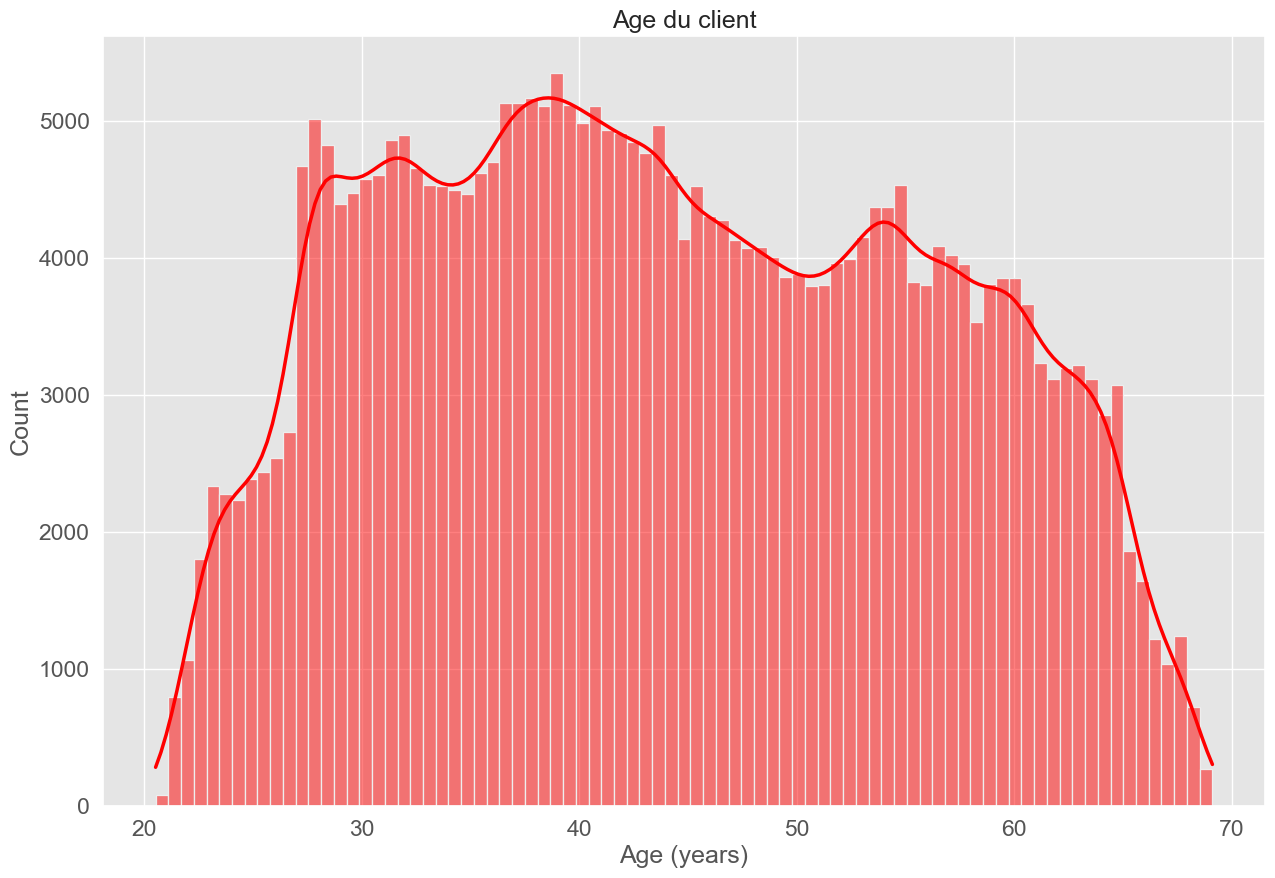

In [62]:
 # Distribution des âges. (en année)
plt.figure(figsize=(15,10))
sns.histplot(app_train['DAYS_BIRTH'] / -365, stat='count', color='red', kde="True")
plt.title('Age du client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

 Il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables

**DAYS_EMPLOYED** 

Combien de jours avant la candidature, la personne a commencé l'emploi actuel, seulement le temps relatif à la candidature

In [63]:
# visualiser la description de la colonne DAYS_EMPLOYED pour le train
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [64]:
# visualiser la description de la colonne DAYS_EMPLOYED pour le test
app_test['DAYS_EMPLOYED'].describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

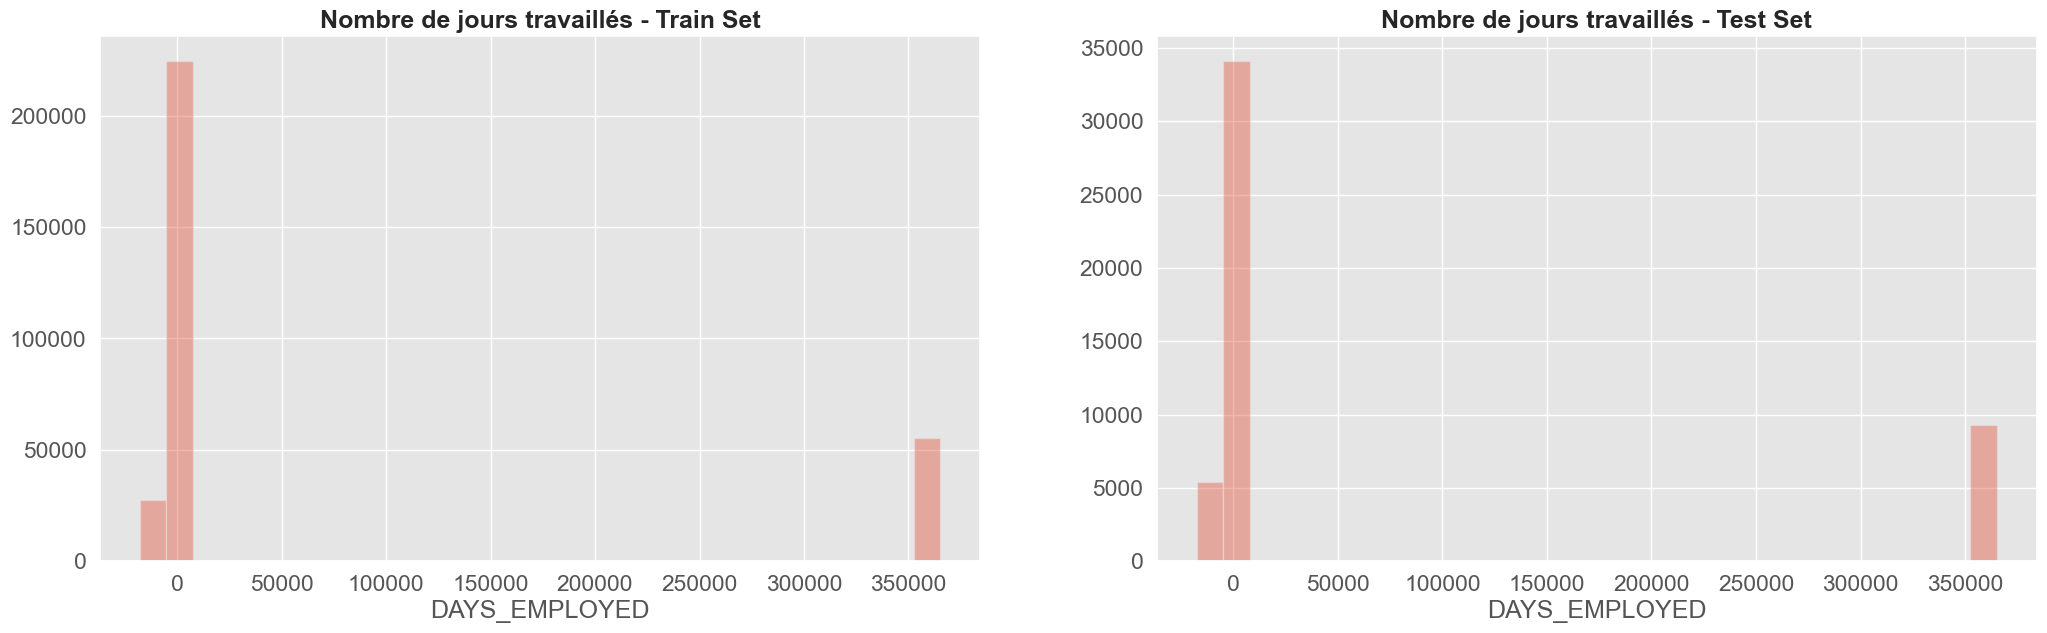

In [69]:
# Créer une figure pour le graphique 
plt.figure(figsize=(25, 15))

# Premier sous-plot : distribution du nombre de jours travaillés dans le DataFrame app_train
plt.subplot(2, 2, 1)

# Ajouter un titre au sous-plot pour indiquer qu'il représente la distribution des jours travaillés dans le train set
plt.title('Nombre de jours travaillés - Train Set', weight='bold', size=18)

# Utiliser la fonction sns.distplot pour créer un histogramme avec estimation de densité (KDE) pour la colonne 'DAYS_EMPLOYED' dans app_train
sns.distplot(app_train['DAYS_EMPLOYED'], kde=False, bins=30)

# Deuxième sous-plot : distribution du nombre de jours travaillés dans le DataFrame app_test
plt.subplot(2, 2, 2)

# Ajouter un titre au sous-plot pour indiquer qu'il représente la distribution des jours travaillés dans le test set
plt.title('Nombre de jours travaillés - Test Set', weight='bold', size=18)

# Utiliser la fonction sns.distplot pour créer un histogramme avec estimation de densité (KDE) pour la colonne 'DAYS_EMPLOYED' dans app_test
sns.distplot(app_test['DAYS_EMPLOYED'], kde=False, bins=30)

# Afficher le graphique avec les deux sous-plots
plt.show()


Ici avec cette analyse, on peut voir qu'il y a des données anormales car le maximun représente environ 100 ans de travail (ce qui est impossible).

In [73]:
# Créer un DataFrame `anom` qui contient les données où la colonne 'DAYS_EMPLOYED' est supérieure ou égale à 350000
anom = app_train[app_train['DAYS_EMPLOYED'] >= 350000]

# Créer un DataFrame `non_anom` qui contient les données où la colonne 'DAYS_EMPLOYED' est strictement inférieure à 350000
non_anom = app_train[app_train['DAYS_EMPLOYED'] < 350000]

# Calculer le taux de défaut moyen (TARGET = 1) pour les individus dans le DataFrame `non_anom` et l'afficher en pourcentage
print('Les non-anomalies par défaut sur %0.2f%% des prêts' % (100 * non_anom['TARGET'].mean()))

# Calculer le taux de défaut moyen (TARGET = 1) pour les individus dans le DataFrame `anom` et l'afficher en pourcentage
print('Les anomalies par défaut sur %0.2f%% des prêts' % (100 * anom['TARGET'].mean()))

# Afficher le nombre d'éléments considérés comme des anomalies dans la colonne 'DAYS_EMPLOYED'
print('Il y a %d jours de travail anormaux' % len(anom))


Les non-anomalies par défaut sur 8.66% des prêts
Les anomalies par défaut sur 5.40% des prêts
Il y a 55374 jours de travail anormaux


Lorsqu'il n'y a pas d'anomalies, il y a en moyenne 8,66% de défaut. Les anomalies ont 5,40% de défaut et donc un taux inférieur. Nous remplirons les valeurs anormales sans nombre (np.nan) et changerons le nombre de jours en nombre moyen de jours travaillés.

In [74]:
anom['DAYS_EMPLOYED'].unique()

array([365243], dtype=int64)

In [75]:
# Créer une colonne pour marquer les valeurs de la colonne 'DAYS_EMPLOYED
# Créer une nouvelle colonne 'DAYS_EMPLOYED_ANOM' dans `app_train` qui est égale à True si la valeur de 'DAYS_EMPLOYED' est égale à 365243, sinon False
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Convertir la colonne 'DAYS_EMPLOYED_ANOM' en type 'object' (pour stocker des valeurs True/False)
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED_ANOM'].astype('object')

# Répéter le même processus pour `app_test`
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED_ANOM'].astype('object')


In [76]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
AGE                             int32
DAYS_EMPLOYED_ANOM             object
Length: 124, dtype: object

In [77]:
# Remplacer les valeurs anormales par nan
# Remplacer la valeur 365243 par NaN dans la colonne 'DAYS_EMPLOYED' du DataFrame
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


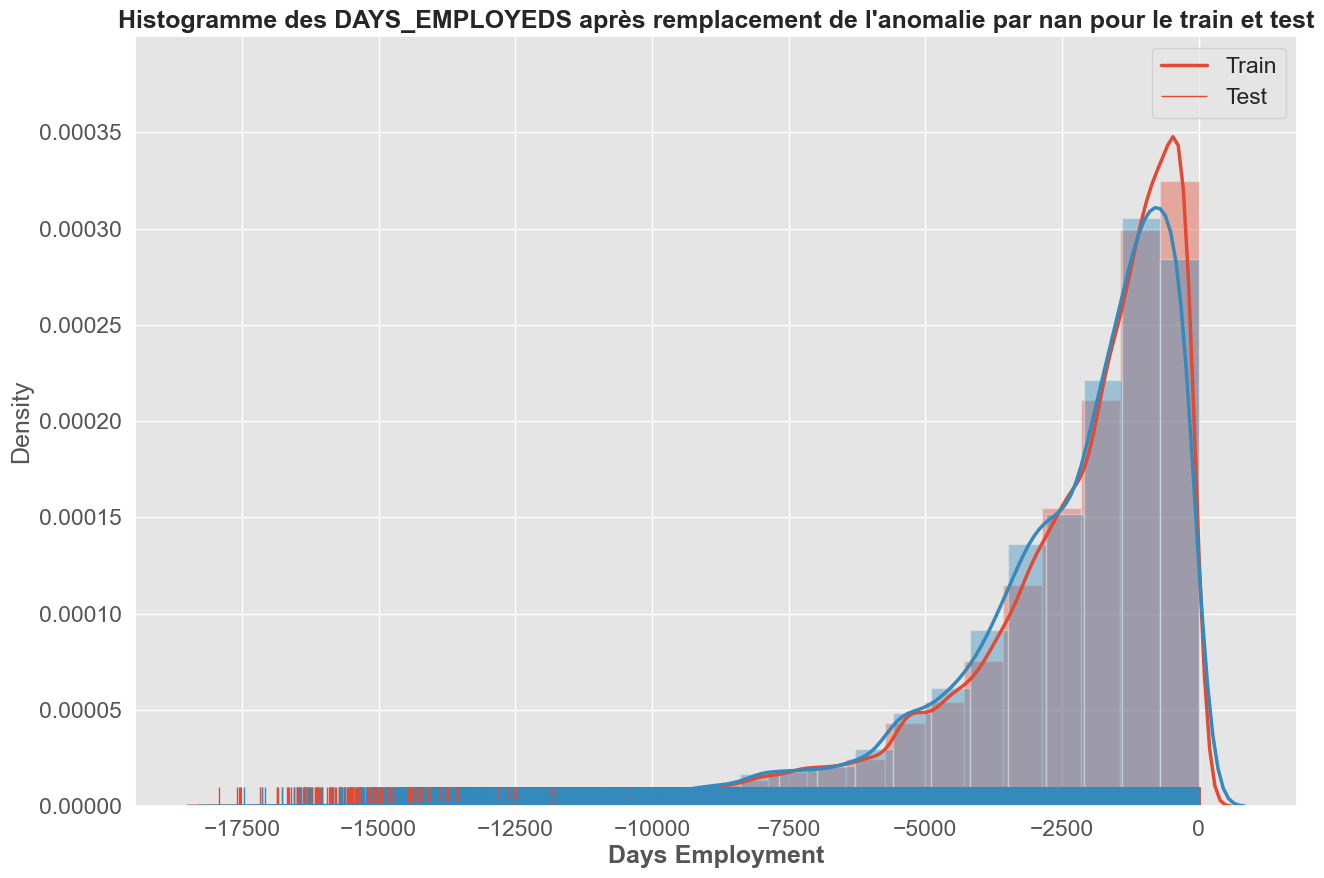

Il y a 55374 anomalies dans le test data sur 307511 entrées dans le train set 

Il y a 9274 anomalies dans le test data sur 48744 entrées dans le test set



In [79]:
plt.figure(figsize=(15,10))
sns.distplot(app_train['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)
sns.distplot(app_test['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)
plt.title("Histogramme des DAYS_EMPLOYEDS après remplacement de l'anomalie par nan pour le train et test",
          weight='bold', size=18)
plt.xlabel('Days Employment', weight="bold")
labels= ["Train", "Test"]
plt.legend(labels)
plt.show()

print("Il y a %d anomalies dans le test data sur %d entrées dans le train set \n" % (app_train["DAYS_EMPLOYED"].isna().sum(), len(app_train)))
print("Il y a %d anomalies dans le test data sur %d entrées dans le test set\n" % (app_test["DAYS_EMPLOYED"].isna().sum(), len(app_test)))

### 3 - Analyse : Train

In [81]:
# comparer la répartition d'une variable catégorielle entre training set et le testing set

def test_train_col_category(dataframe_train, dataframe_test, col, size):
    """Cette fonction représente les variables catégorielles sous la forme d'un diagramme à secteurs.
     dataframe : dataset
     taille : taille de la figure (X,X)"""
    
    # Calculer les valeurs et les étiquettes de la variable 'col' dans le training set
    values_train = dataframe_train[col].value_counts()
    labels_train = dataframe_train[col].value_counts().index
    
    # Calculer les valeurs et les étiquettes de la variable 'col' dans le testing set
    values_test = dataframe_test[col].value_counts()
    labels_test = dataframe_test[col].value_counts().index
    
    # Créer une figure de taille 'size'
    plt.figure(figsize=size)
    
    # Plot 1 : Pie plot pour le training set
    plt.subplot(2, 2, 1)
    plt.title(f"Représentation de la variable {col} pour le training set", fontsize=20)
    plt.pie(values_train, labels=labels_train,
            autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
    # Plot 2 : Pie plot pour le testing set
    plt.subplot(2, 2, 2)
    plt.title(f"Représentation de la variable {col} pour le testing set", fontsize=20)
    plt.pie(values_test, labels=labels_test,
            autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    plt.axis('equal')  # Pour assurer que le plot soit un cercle
    plt.tight_layout()
    plt.legend()
    plt.show()


In [82]:
def plot_stat(data, feature, title, size):
    '''cette fonction crée un graphique count plot
     pour une variable catégorielle spécifique dans un DataFrame'''
    
    # Créer une figure et un axe de taille 'size'
    ax, fig = plt.subplots(figsize=size)
    
    # Utiliser seaborn pour créer le count plot de la variable 'feature'
    # en spécifiant l'ordre des catégories selon leur fréquence décroissante
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    
    # Définir le titre du graphique
    ax.set_title(title)

    # Ajouter les pourcentages au-dessus de chaque barre
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width() / len(data[feature]))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    # Afficher le graphique
    plt.show()


In [88]:
def plot_percent_target1(data, feature, title, size):
    ''' cette fonction crée un graphique à barres 
    qui montre le pourcentage de la variable target 
    ayant la valeur 1 pour chaque catégorie 
    d'une variable catégorielle spécifique dans un DataFrame'''
    
    # Calculer le pourcentage de la variable cible ayant la valeur 1 pour chaque catégorie de 'feature'
    cat_perc = data[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    # Créer une figure et un axe de taille 'size'
    ax, fig = plt.subplots(figsize=size)
    
    # Utiliser seaborn pour créer un barplot en spécifiant les données et les axes
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    
    # Définir le titre du graphique
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage de la target avec la valeur 1")

    # Ajouter les pourcentages au-dessus de chaque barre
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width())
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    # Afficher le graphique
    plt.show()


**Loan types** 

- Distribution du type de prêts contractés

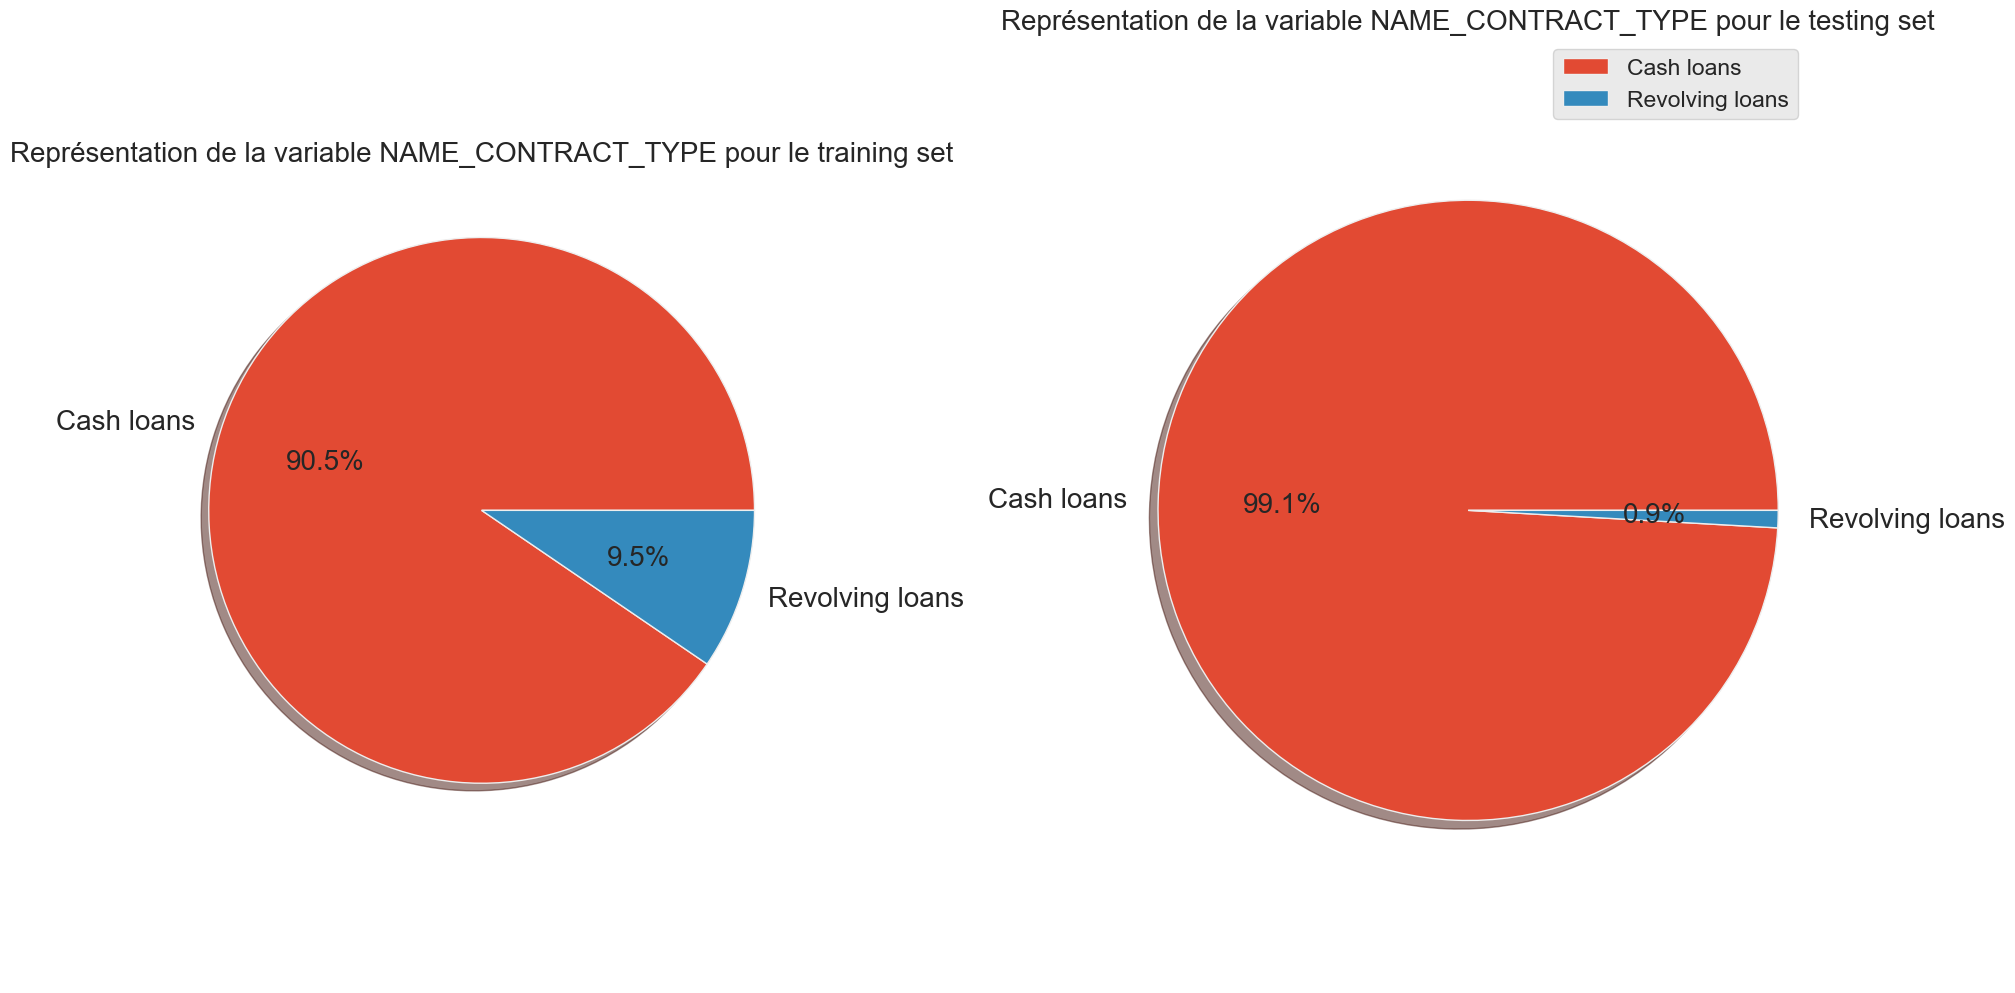

In [84]:
# comparer la répartition d'une variable catégorielle entre training set et le testing set
test_train_col_category(app_train, app_test, 'NAME_CONTRACT_TYPE', (20,20))

Les prêts renouvelables ne représentent que 10% du nombre total de prêts

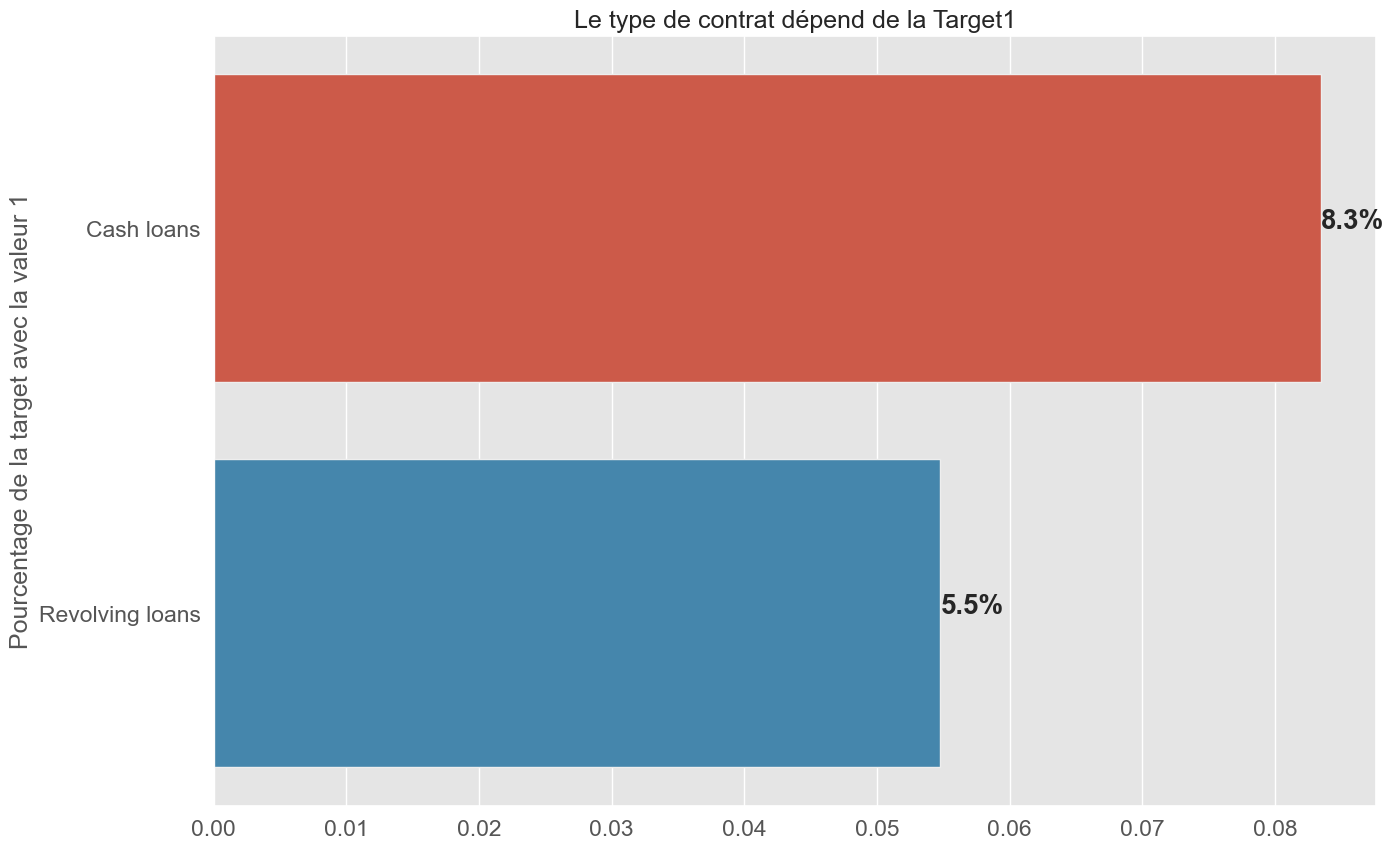

In [89]:
# pourcentage de la variable target ayant la valeur 1 pour catégorie NAME_CONTRACT_TYPE
plot_percent_target1(app_train, 'NAME_CONTRACT_TYPE',"Le type de contrat dépend de la Target1", (15,10))

La majorité des crédits non remboursés sont non renouvelables. (étude par rapport à leur fréquence d'apparition).

**Client gender** 
- Distribution H/F clients selon le remboursement du prêt

Précédement, nous avons pu voir que les clients du genre féminin sont deux fois plus présents que les clients masculins dans le jeu de données.

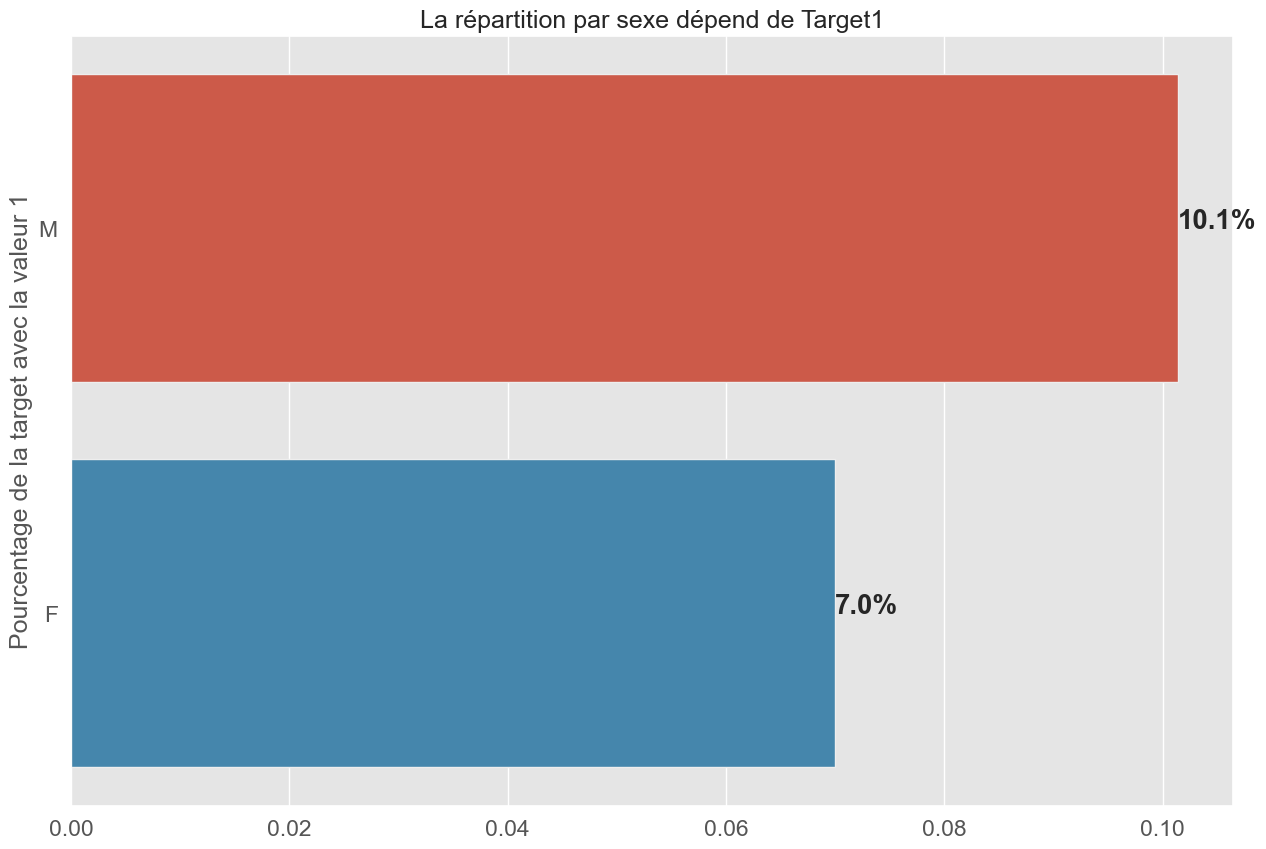

In [90]:
plot_percent_target1(app_train, 'CODE_GENDER',"La répartition par sexe dépend de Target1", (15,10))

Les hommes ont tendance à moins rembourser leur crédits.

**Flag own car** 
- Distribution de la possession d'une voiture

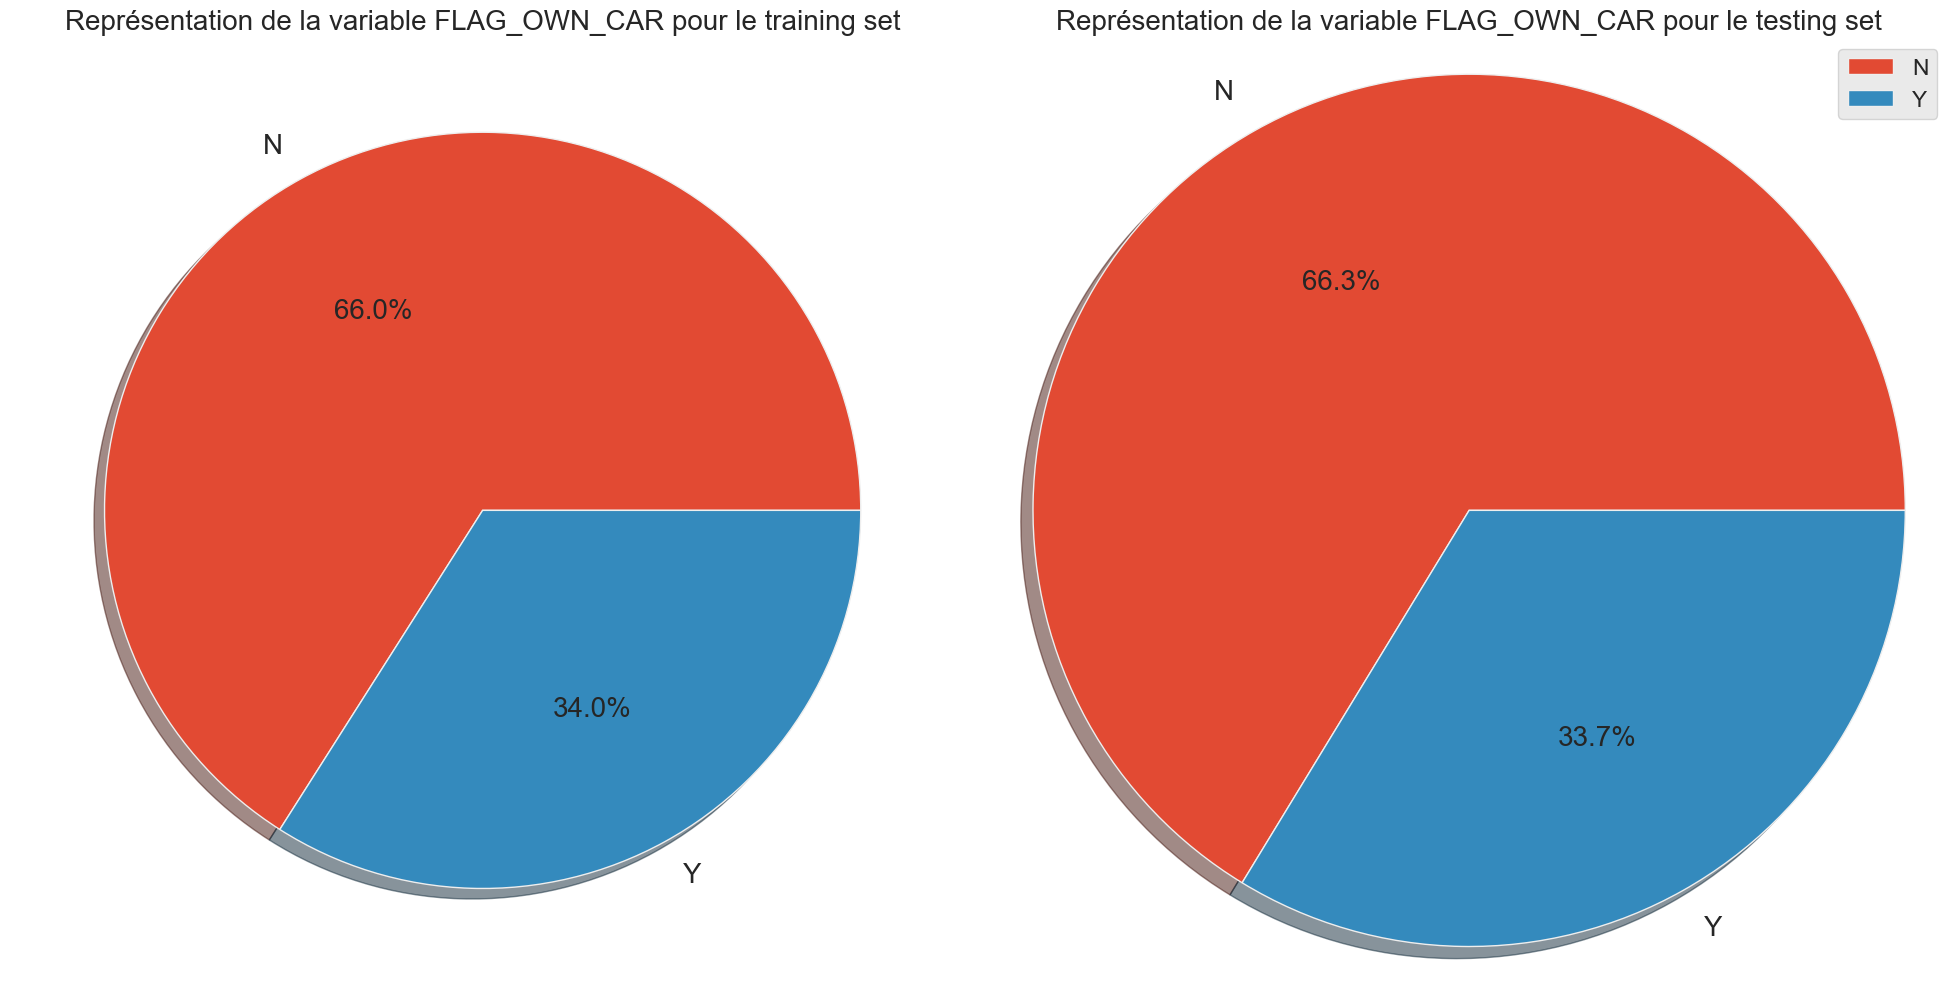

In [91]:
test_train_col_category(app_train, app_test, 'FLAG_OWN_CAR', (20,20))

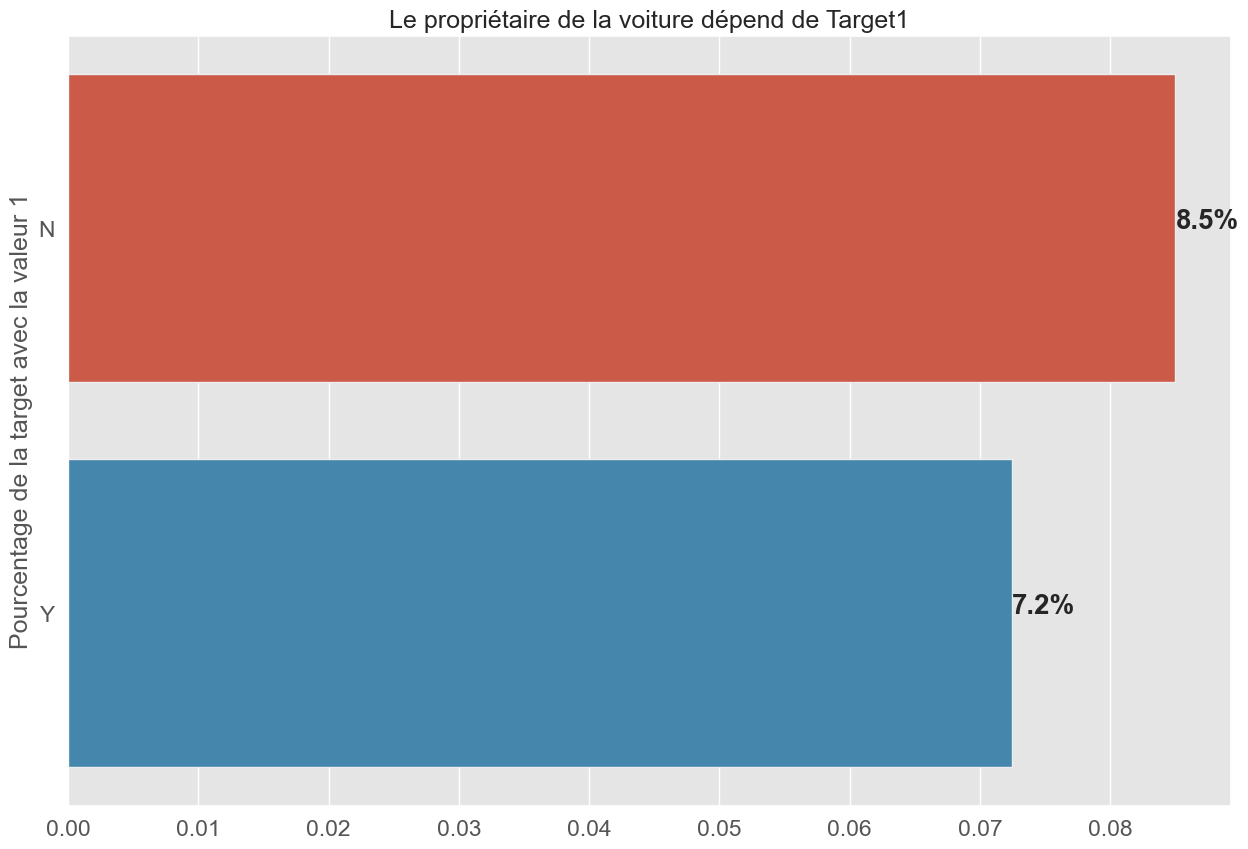

In [92]:
plot_percent_target1(app_train, 'FLAG_OWN_CAR',"Le propriétaire de la voiture dépend de Target1", (15,10))

Le taux de non remboursement est de 8% que le client ait ou non une voiture.

**Cnt Children** 
- Distribution du nombre d'enfants

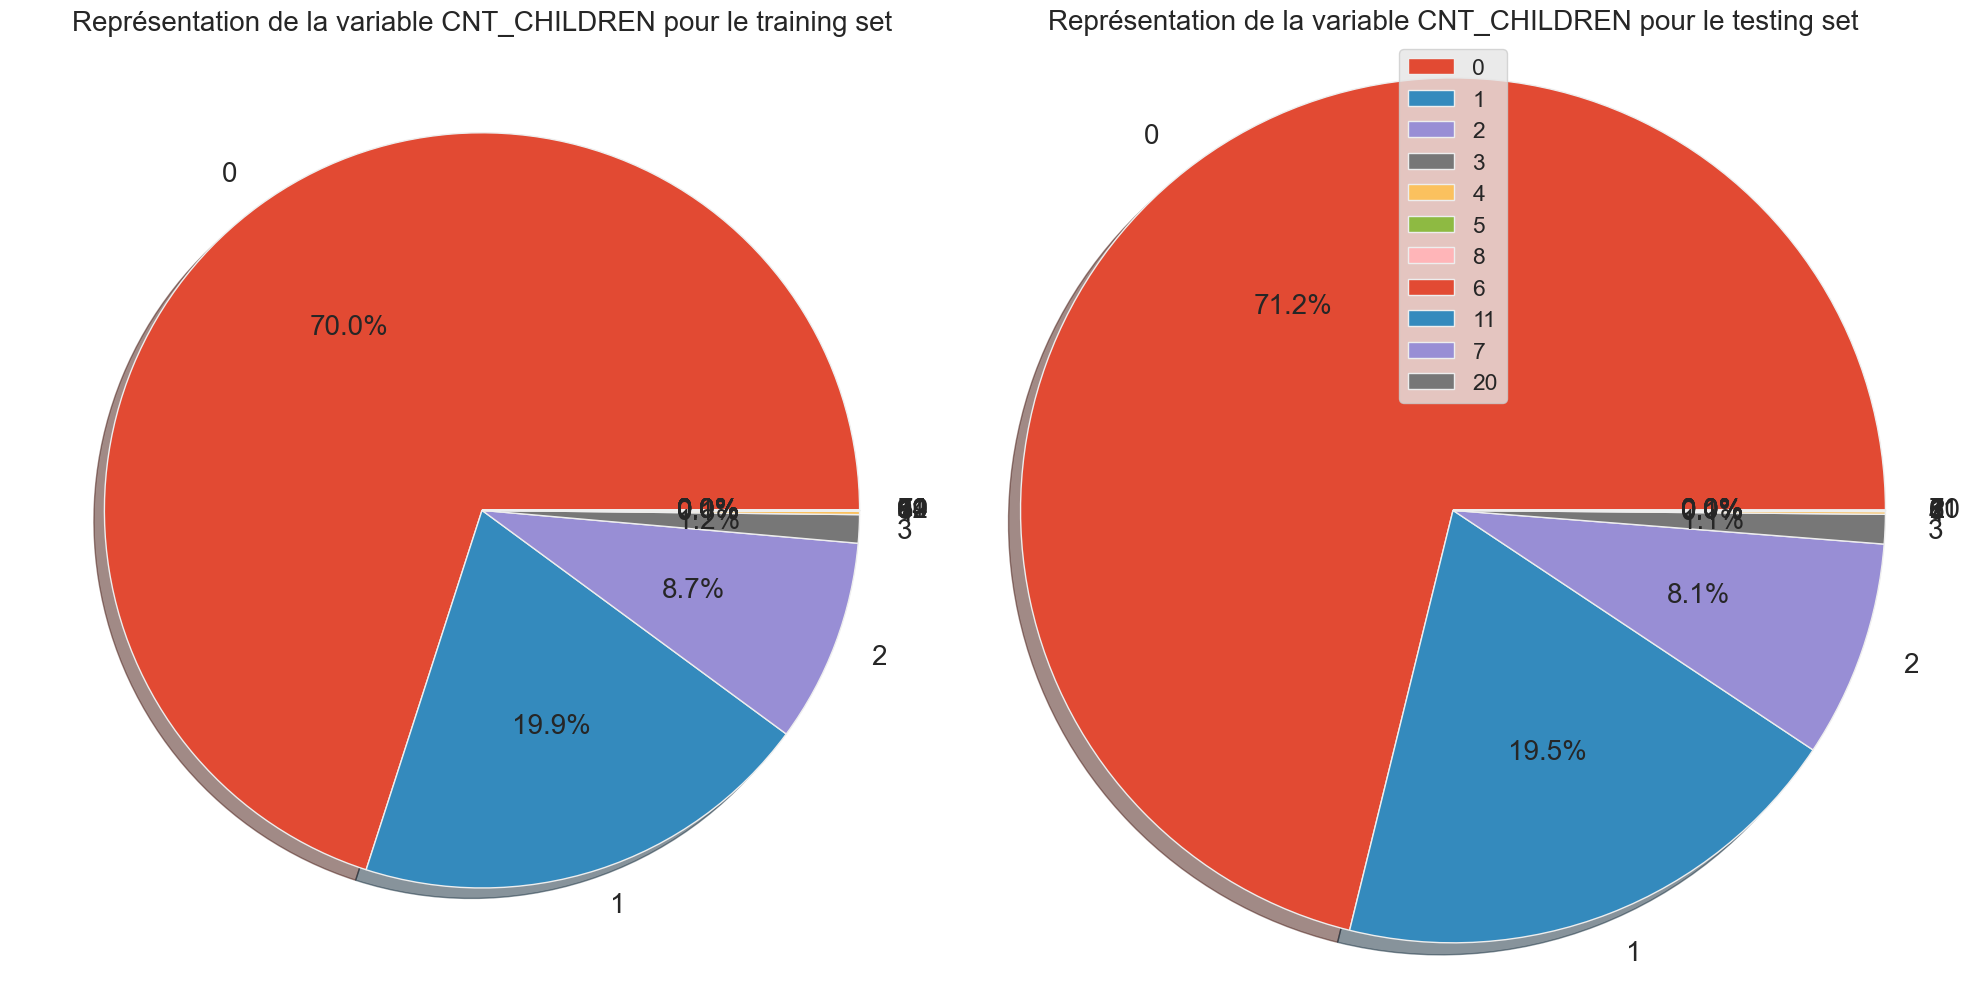

In [94]:
test_train_col_category(app_train, app_test, 'CNT_CHILDREN', (20,20))

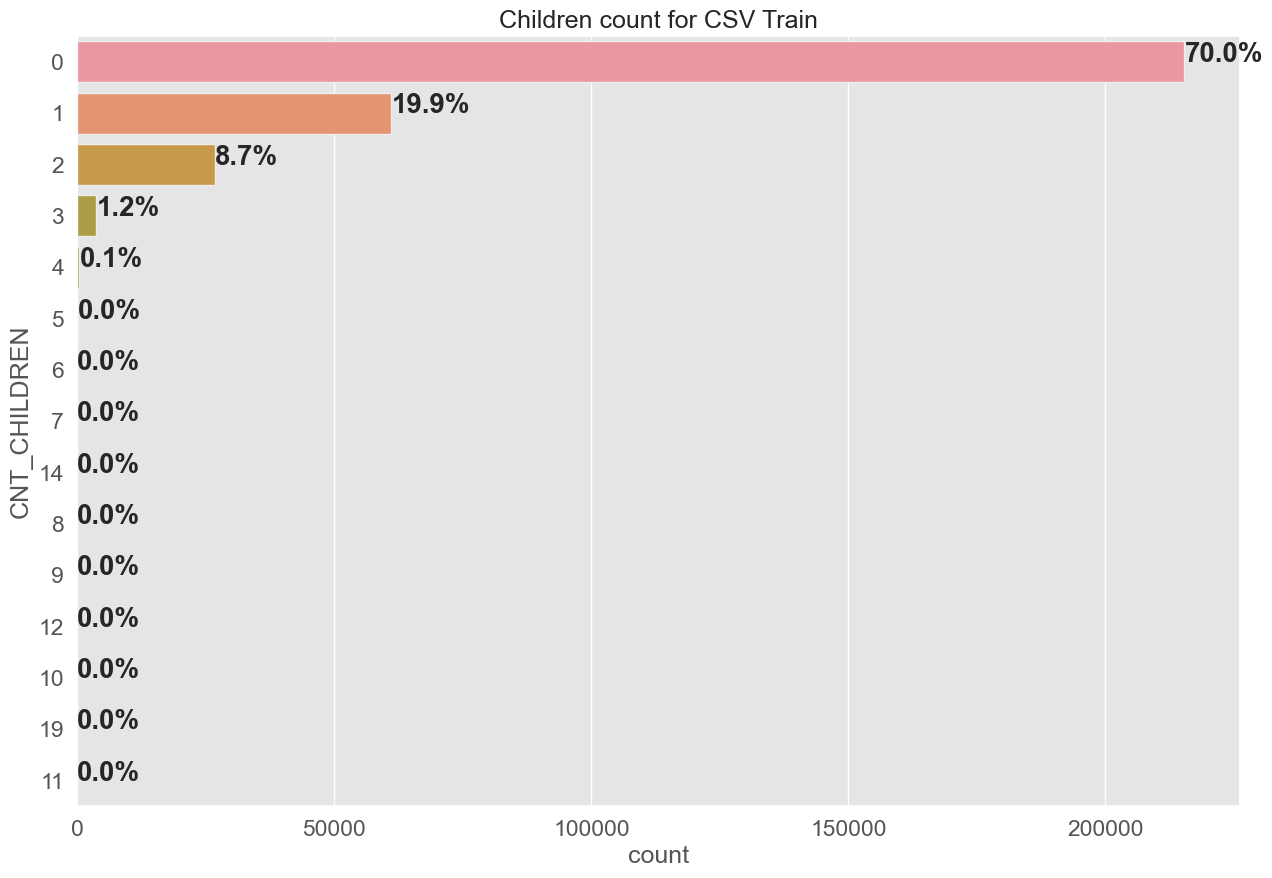

In [95]:
plot_stat(app_train, 'CNT_CHILDREN', 'Children count for CSV Train', (15,10)) 

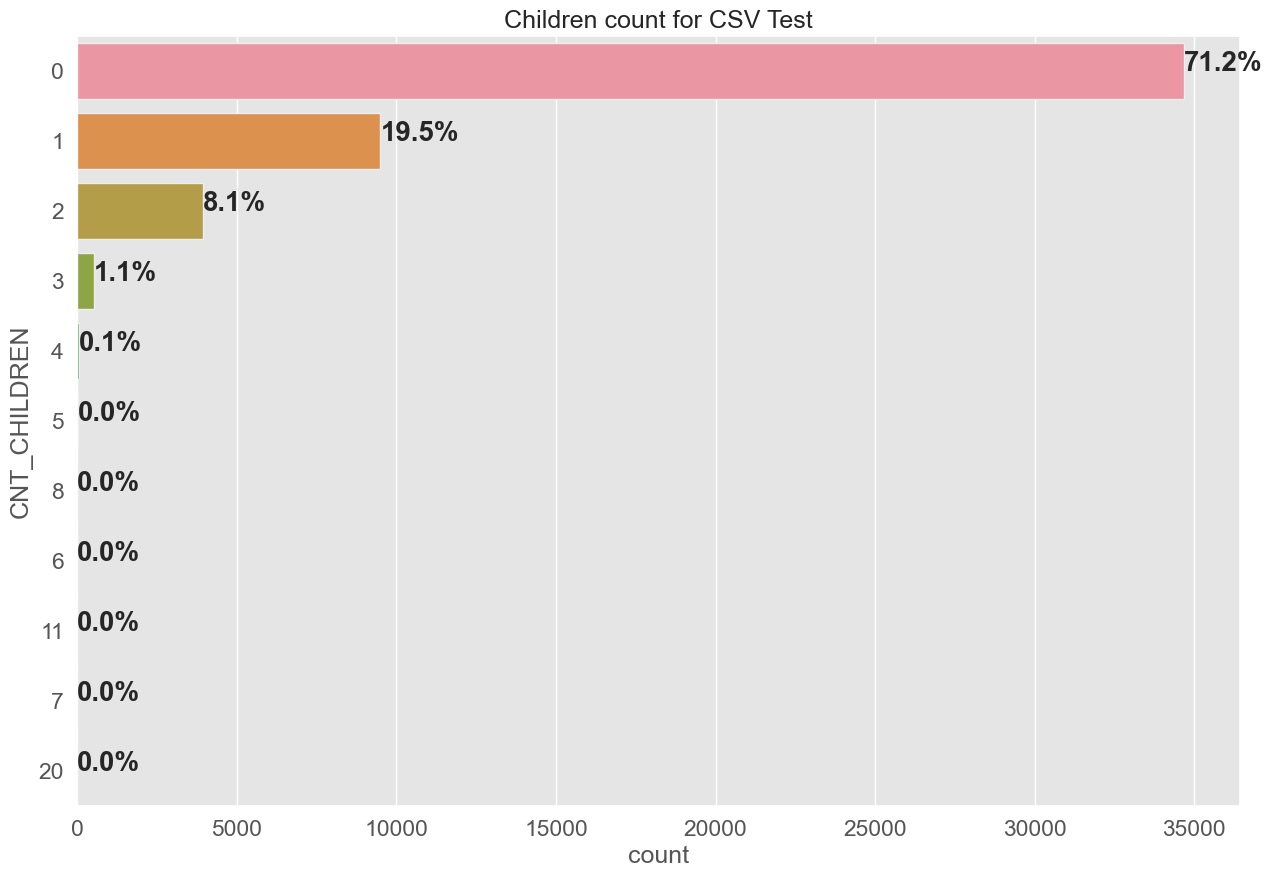

In [96]:
plot_stat(app_test, 'CNT_CHILDREN', 'Children count for CSV Test', (15,10)) 

En ce qui concerne le nombre d'enfants, nous pouvons constater que la majorité des clients n'ont pas d'enfant. Plus de 20% des clients ont 1 enfant, 8% en ont 2 et 1% en ont 3. Les proportions sont assez équivalentes entre le test d'entraînement et le test d'essai.

**Family Status** 
- Distribution du status familial

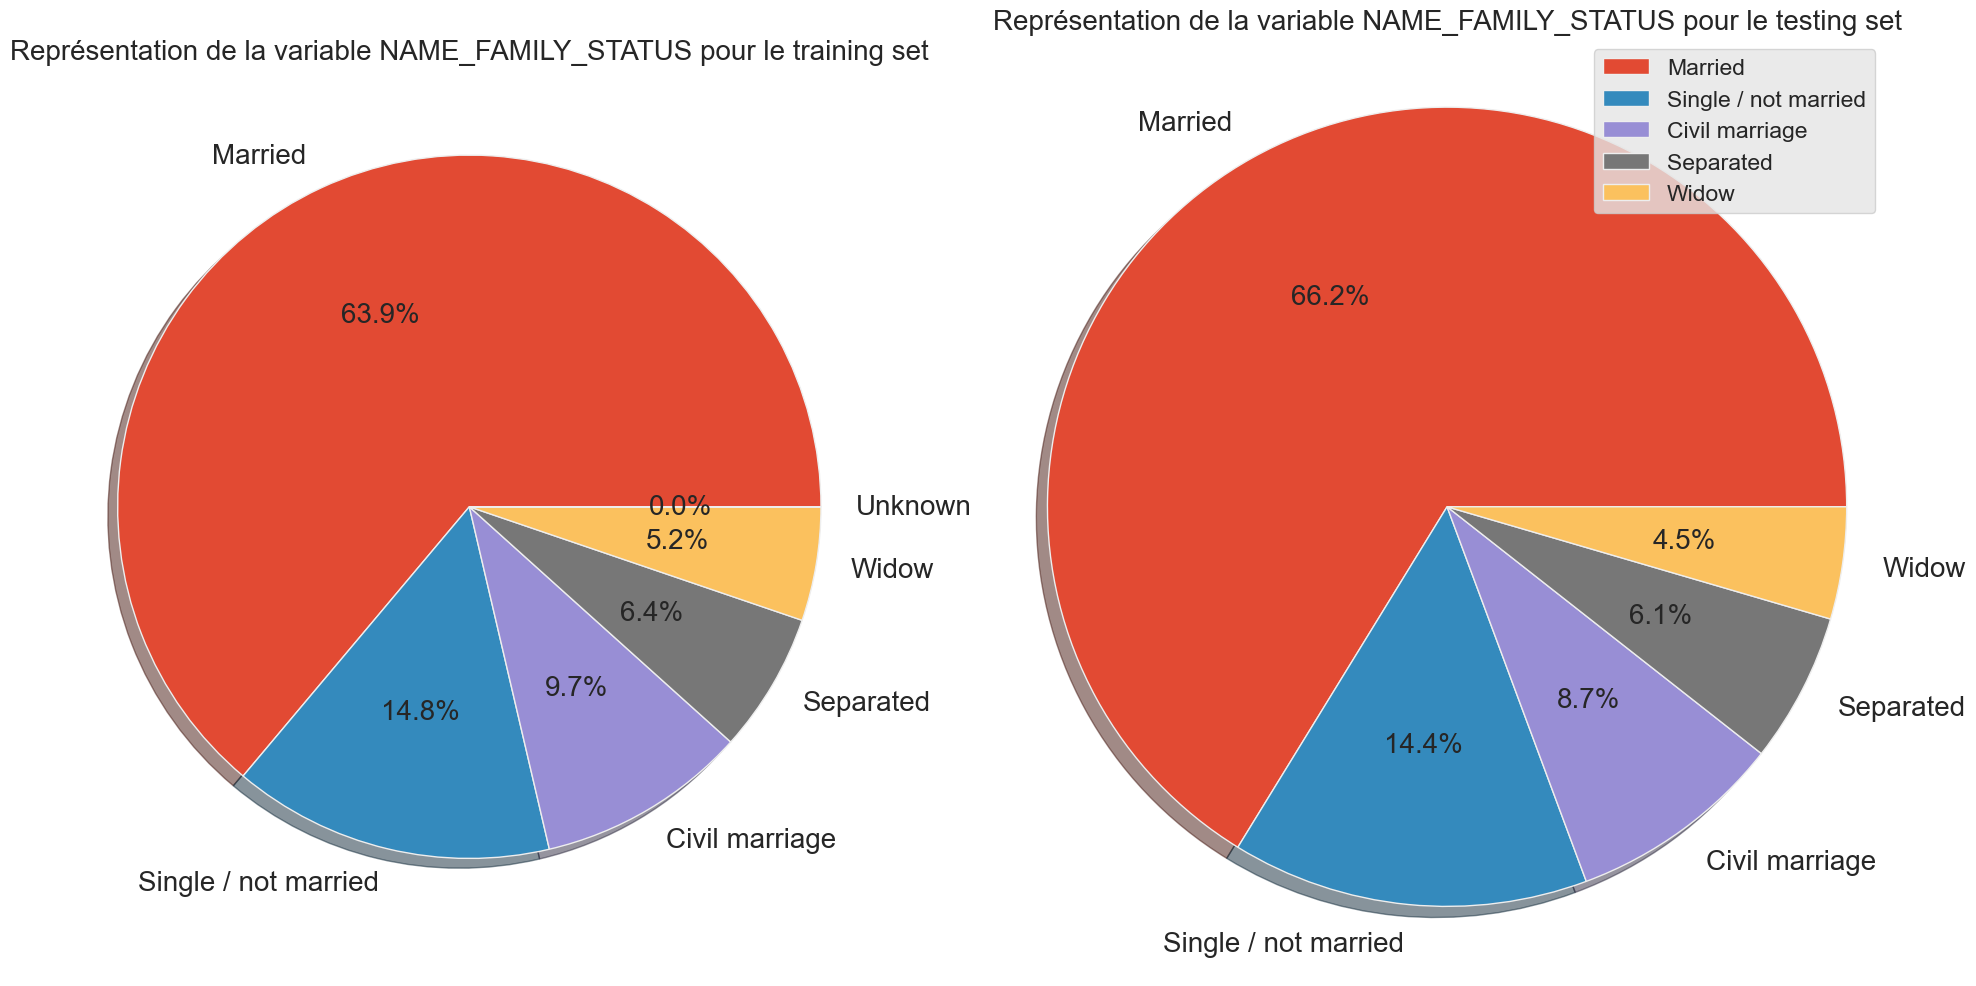

In [97]:
test_train_col_category(app_train, app_test, 'NAME_FAMILY_STATUS', (20,20))

La grande majorité des clients sont mariés ou en couple.

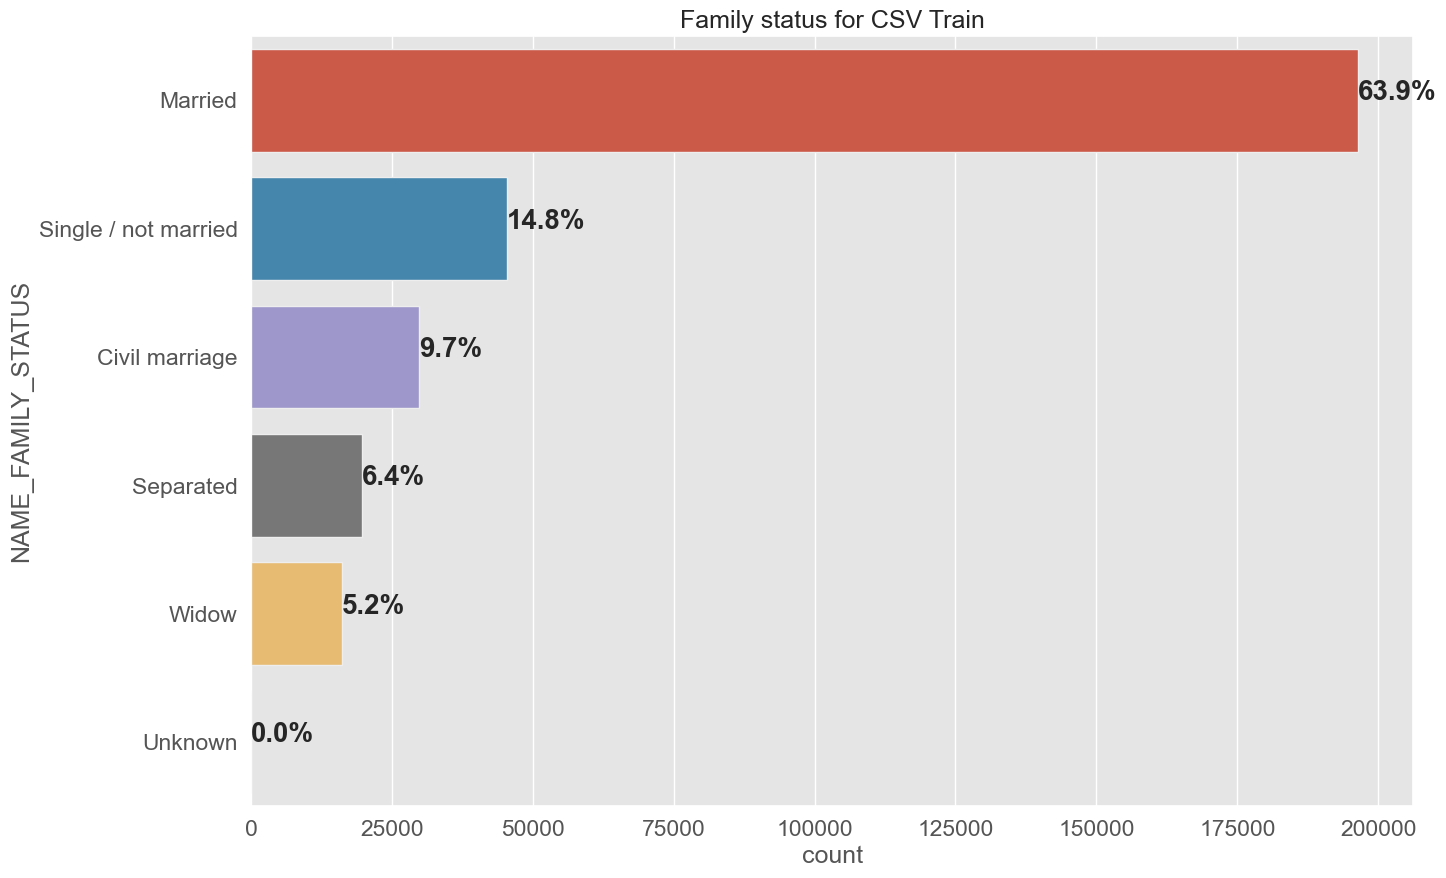

In [98]:
plot_stat(app_train, 'NAME_FAMILY_STATUS', 'Family status for CSV Train', (15,10)) 

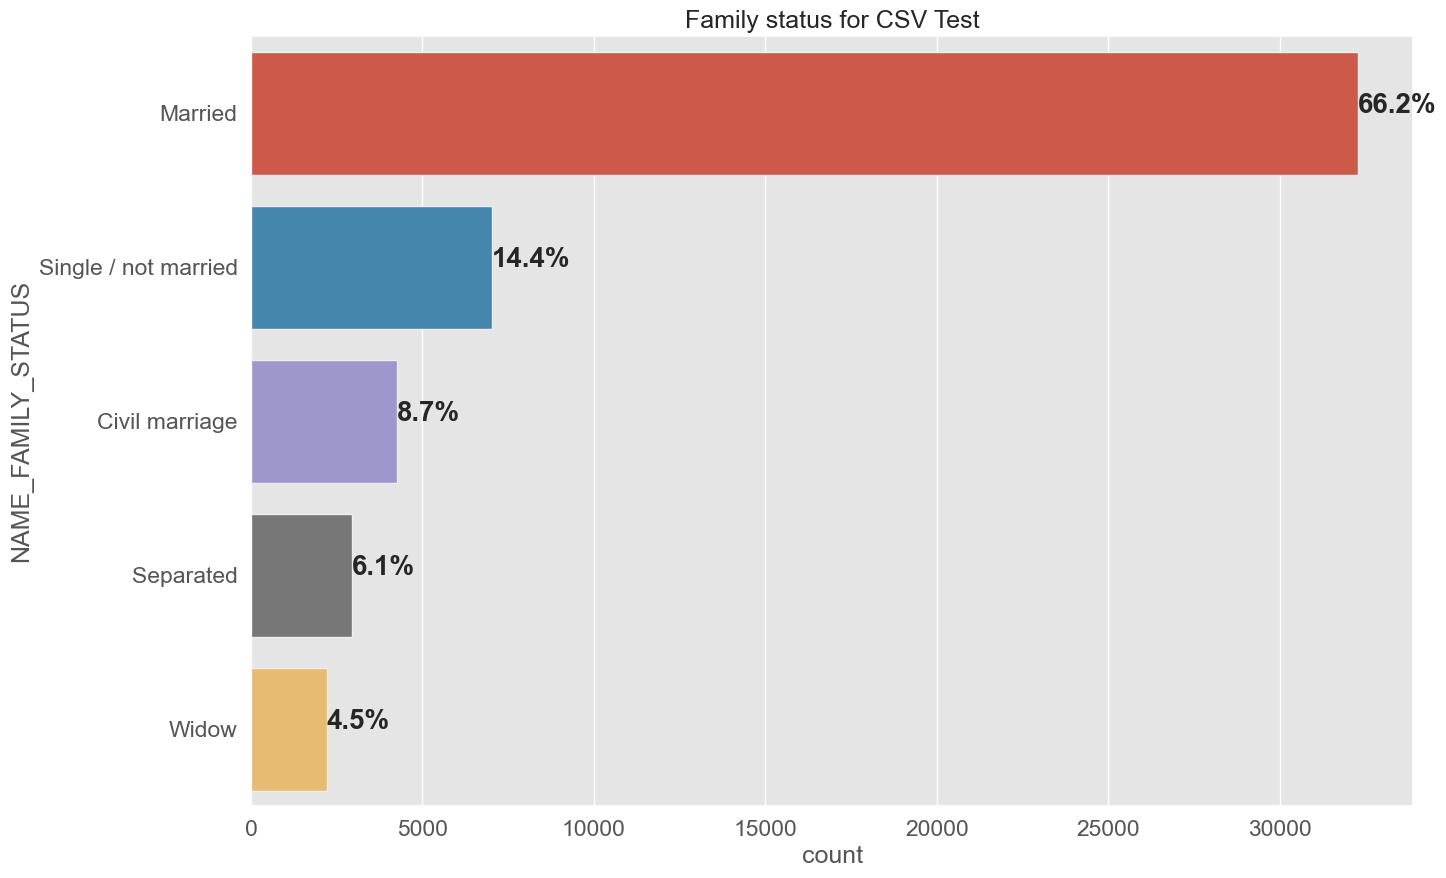

In [99]:
plot_stat(app_test, 'NAME_FAMILY_STATUS', 'Family status for CSV Test', (15,10)) 

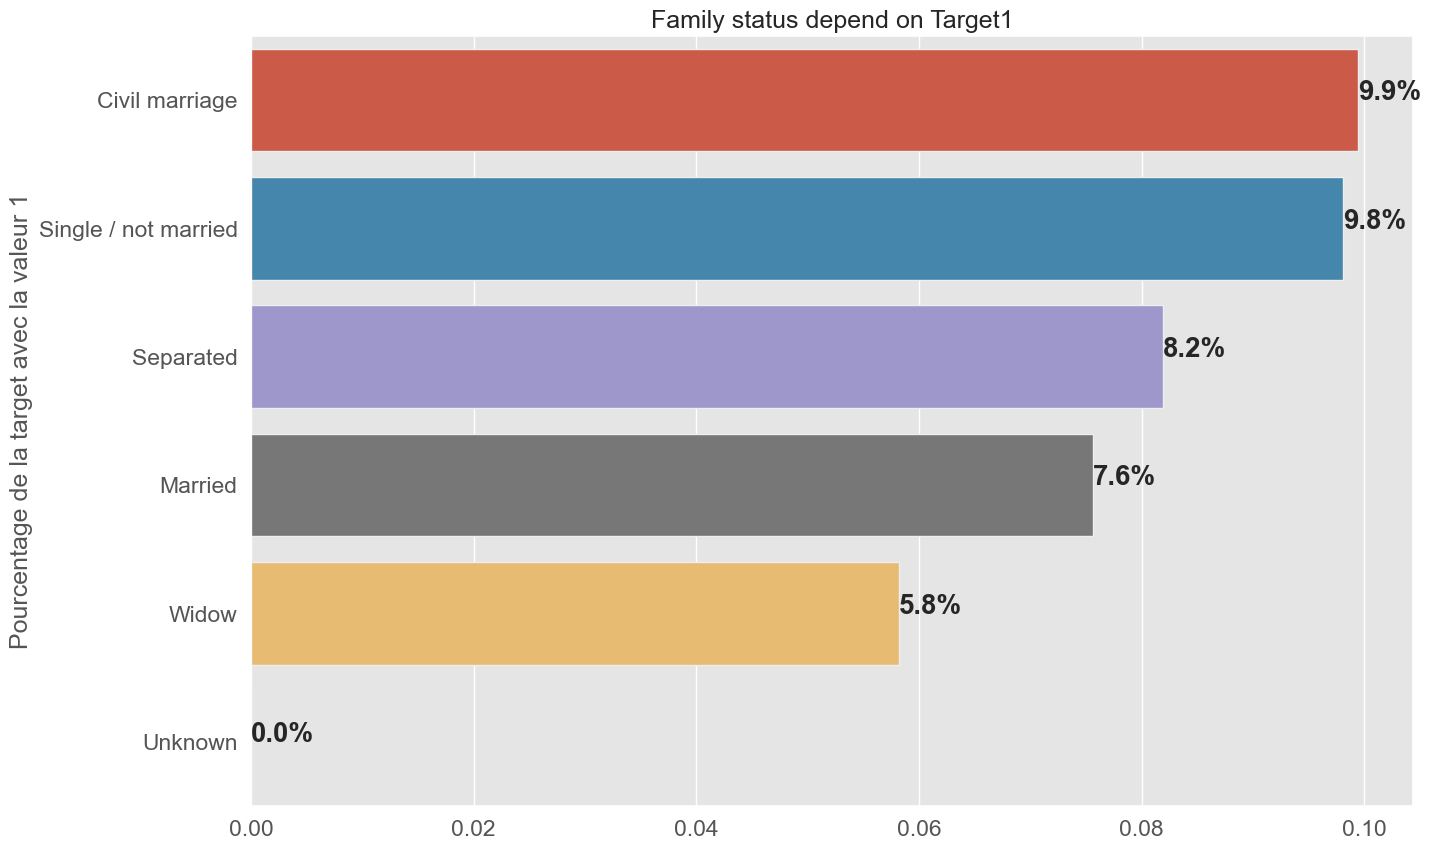

In [100]:
plot_percent_target1(app_train, 'NAME_FAMILY_STATUS',"Family status depend on Target1", (15,10))

Le mariage civil a le pourcentage le plus élevé de non-remboursement

**Income type**
- Distribution du type de revenus

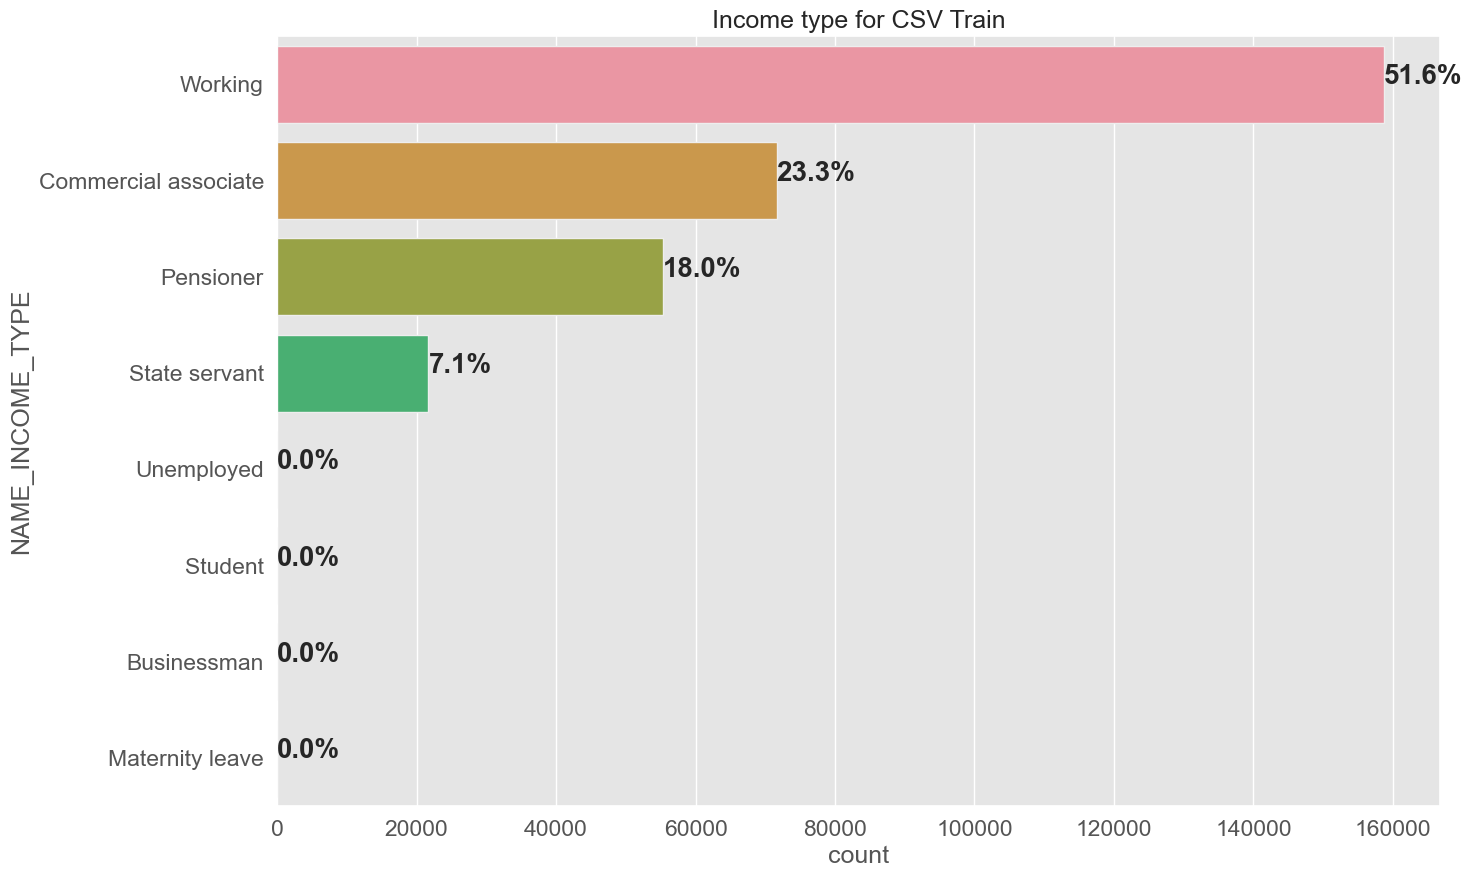

In [101]:
plot_stat(app_train, 'NAME_INCOME_TYPE', 'Income type for CSV Train', (15,10)) 

La très grande majorité des clients ont un emploi. La plupart des clients ont des revenus de type travail, d'associé commercial, de retraite.

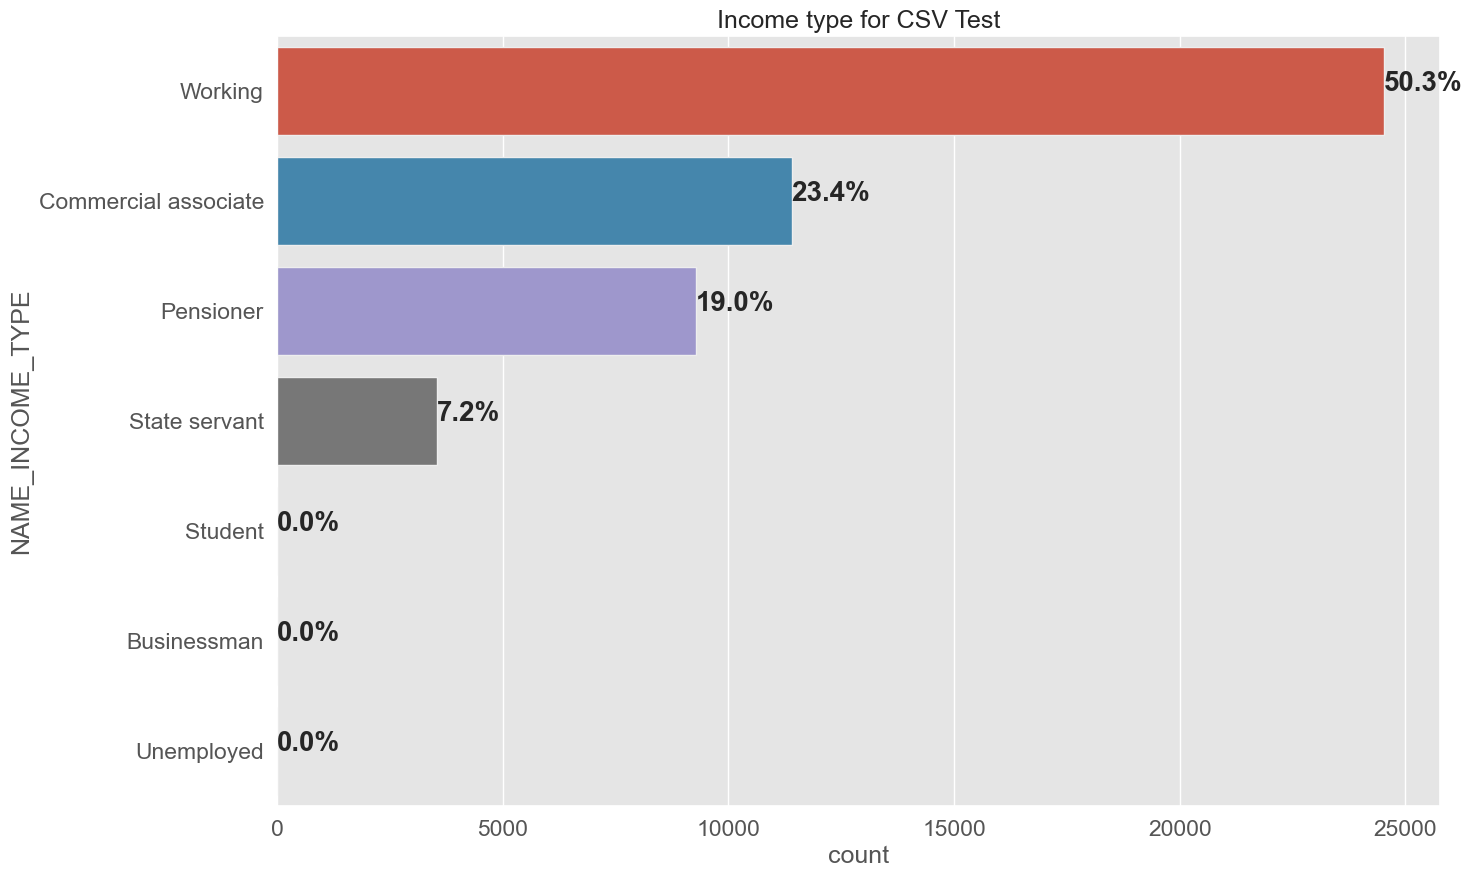

In [102]:
plot_stat(app_test, 'NAME_INCOME_TYPE', 'Income type for CSV Test', (15,10)) 

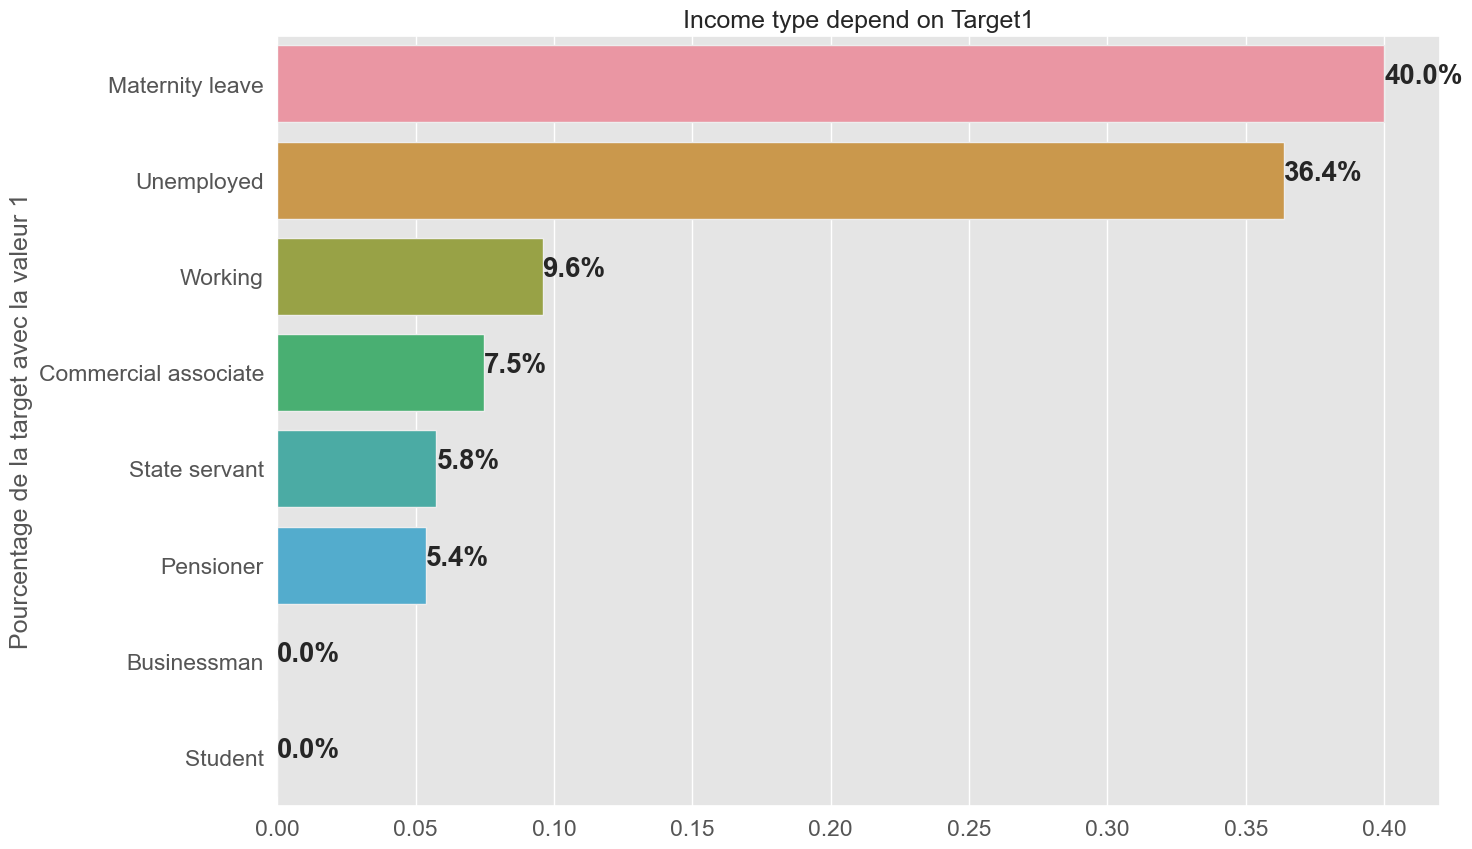

In [103]:
plot_percent_target1(app_train, 'NAME_INCOME_TYPE',"Income type depend on Target1", (15,10))

Les prêts sont non remboursés avec les clients qui ont des revenus de congé maternité et de chômage.

**Type de travail** 
- Distribution du type de travail des clients

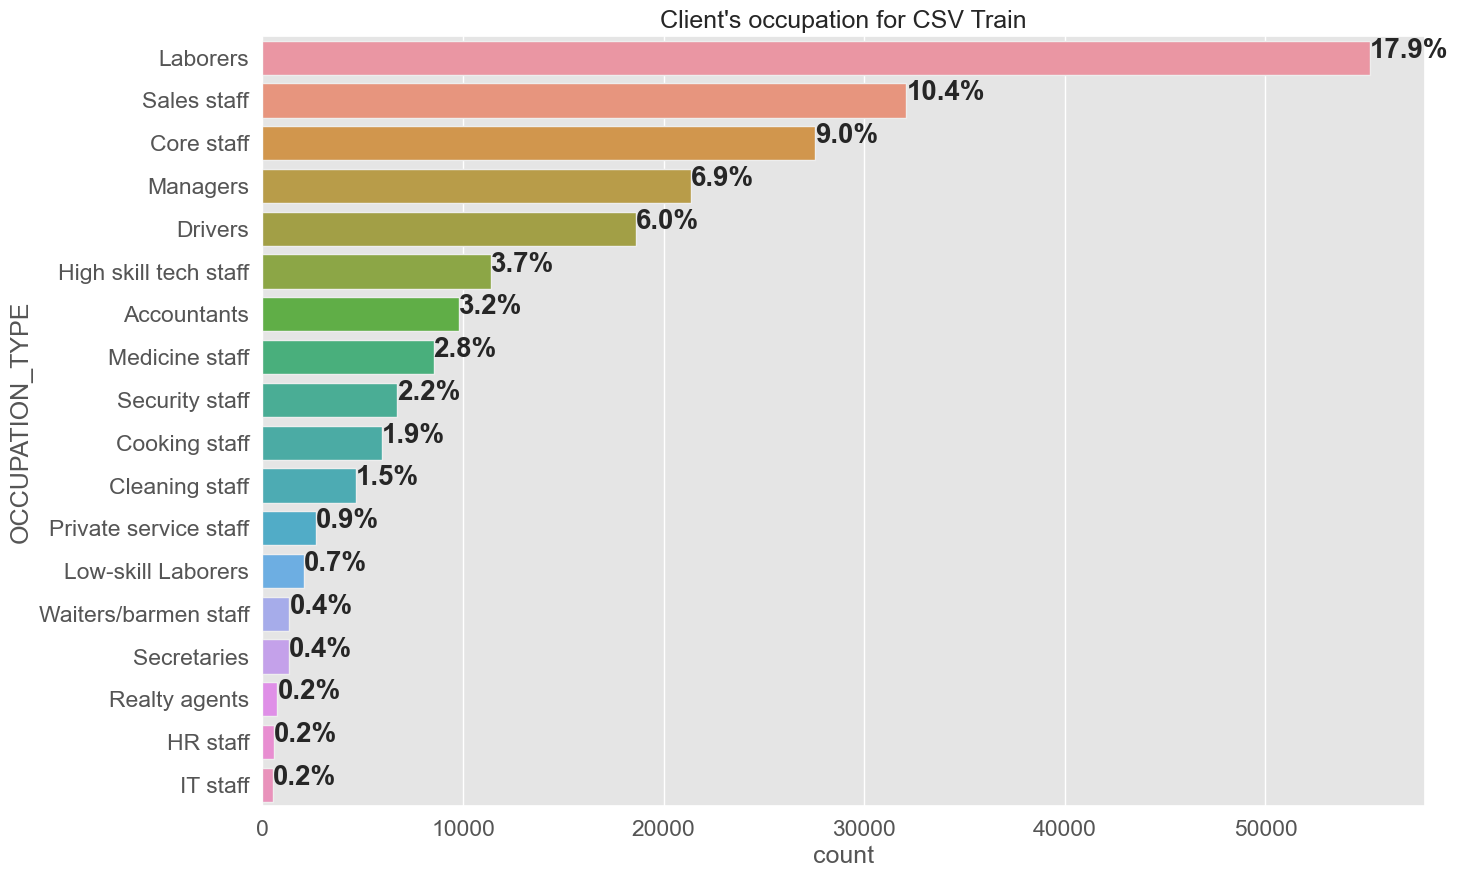

In [104]:
plot_stat(app_train, 'OCCUPATION_TYPE', 'Client\'s occupation for CSV Train', (15,10)) 

La plupart des clients sont des ouvriers.

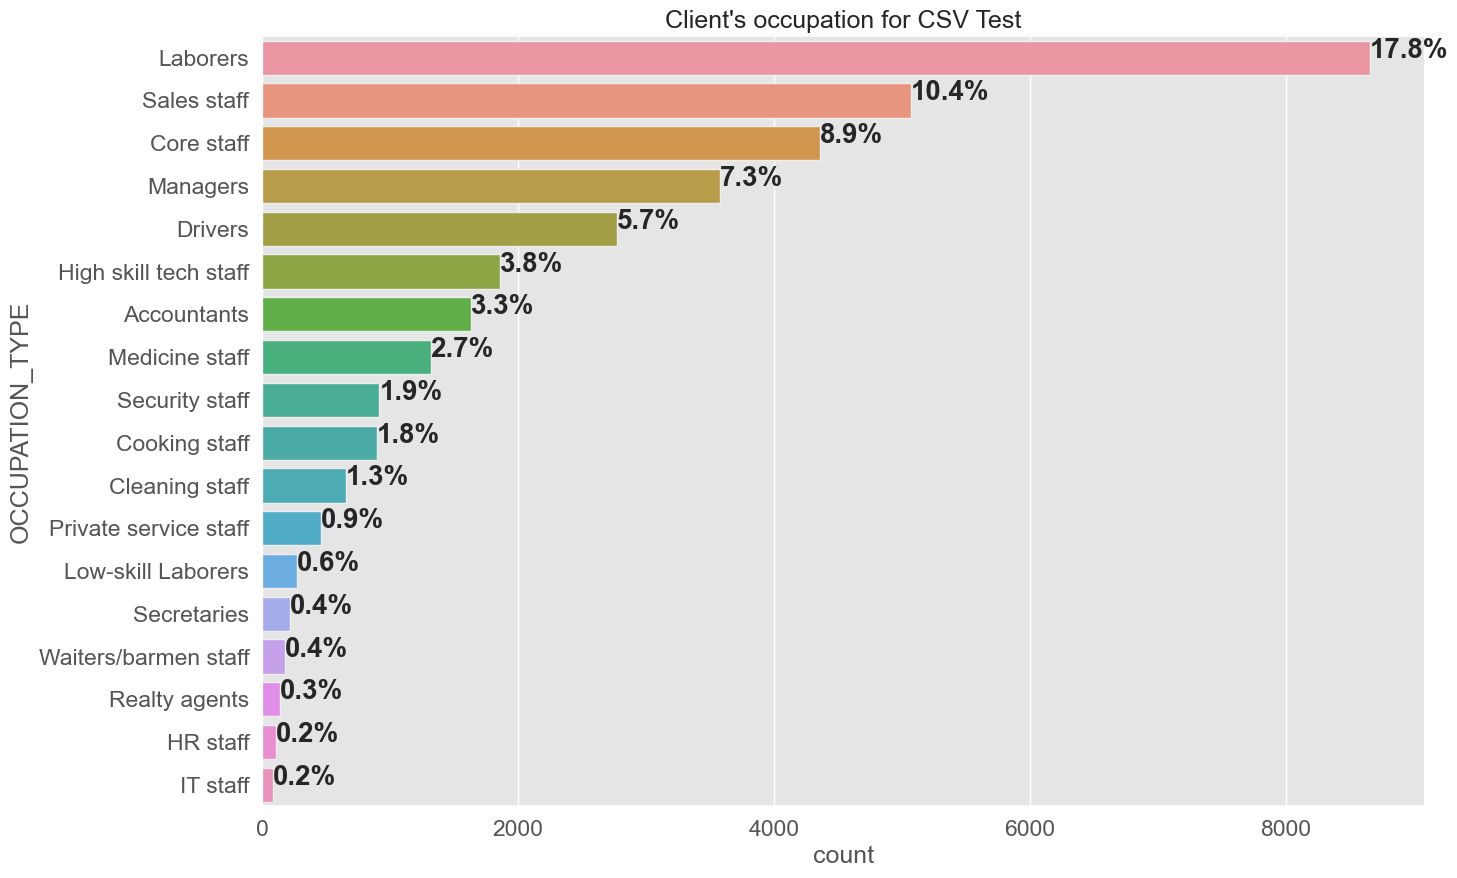

In [105]:
plot_stat(app_test, 'OCCUPATION_TYPE', 'Client\'s occupation for CSV Test', (15,10)) 

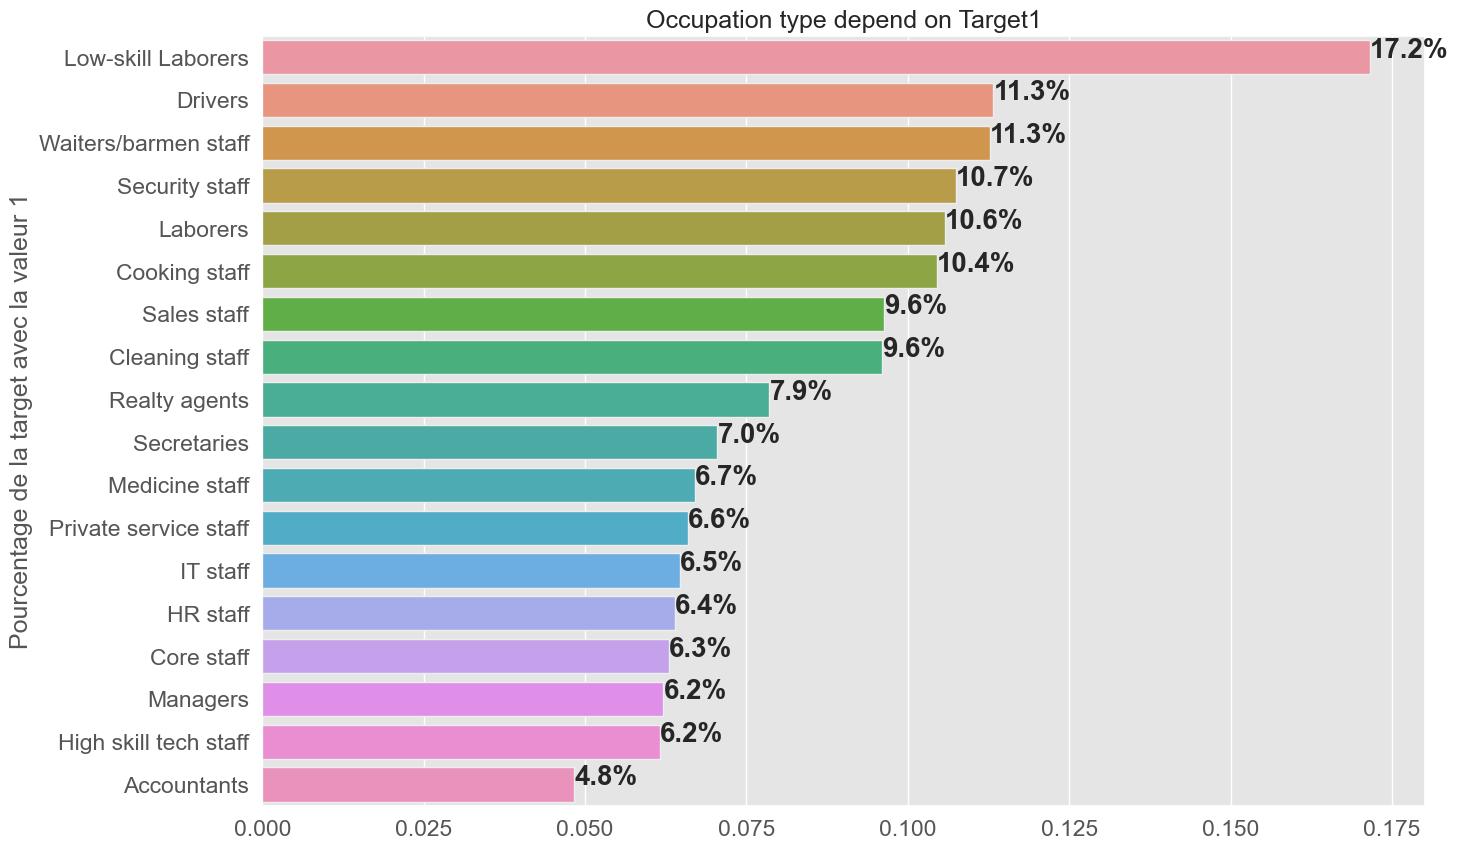

In [106]:
plot_percent_target1(app_train, 'OCCUPATION_TYPE',"Occupation type depend on Target1", (15,10))

Les prêts sont non remboursés avec les clients qui sont des ouviers peu qualifiés.
- Low-skill Laborer : Ouvriers peu qualifiés

In [109]:
app_train["OCCUPATION_TYPE"].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', nan,
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

**Type d'éducation** 
- Distribution du type d'éducation des clients

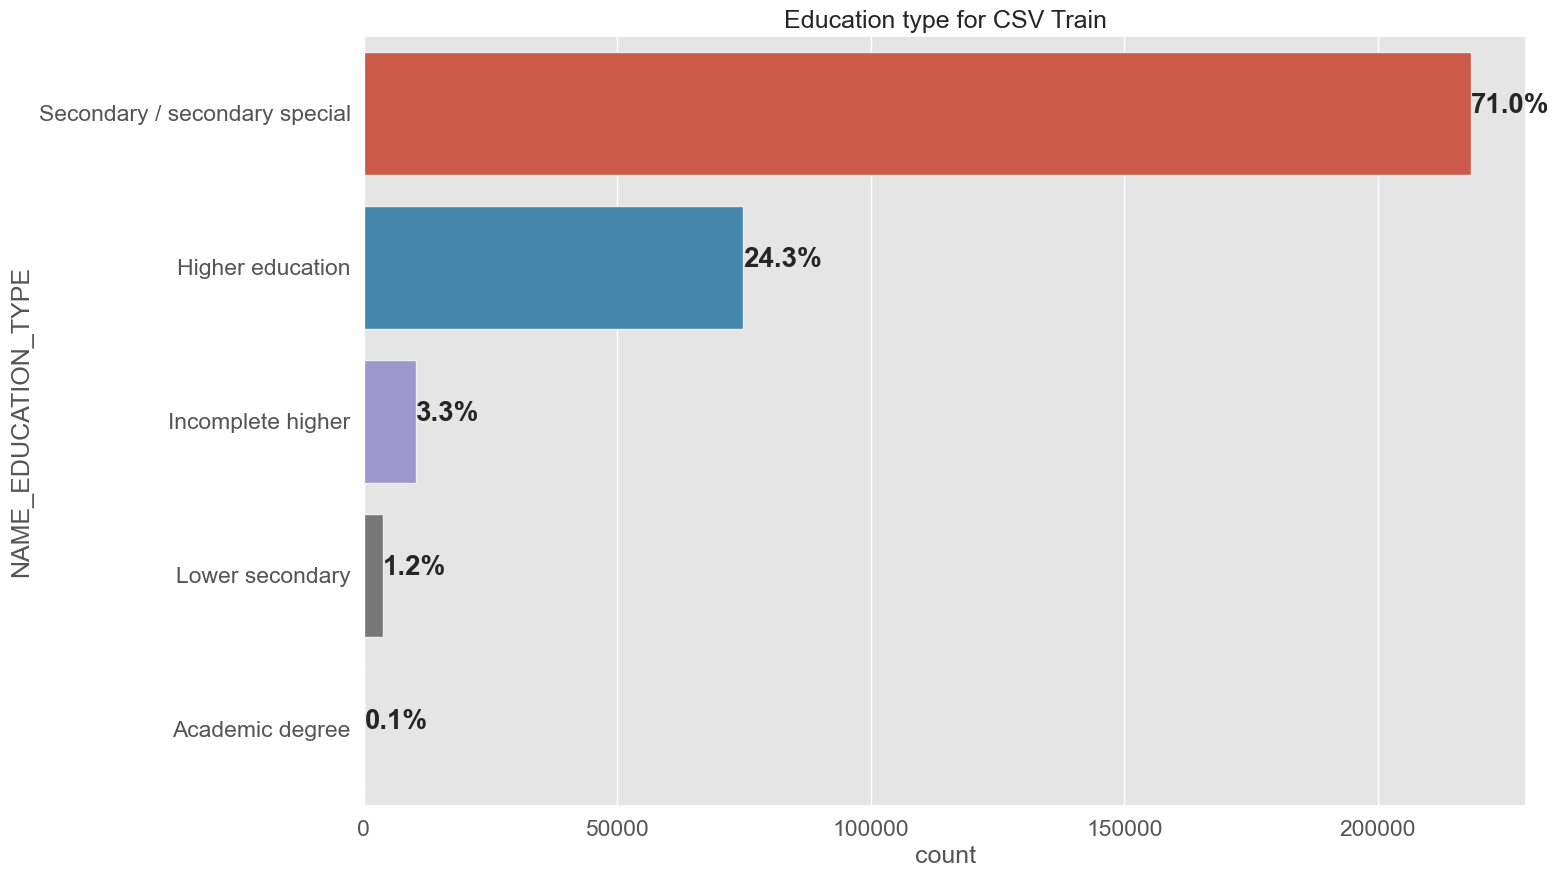

In [110]:
plot_stat(app_train, 'NAME_EDUCATION_TYPE', 'Education type for CSV Train', (15,10)) 

La majorité des clients ont une éducation de niveau secondaire et supérieure.

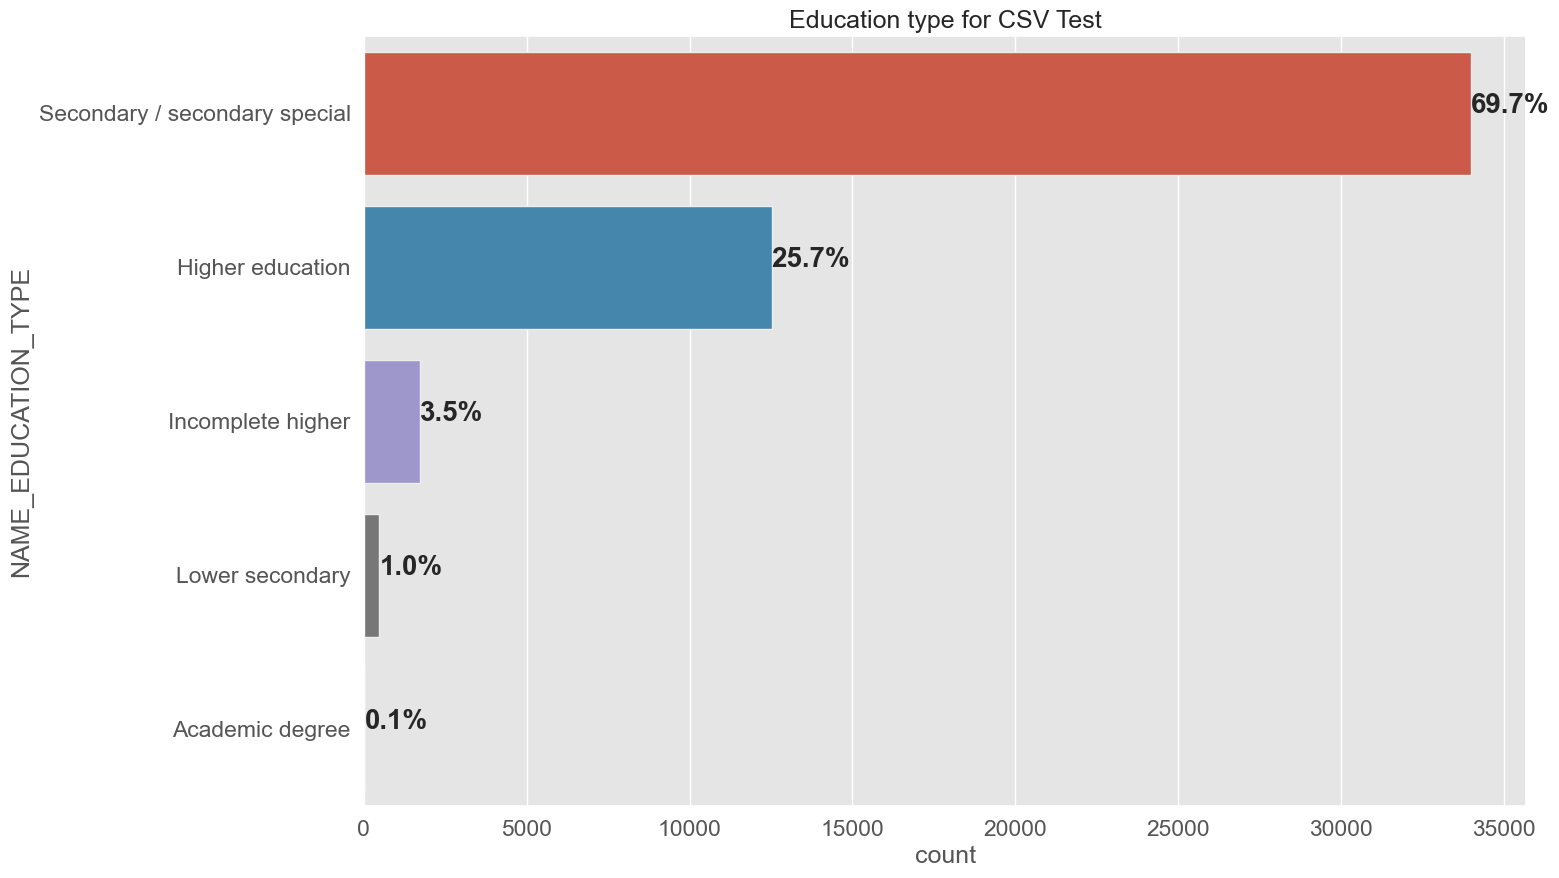

In [112]:
plot_stat(app_test, 'NAME_EDUCATION_TYPE', 'Education type for CSV Test', (15,10)) 

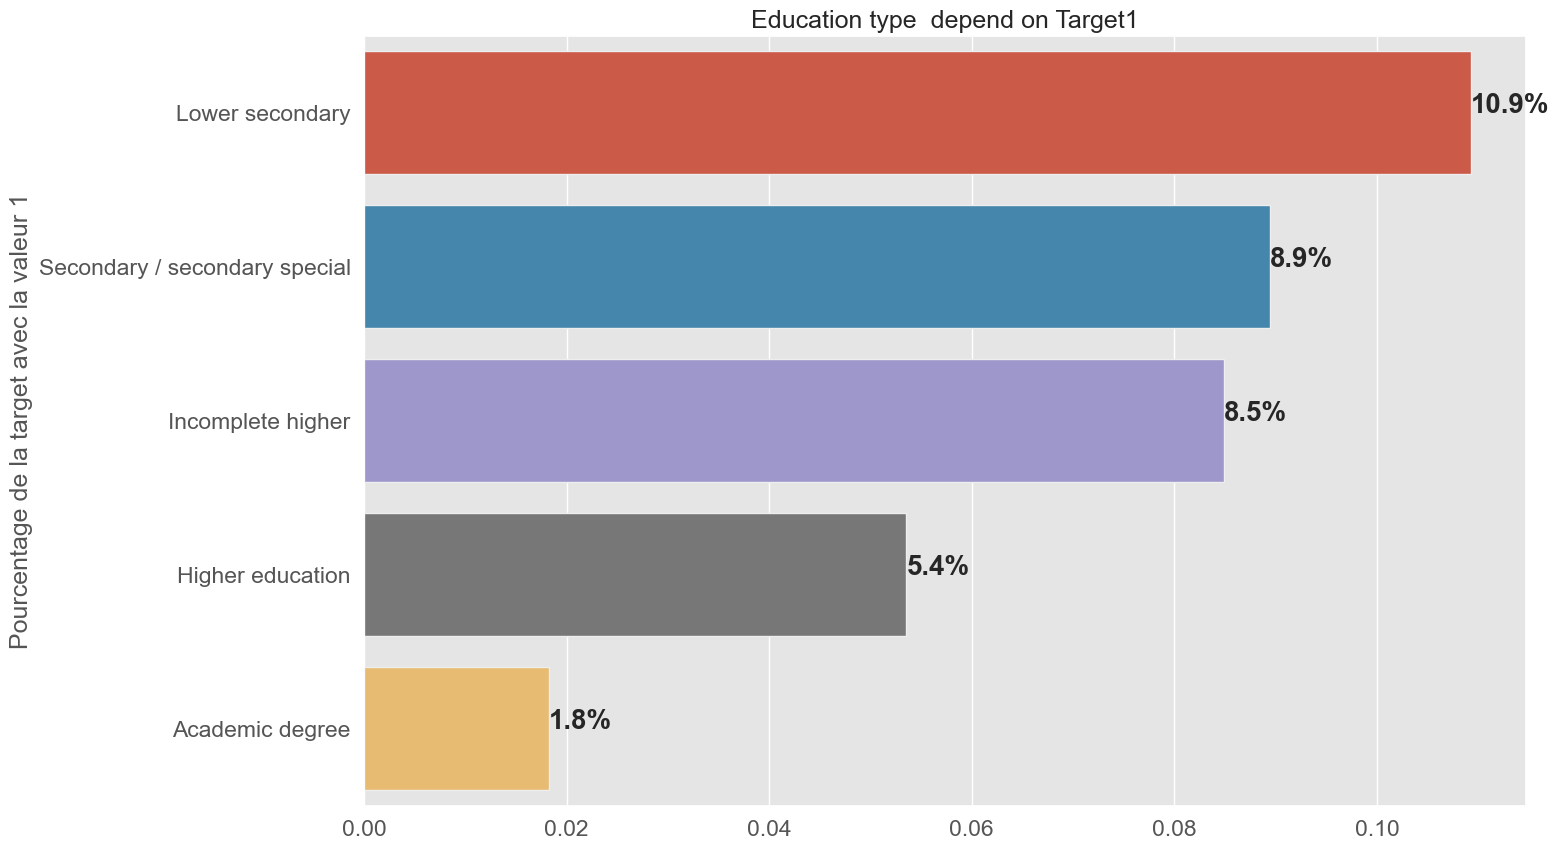

In [113]:
plot_percent_target1(app_train, 'NAME_EDUCATION_TYPE',"Education type  depend on Target1", (15,10))

Les clients ayant un niveau d'éducation de début de secondaire risquent de moins rembourser les prêts que les clients ayant une éducation universitaire.

**Type de logement** 
- Distribution du type de logement des clients

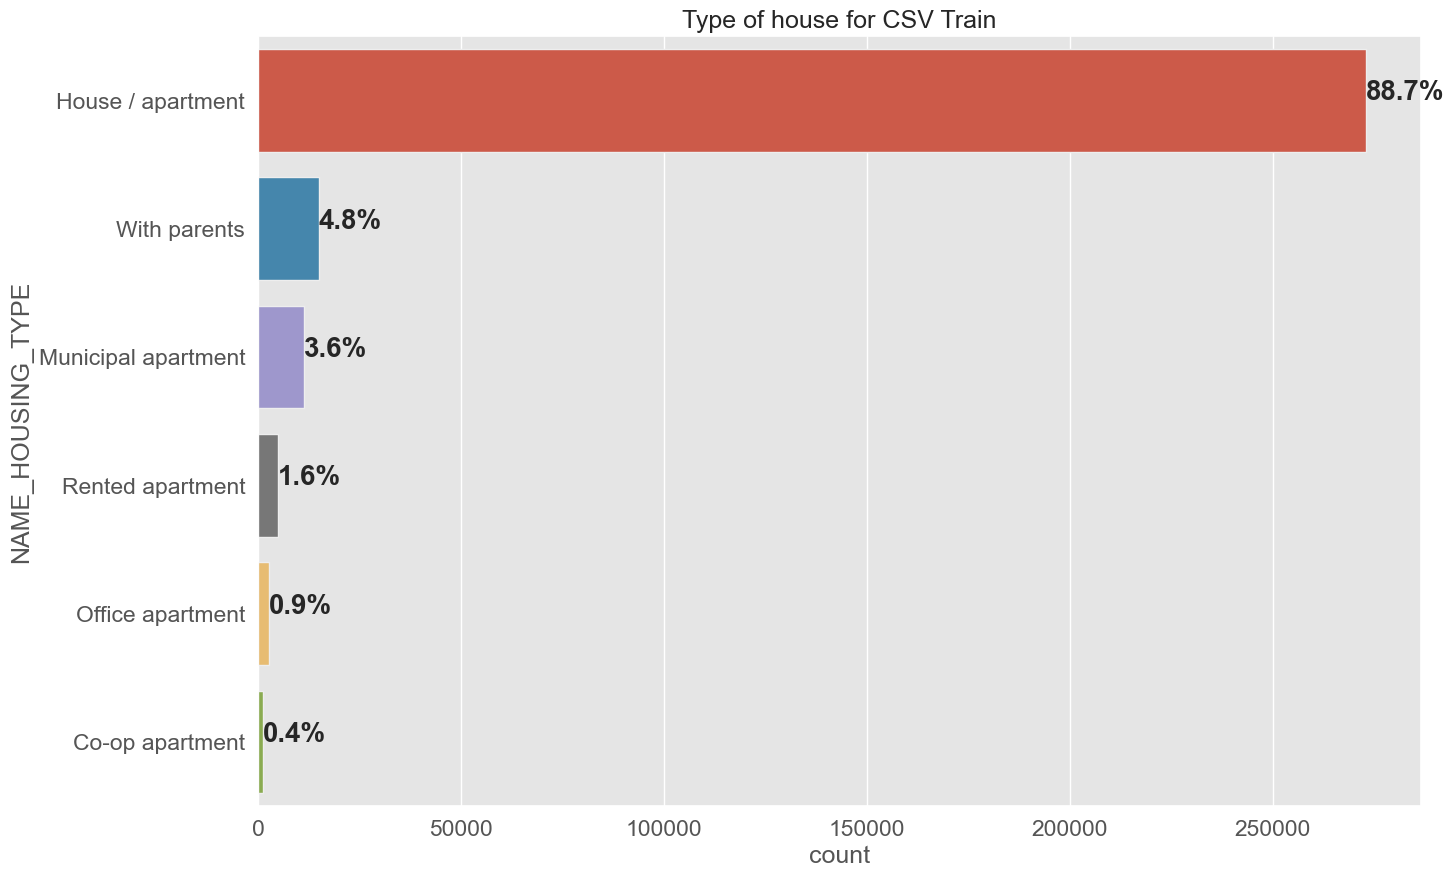

In [114]:
plot_stat(app_train, 'NAME_HOUSING_TYPE', 'Type of house for CSV Train', (15,10)) 

La majorité des clients vivent en maison ou en appartement.

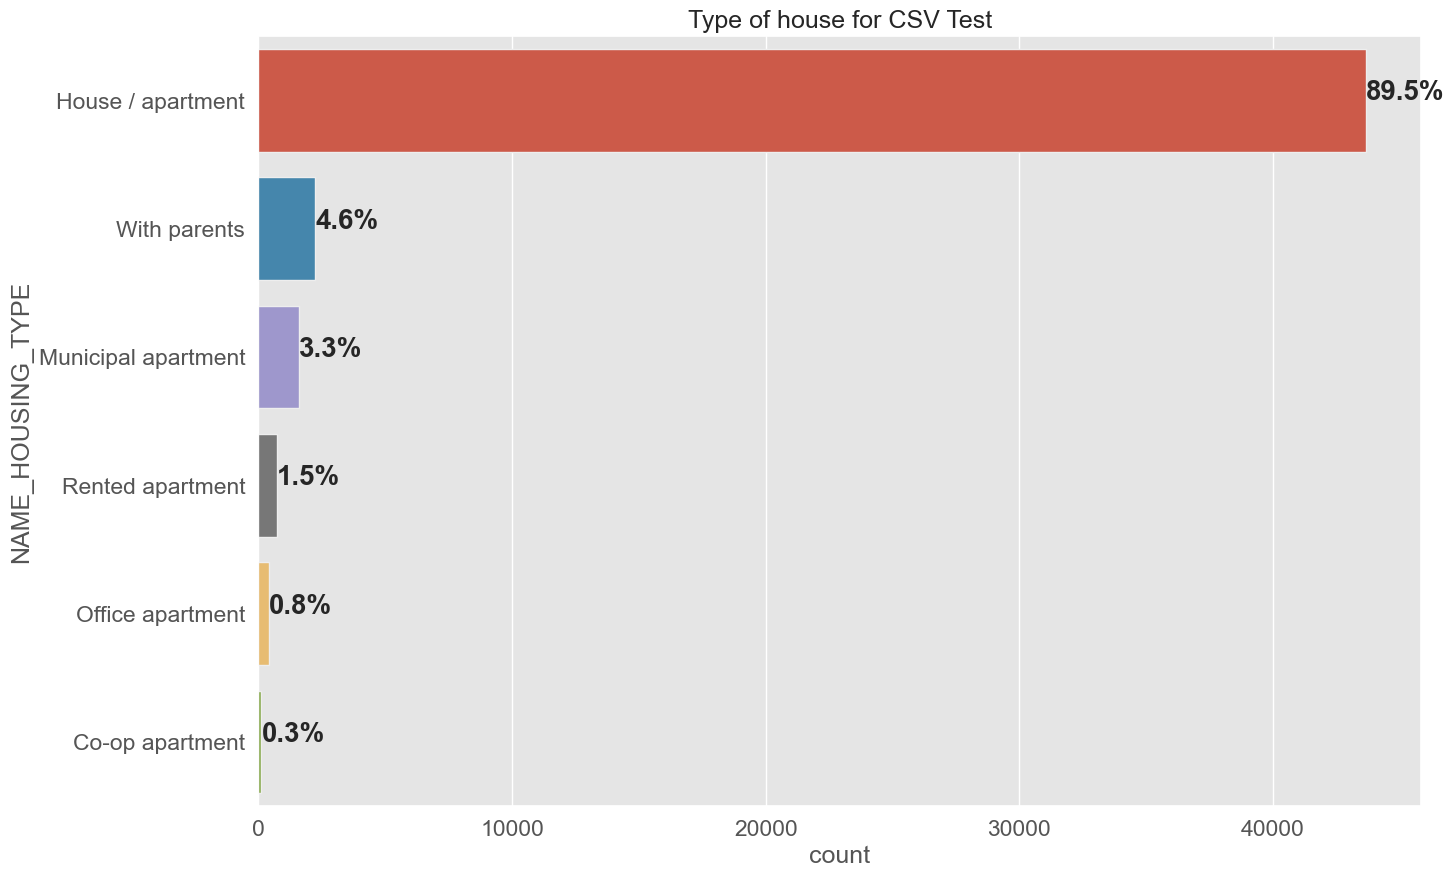

In [115]:
plot_stat(app_test, 'NAME_HOUSING_TYPE', 'Type of house for CSV Test', (15,10)) 

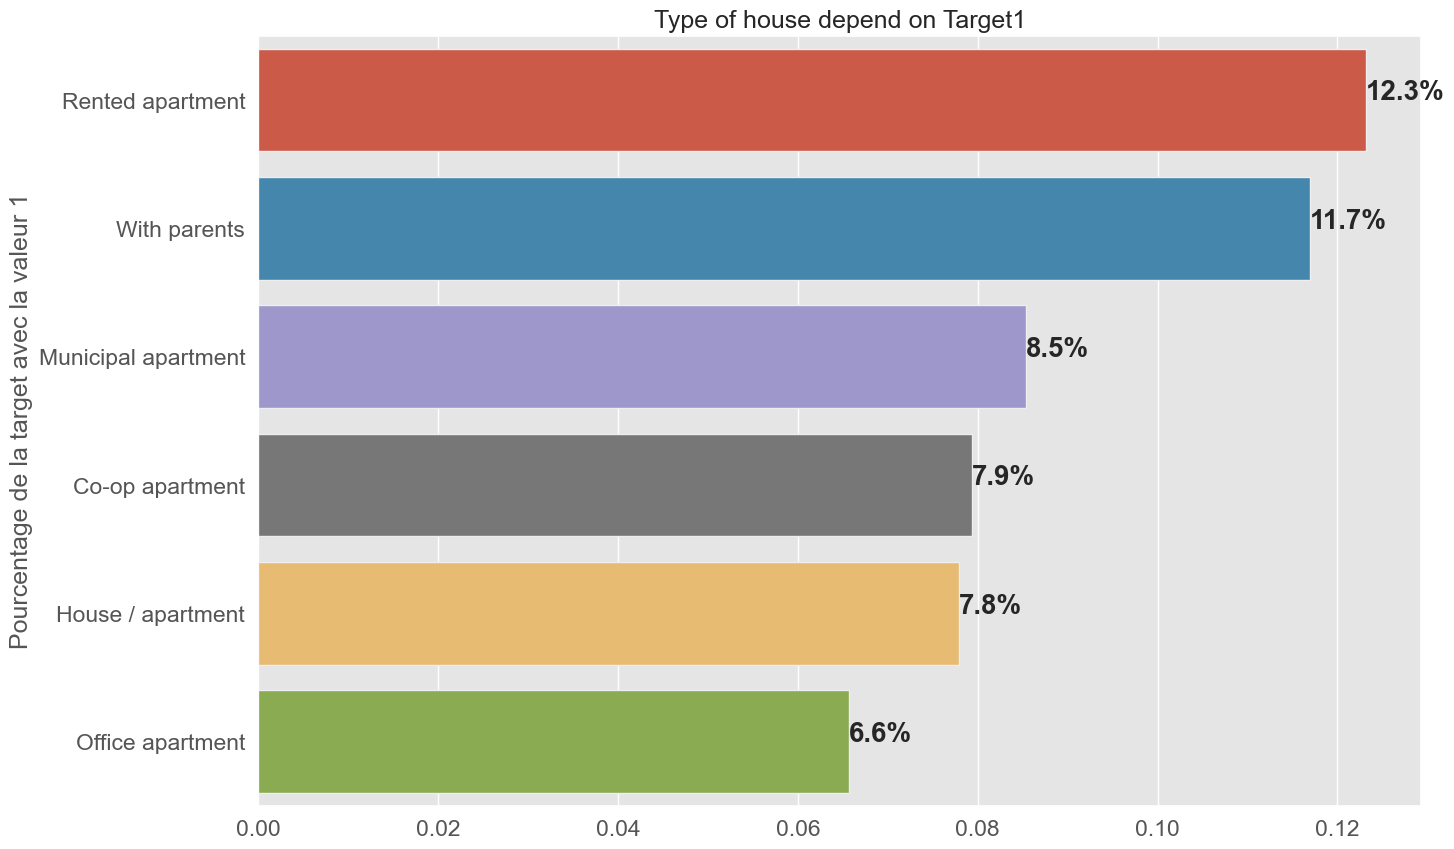

In [116]:
plot_percent_target1(app_train, 'NAME_HOUSING_TYPE',"Type of house depend on Target1", (15,10))

Les clients qui payent un loyer ou qui vivent chez leurs parents ont plus de mal à rembourser un prêt.

**Montant crédit moyen :**

In [118]:
# Créer une nouvelle variable 'target_0' en filtrant les données où la colonne 'TARGET' a la valeur 0
target_0 = app_train.loc[app_train['TARGET'] == 0]

# Calculer la moyenne de la colonne 'AMT_CREDIT' pour les données ayant la cible 0
target_0['AMT_CREDIT'].mean()


602648.2820019386

 montant moyen des crédit est de 602 k€ pour les personnes sachant rembourser le prêt.

In [119]:
# Créer une nouvelle variable 'target_1' en filtrant les données où la colonne 'TARGET' a la valeur 1
target_1 =app_train.loc[app_train['TARGET'] == 1]

# Calculer la moyenne de la colonne 'AMT_CREDIT' pour les données ayant la target 1
target_1['AMT_CREDIT'].mean()

557778.527673716

Le montant moyen des crédit est de 557 k€ pour les personnes ne sachant pas rembourser leurs prêts.

### 4 - Corélation avec la Target

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

- 0,00-0,19 "très faible"
- 0,20 à 0,39 "faible".
- 0,40-0,59 "modéré
- 0,60-0,79 "fort
- 0,80-1,0 "très forte".

Voyons les relations possibles entre les variables et le TARGET en calculant le coefficiant de Pearson.

In [126]:
# Sélectionner les colonnes de type int64 et float64 dans le DataFrame 'app_train'
numeric_columns = app_train.select_dtypes(include=['int64', 'float64'])

# Calculer les corrélations entre 'TARGET' et ces colonnes numériques
correlations = numeric_columns.corr()['TARGET'].sort_values()

# Afficher les 15 corrélations les plus positives (en ordre décroissant)
print('Corrélations les plus positives:\n', correlations.tail(15))

# Afficher les 15 corrélations les plus négatives (en ordre croissant)
print('\nCorrélations les plus négatives:\n', correlations.head(15))


Corrélations les plus positives:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Corrélations les plus négatives:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   

TARGET a la plus forte corrélation positive avec 'DAYS_BIRTH'.

In [127]:
# Transformer les jours de naissance en valeurs positives en utilisant la fonction 'abs()'
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

# Calculer la corrélation entre l'âge (jours de naissance transformés en valeurs positives) et la variable cible 'TARGET'
correlation_age_target = app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

# Afficher le coefficient de corrélation
print("Corrélation entre AGE et TARGET :", correlation_age_target)


Corrélation entre AGE et TARGET : -0.07823930830982709


Au fur et à mesure que le client vieillit, il existe une relation linéaire négative avec l'objectif, ce qui signifie que plus les clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais.

On trouve une corrélation négative, entre la taget et l'âge des clients. Plus le client est âgé moins la probabilité de défaut de paiement est haute.


**Effet de l'âge sur la TARGET**

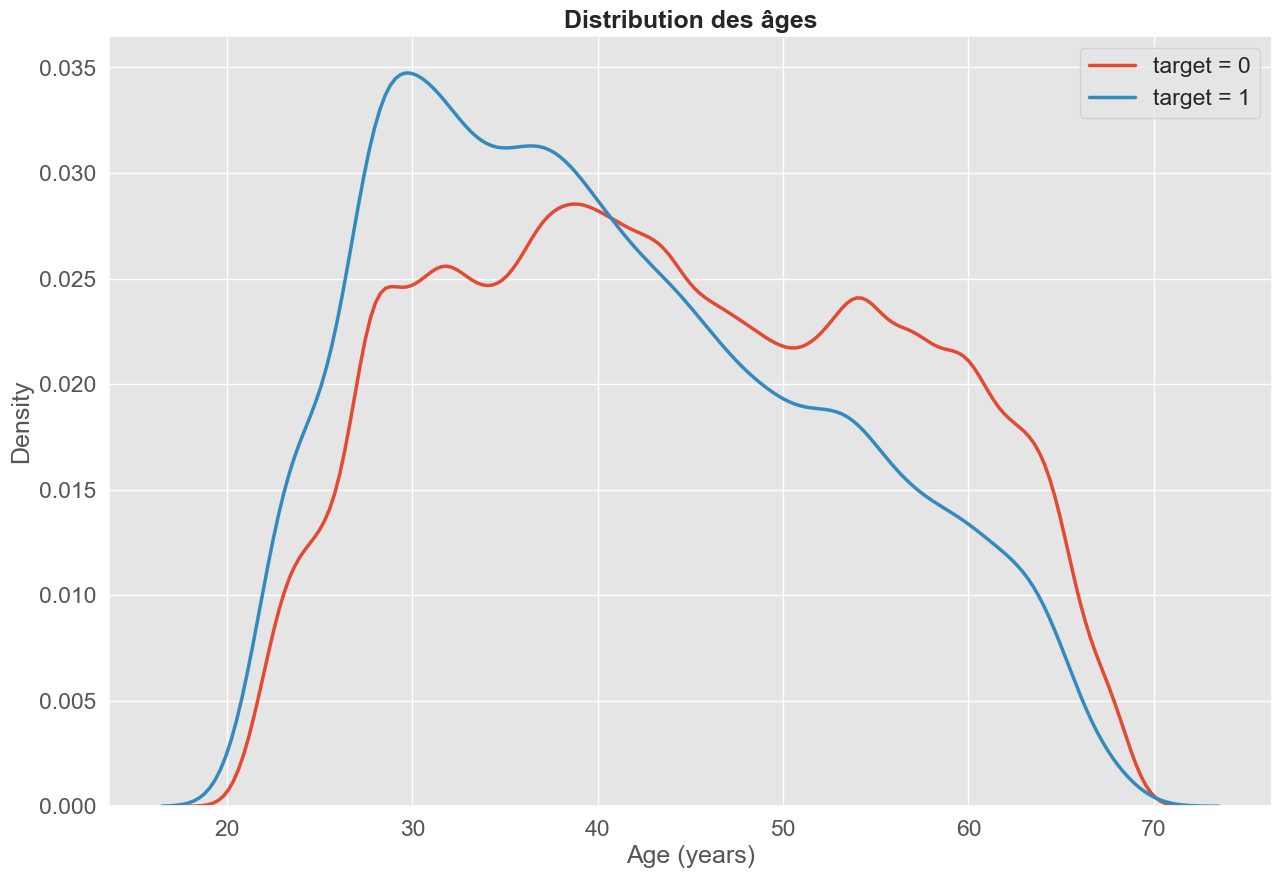

In [128]:
# Créer une figure 
plt.figure(figsize=(15, 10))

# Tracer la distribution de densité (KDE) pour les clients avec target=0 (Non défaut)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='target = 0')

# Tracer la distribution de densité (KDE) pour les clients avec target=1 (Défaut)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='target = 1')

# Étiquettes pour les axes x et y du graphique
plt.xlabel('Age (years)')
plt.ylabel('Density')

# Titre du graphique
plt.title('Distribution des âges', weight='bold', size=18)

# Légende pour distinguer les deux distributions
plt.legend()

# Afficher le graphique
plt.show()


La courbe de la TARGET == 1 penche vers l'extrémité la plus jeune de la fourchette, ce qui signifierai que les personnes jeunes ont plus de mal à rembourser.  Cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. 

**ratio de prêts non remboursés dans chaque tranche d'âge (par 5 ans)**

In [130]:
# Sélectionner les colonnes 'TARGET' et 'DAYS_BIRTH' à partir du DataFrame app_train
age_data = app_train[['TARGET', 'DAYS_BIRTH']]

# Convertir les jours de naissance en années en divisant par 365
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Découper les valeurs de 'YEARS_BIRTH' en 10 tranches d'âge égales allant de 20 à 70 ans
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))

# Regrouper les données par la variable 'YEARS_BINNED' et calculer la moyenne pour chaque groupe
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

Pour chaque tranche d'âge de 5 ans, nous avons la moyenne de TARGET (c'est à dire la moyenne de 1 (défaut de paiement) recensée pour chaque tranche d'âge), l'année moyenne de naissance par goupe.

Nous découpons d'abord la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque bac, nous calculons la valeur moyenne de la cible, ce qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

échec moyen du remboursement des prêts par tranche d'âge.

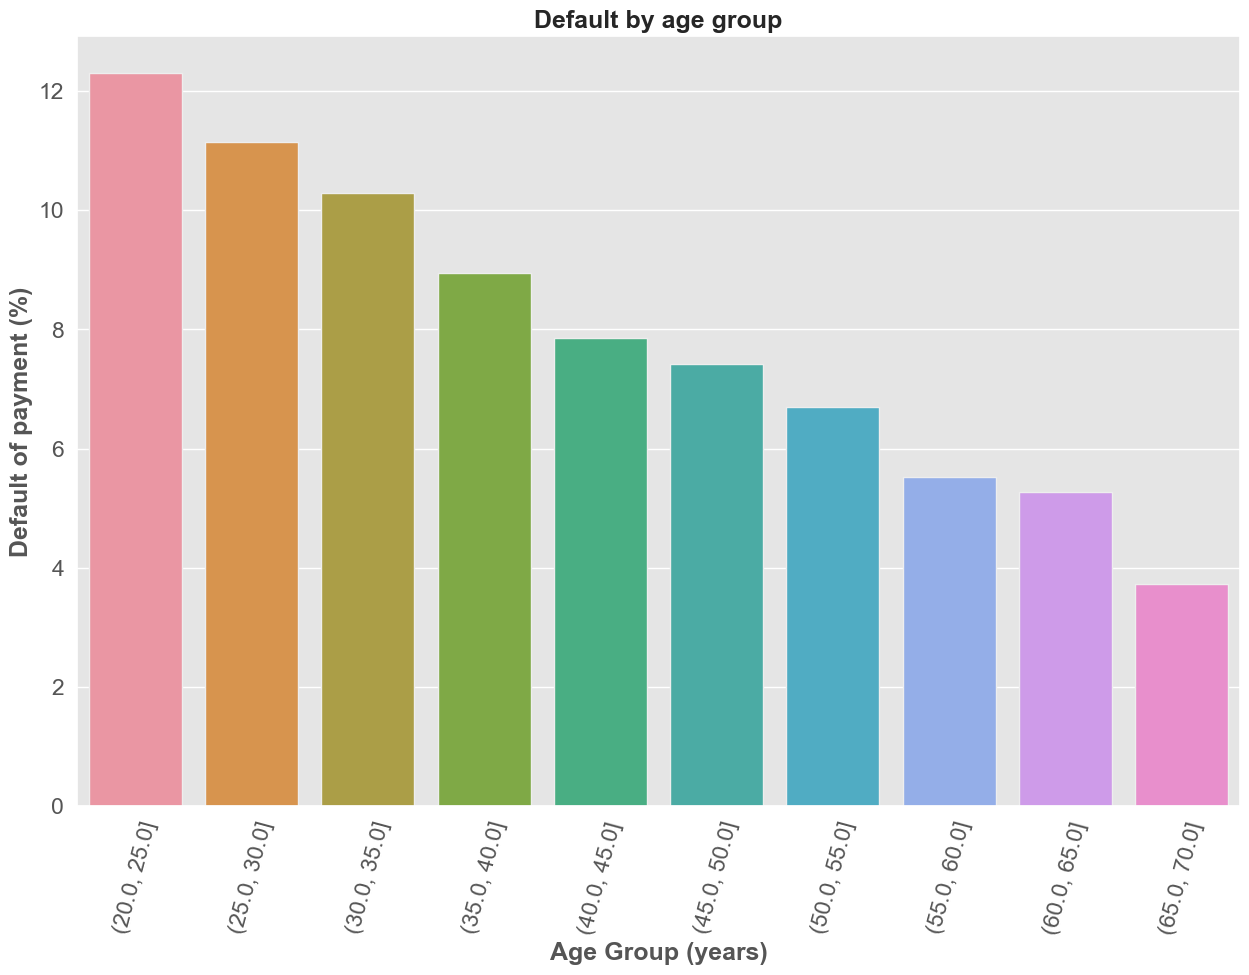

In [133]:
plt.figure(figsize=(15, 10))

sns.barplot(x=age_groups.index.astype(str), y=100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation=75) 
plt.xlabel('Age Group (years)', weight='bold') 
plt.ylabel('Default of payment (%)', weight='bold')
plt.title("Default by age group", weight='bold', size=18)

plt.show()


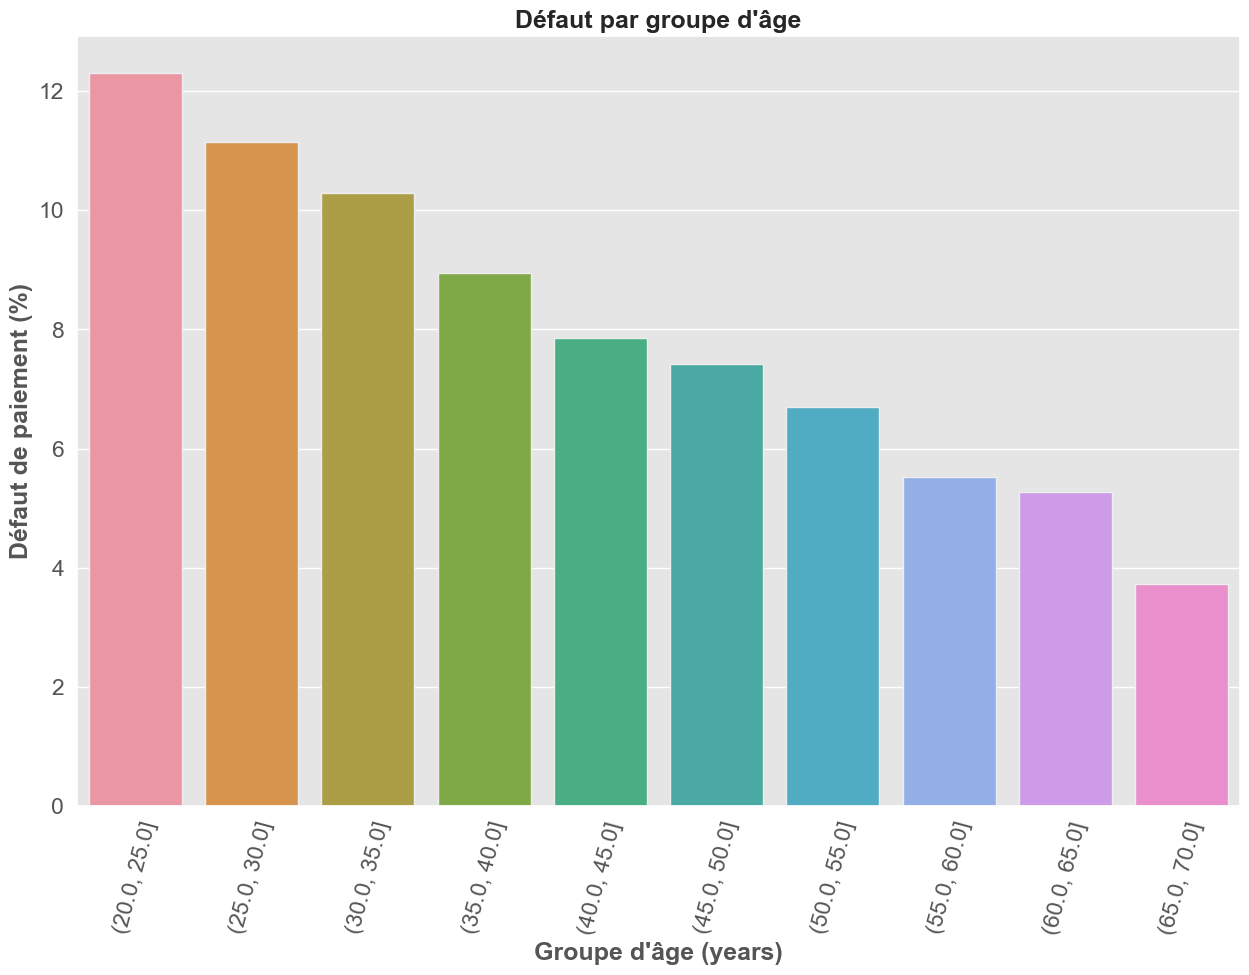

In [135]:
# Créer une figure 
plt.figure(figsize=(15, 10))

# Utiliser la fonction barplot de Seaborn pour afficher le graphique à barres
# Les valeurs sur l'axe des x sont les index du DataFrame age_groups convertis en chaînes de caractères (représentant les tranches d'âge)
# Les valeurs sur l'axe des y représentent la proportion de défauts de paiement dans chaque groupe d'âge
sns.barplot(x=age_groups.index.astype(str), y=100 * age_groups['TARGET'])

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=75)

# Libellés des axes x et y avec des titres en gras
plt.xlabel("Groupe d'âge (years)", weight='bold')
plt.ylabel("Défaut de paiement (%)", weight='bold')

# Titre du graphique en gras avec une taille de police de 18
plt.title("Défaut par groupe d'âge", weight='bold', size=18)

# Affichage du graphique
plt.show()


Les clients les plus jeunes sont plus susceptibles à ne pas rembourser le prêt. 

**Sources extérieures, les plus fortes corrélations linéaires négatives …**

Ces 3 variables (EXT_SOURCE) présentant les corrélations négatives les plus fortes avec la Target. Selon la documentation, ces fonctionnalités représentent un «score normalisé à partir d'une source de données externes». Difficile de comprendre le sens exact, nous pouvons émettre l'hypothèse d'une côte de crédit cumulative établie à l'aide de différentes sources de données.

In [137]:
# Sélection des colonnes d'intérêt dans le DataFrame app_train.
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Calcul de la matrice de corrélation entre les variables sélectionnées.
ext_data_corrs = ext_data.corr()

# Affichage de la matrice de corrélation.
ext_data_corrs


TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

Text(0.5, 1.0, 'Correlation Heatmap')

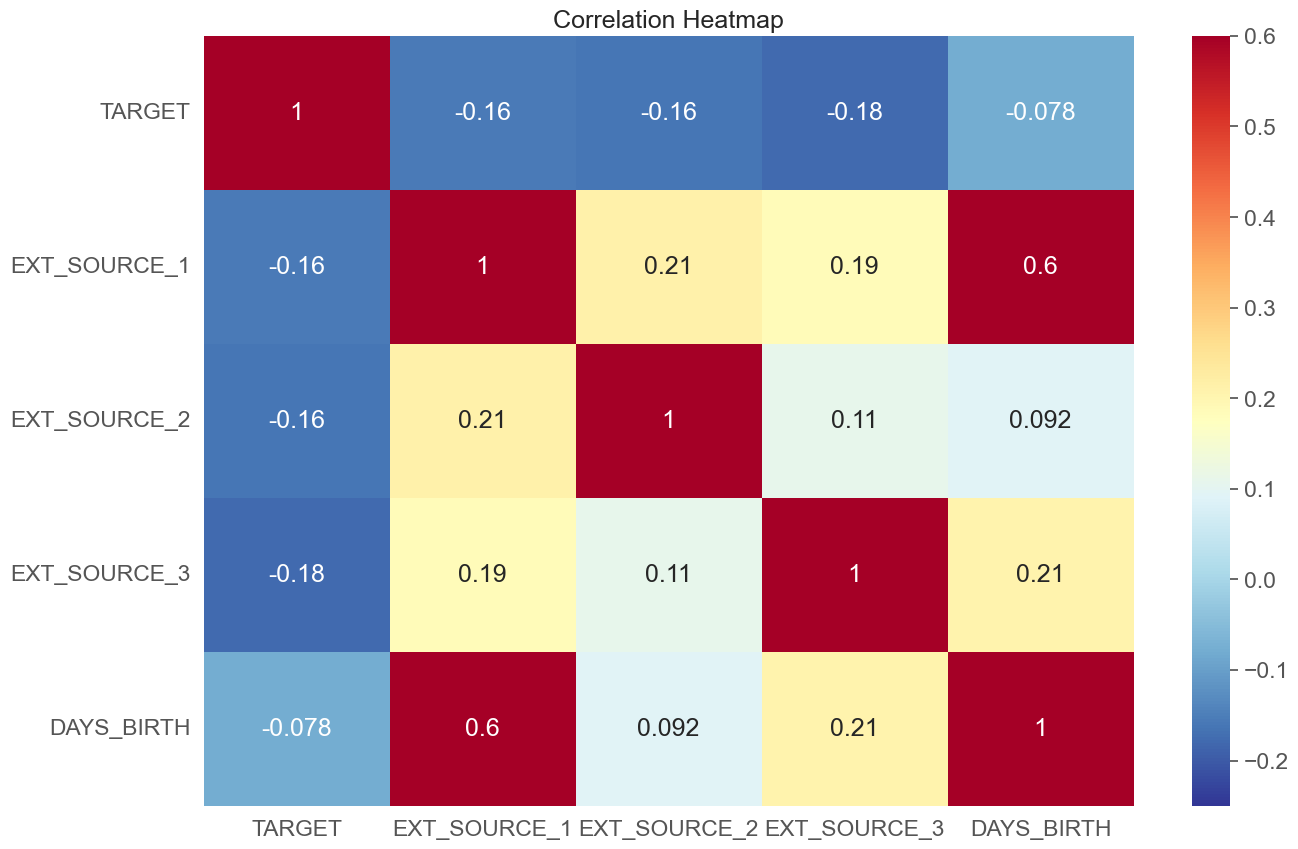

In [138]:
# Création d'une figure 
plt.figure(figsize=(15, 10))

# Tracé de la carte thermique des corrélations avec la palette de couleurs 'RdYlBu_r'.
# 'vmin' et 'vmax' sont utilisés pour définir les valeurs minimales et maximales de la palette de couleurs.
# 'annot=True' affiche les valeurs de corrélation sur la carte thermique.
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)

# Ajout d'un titre à la carte thermique.
plt.title('Correlation Heatmap')


Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec les EXT_SOURCE, ce qui indique que l'un des facteurs de ces scores est peut-être l'âge du client.

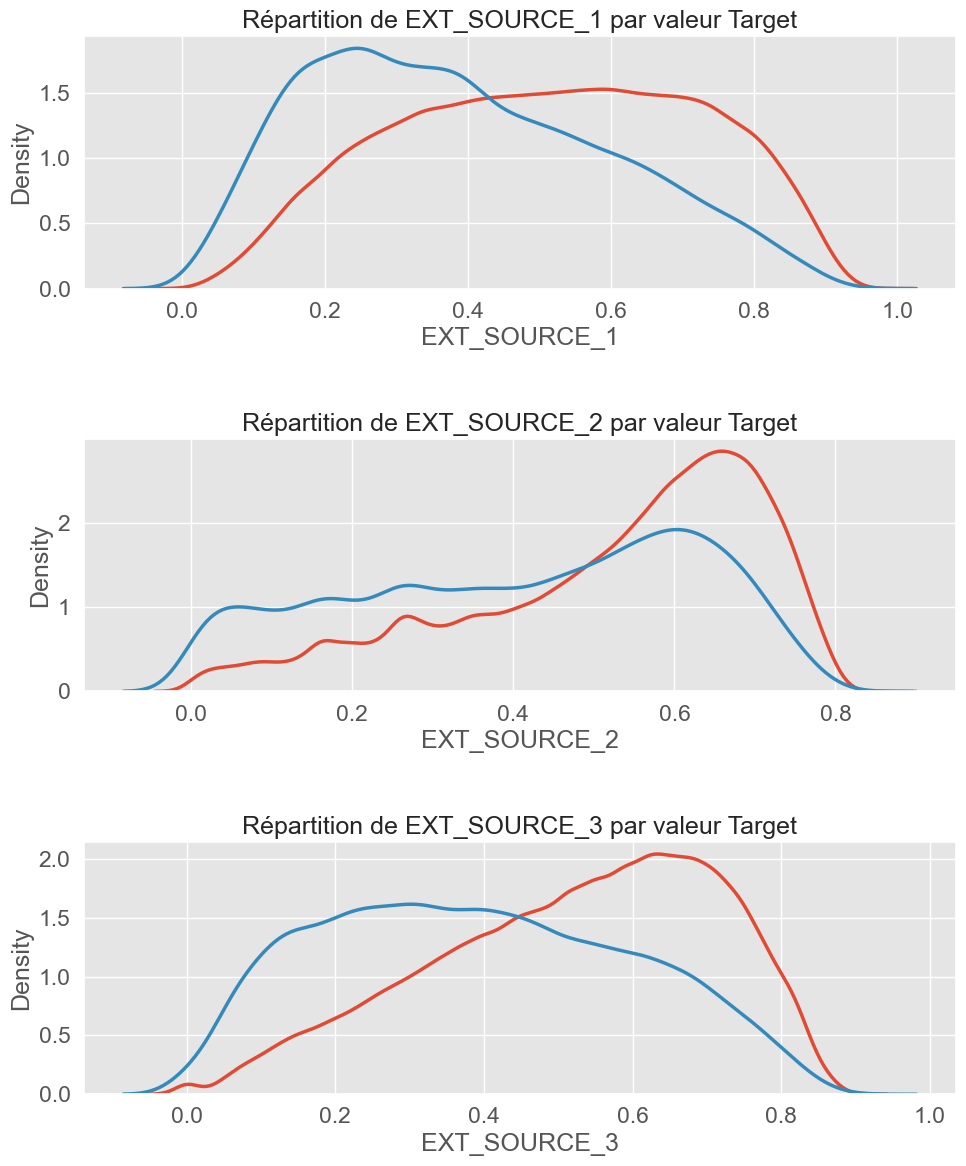

In [139]:
# Création d'une figure 
plt.figure(figsize=(10, 12))

# Boucle pour créer les trois sous-graphiques pour chaque source d'information (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3)
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Création du sous-graphique i+1 dans une disposition de 3 lignes et 1 colonne.
    plt.subplot(3, 1, i + 1)

    # Tracé de la distribution KDE pour les valeurs de la variable source lorsque 'TARGET' est égal à 0.
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='target == 0')

    # Tracé de la distribution KDE pour les valeurs de la variable source lorsque 'TARGET' est égal à 1.
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='target == 1')
    
    # Ajout d'un titre au sous-graphique indiquant la variable étudiée.
    plt.title('Répartition de %s par valeur Target' % source)
    
    # Ajout d'une étiquette pour l'axe des abscisses indiquant le nom de la variable source.
    plt.xlabel('%s' % source)
    
    # Ajout d'une étiquette pour l'axe des ordonnées indiquant 'Density' (densité).
    plt.ylabel('Density')

# Ajustement des espacements verticaux entre les sous-graphiques pour une meilleure lisibilité.
plt.tight_layout(h_pad=2.5)


EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles), mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt à temps.

In [141]:
def plot_distribution(dataframe, feature, title, size):
    # Création d'une figure de taille 'size'.
    plt.figure(figsize=size)

    # Extraction des données pour les deux groupes de cibles : 'TARGET = 0' et 'TARGET = 1'.
    t0 = dataframe.loc[dataframe['TARGET'] == 0]
    t1 = dataframe.loc[dataframe['TARGET'] == 1]

    # Tracé de la distribution KDE pour 'TARGET = 0' en utilisant la variable 'feature'.
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    
    # Tracé de la distribution KDE pour 'TARGET = 1' en utilisant la variable 'feature'.
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    
    # Ajout d'un titre pour le graphique.
    plt.title(title)
    
    # Suppression de l'étiquette pour l'axe des ordonnées (y-axis) pour éviter la surcharge d'informations.
    plt.ylabel('')
    
    # Ajout d'une légende pour distinguer les deux groupes de cibles dans le graphique.
    plt.legend()
    
    # Affichage du graphique.
    plt.show()


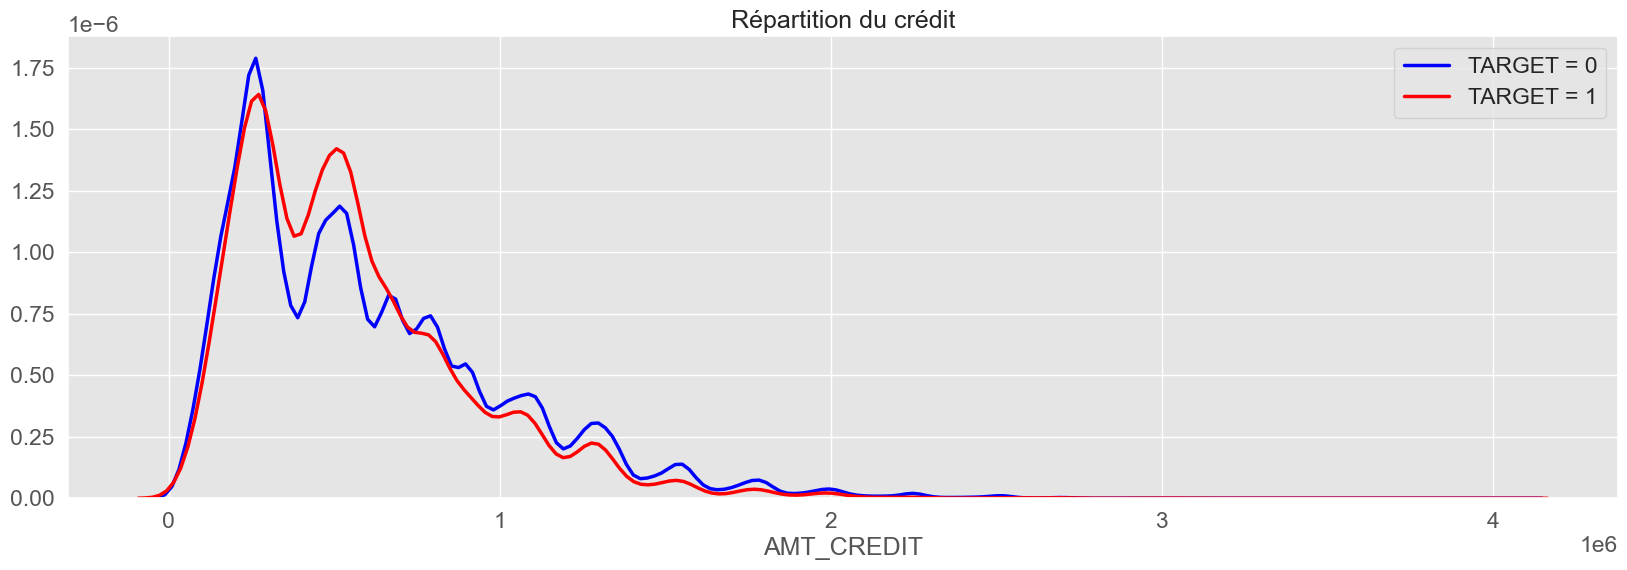

                                   -------------------------------------------------------


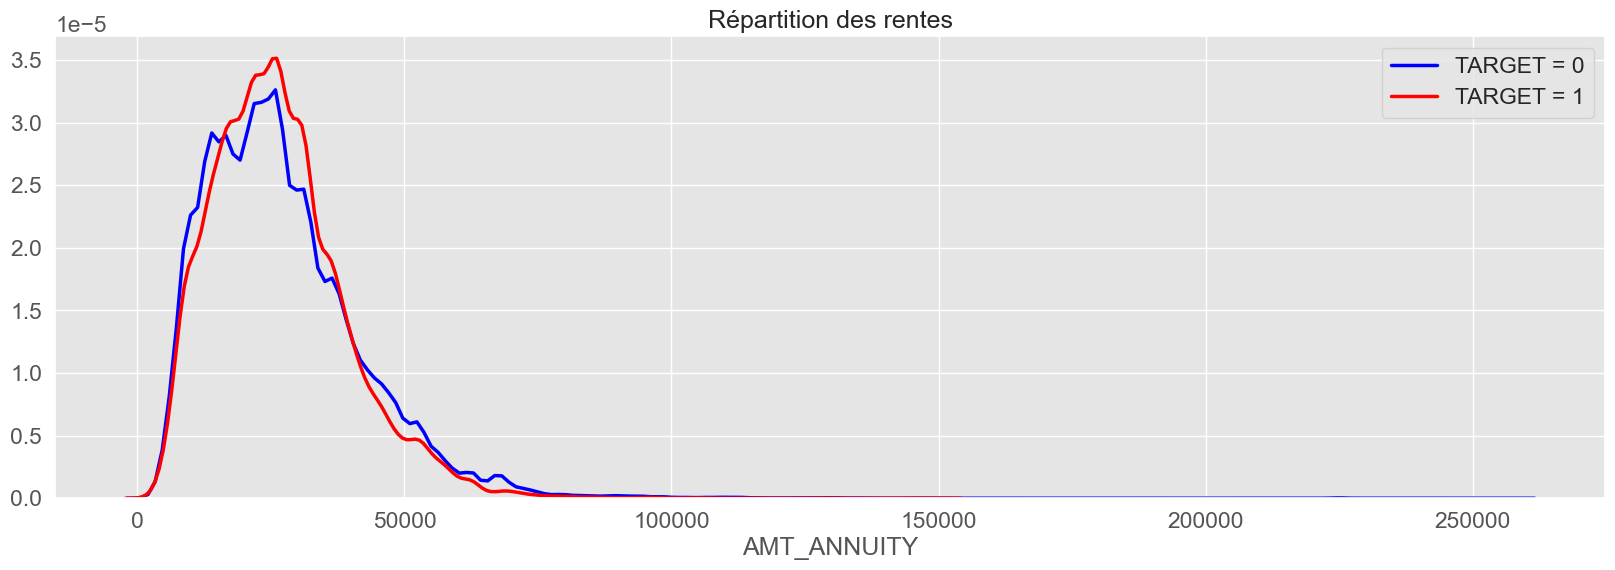

                                   -------------------------------------------------------


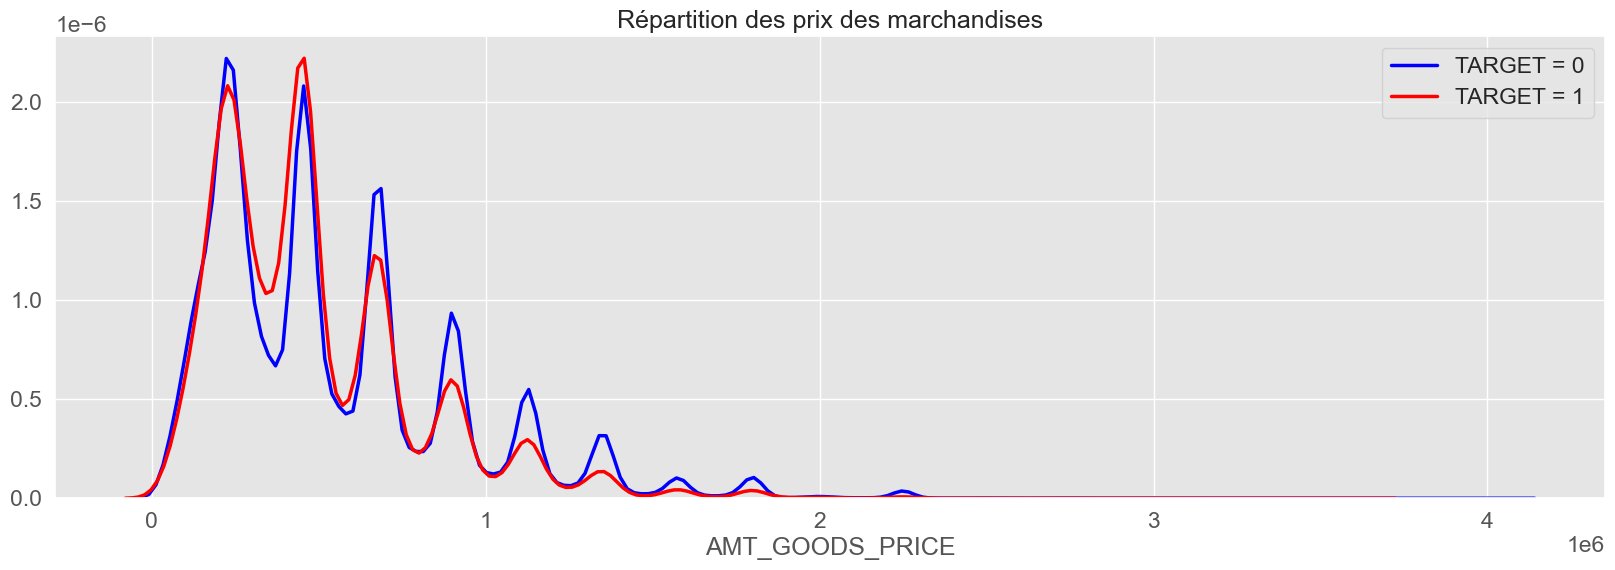

                                   -------------------------------------------------------


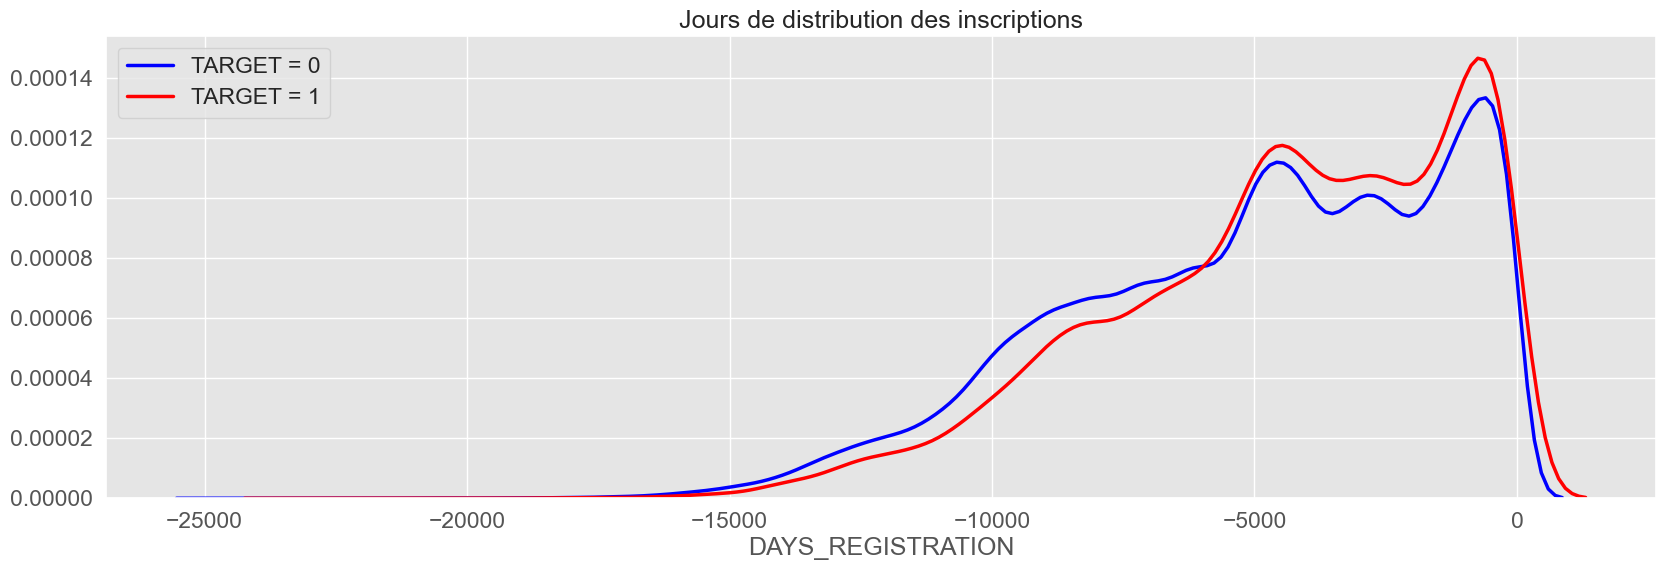

In [142]:
# Tracé de la distribution de la variable 'AMT_CREDIT'.
plot_distribution(app_train, 'AMT_CREDIT', "Répartition du crédit", (20, 6))
print("                                   -------------------------------------------------------")

# Tracé de la distribution de la variable 'AMT_ANNUITY'.
plot_distribution(app_train, 'AMT_ANNUITY', "Répartition des rentes", (20, 6))
print("                                   -------------------------------------------------------")

# Tracé de la distribution de la variable 'AMT_GOODS_PRICE'.
plot_distribution(app_train, 'AMT_GOODS_PRICE', "Répartition des prix des marchandises", (20, 6))
print("                                   -------------------------------------------------------")

# Tracé de la distribution de la variable 'DAYS_REGISTRATION'.
plot_distribution(app_train, 'DAYS_REGISTRATION', "Jours de distribution des inscriptions", (20, 6))


### 5 - Analyse exploratoire des données (EDA) bureau.csv

Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt dans notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande. SK_ID_CURR est la clé reliant les données application_train | test aux données du bureau.

In [143]:
app_train.shape

(307511, 124)

In [144]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

Nous retrouvons ici la notation XNA qui doit être remplacée par NaN (erreur de représentation NaN).

In [145]:
# Remplacer toutes les occurrences de 'XNA' dans le DataFrame 'bureau' par NaN
bureau = bureau.replace('XNA', np.nan)

In [146]:
# Fusionner les DataFrames 'app_train' et 'bureau' en utilisant la colonne 'SK_ID_CURR'
# comme clé de jointure, en conservant uniquement les lignes correspondantes dans les deux DataFrames.
application_bureau_train = app_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
application_bureau_train.shape


(1465325, 140)

**Credi_active** 
- Distribution du statut des crédits

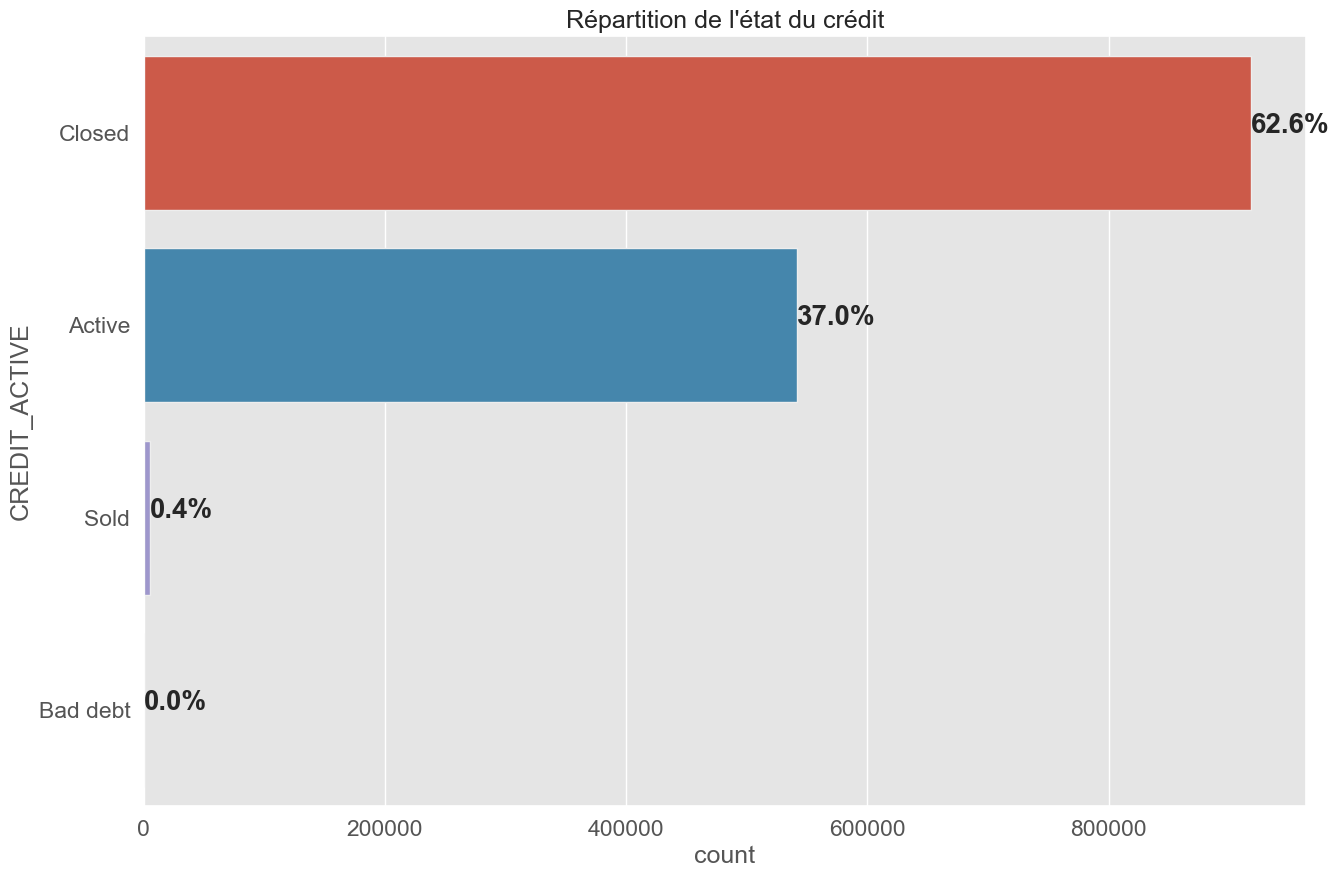

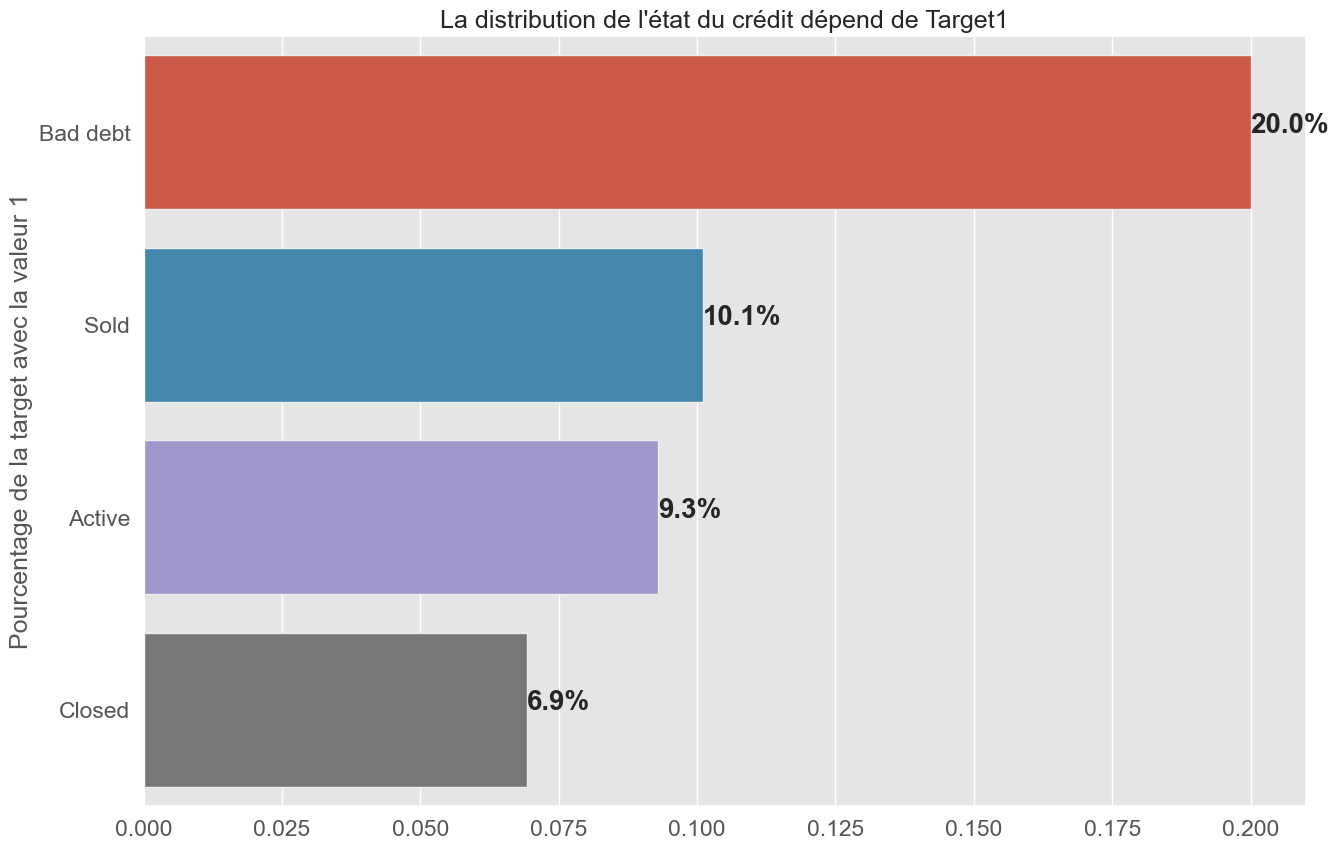

In [147]:
# Afficher la distribution de la variable 'CREDIT_ACTIVE' dans le DataFrame 'application_bureau_train'
plot_stat(application_bureau_train, 'CREDIT_ACTIVE', "Répartition de l'état du crédit", (15, 10))

# Afficher la proportion de la variable cible (TARGET) avec la valeur 1 en fonction de 'CREDIT_ACTIVE'
plot_percent_target1(application_bureau_train, 'CREDIT_ACTIVE', "La distribution de l'état du crédit dépend de Target1", (15, 10))


**credit currency** 
- Distribution devise du crédit

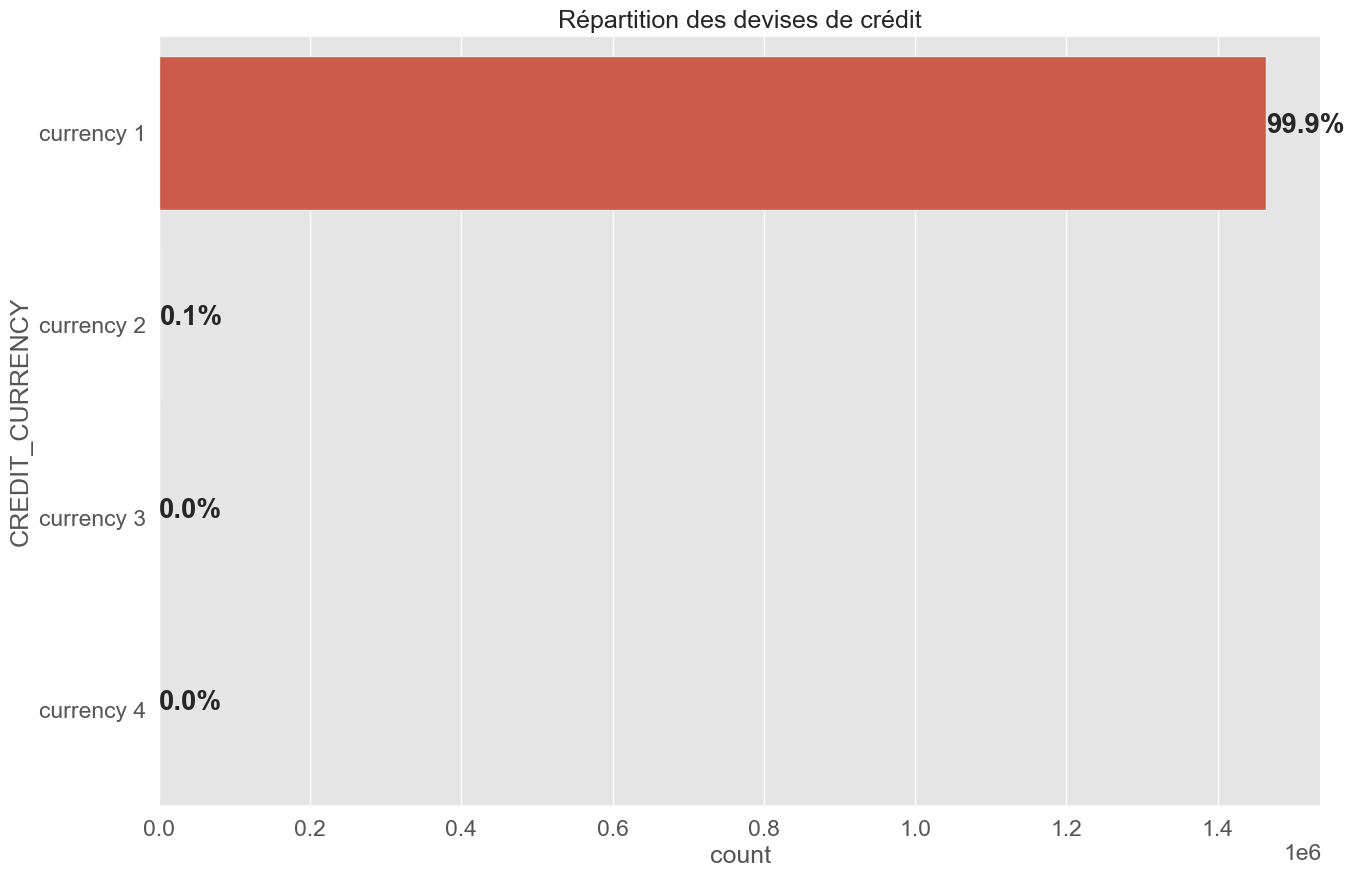

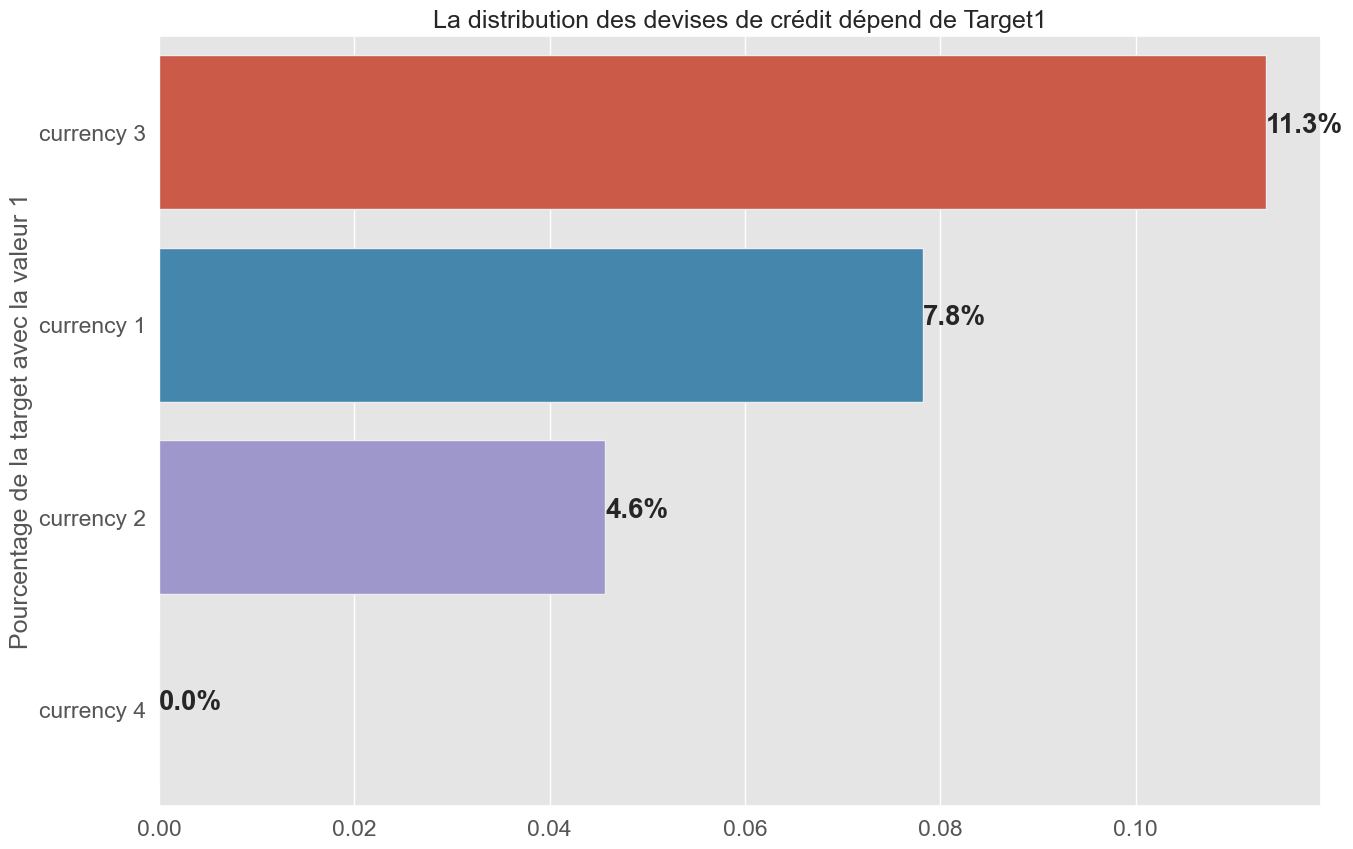

In [148]:
# Afficher la distribution de la variable 'CREDIT_CURRENCY' dans le DataFrame 'application_bureau_train'
plot_stat(application_bureau_train, 'CREDIT_CURRENCY', "Répartition des devises de crédit", (15, 10))

# Afficher la proportion de la variable cible (TARGET) avec la valeur 1 en fonction de 'CREDIT_CURRENCY'
plot_percent_target1(application_bureau_train, 'CREDIT_CURRENCY', "La distribution des devises de crédit dépend de Target1", (15, 10))


**credit type** 
- Distribution du type de crédit

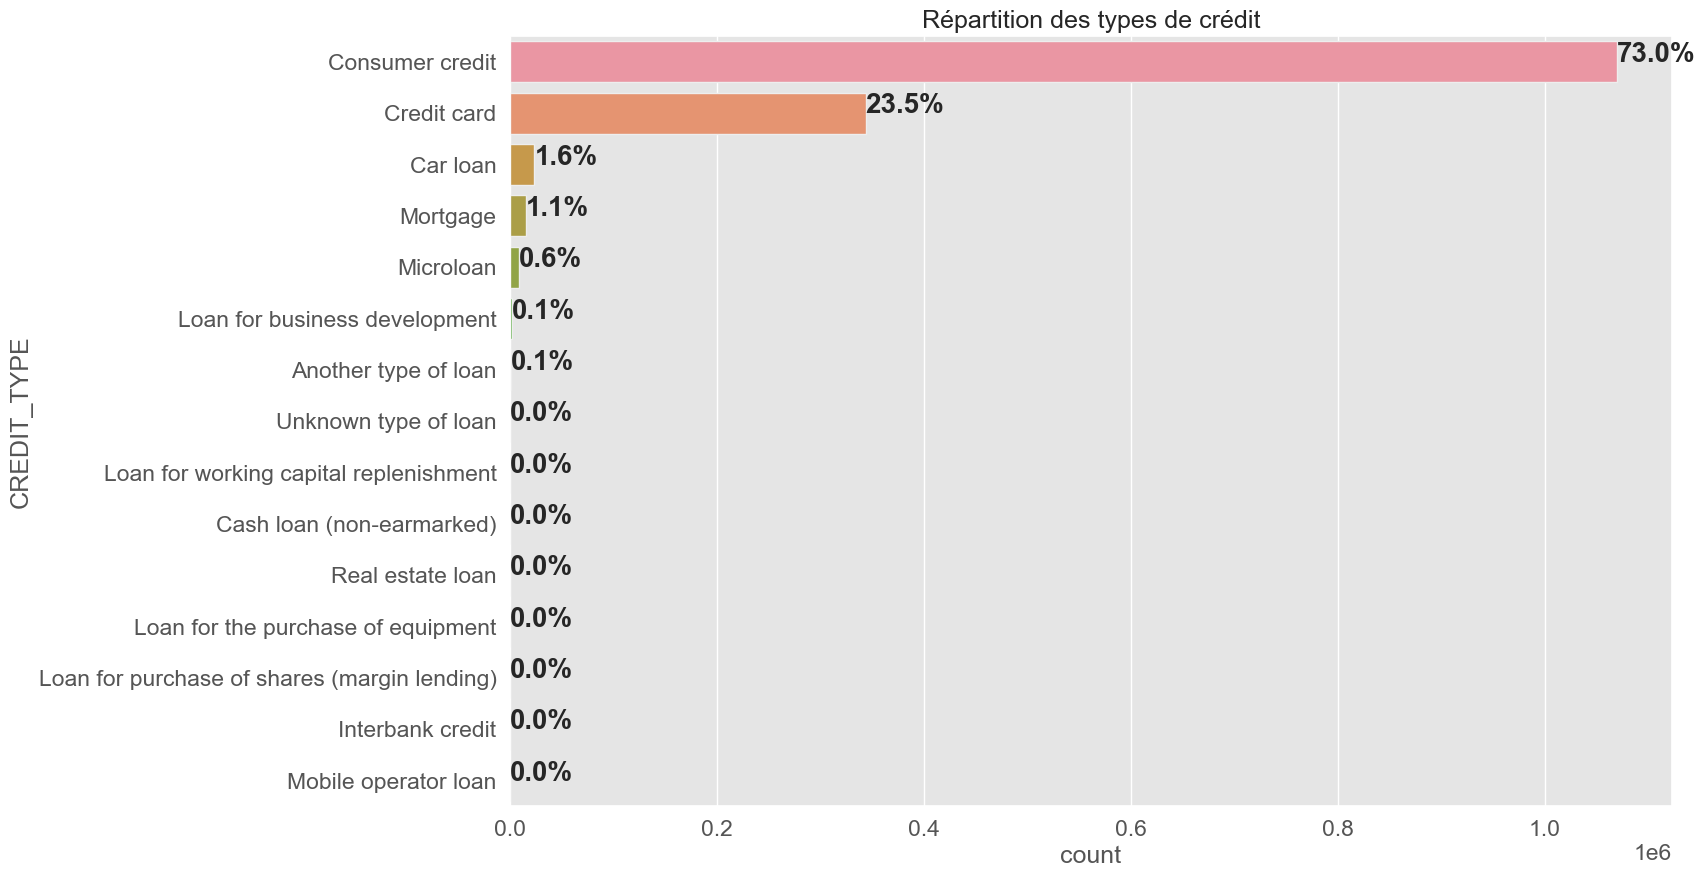

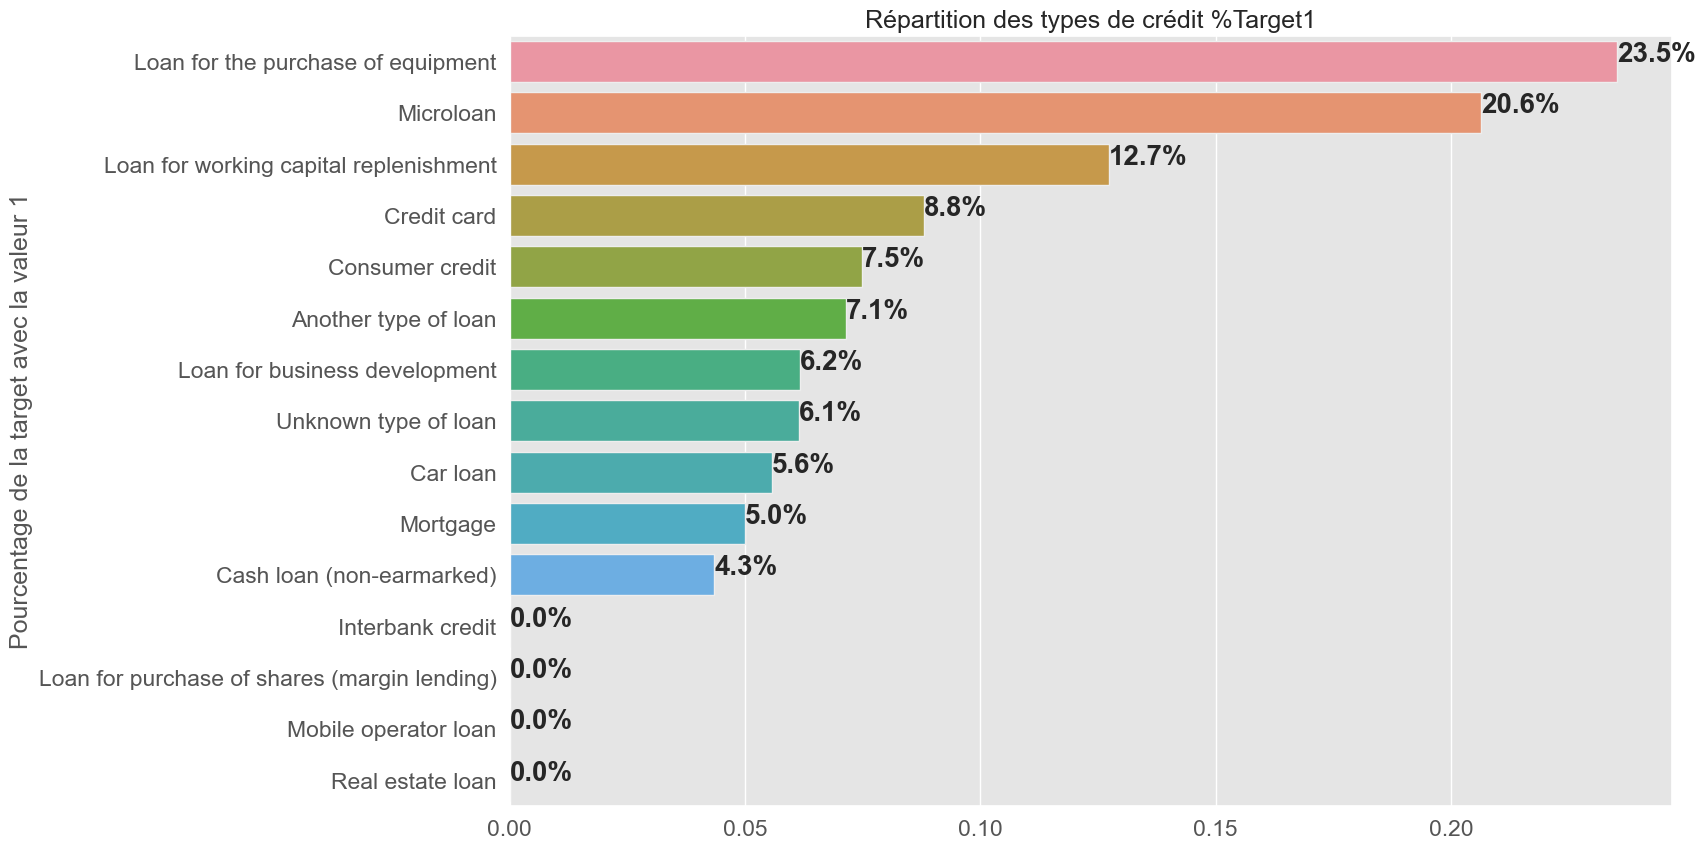

In [149]:
# Afficher la distribution de la variable 'CREDIT_TYPE' dans le DataFrame 'application_bureau_train'
plot_stat(application_bureau_train, 'CREDIT_TYPE', "Répartition des types de crédit", (15, 10))

# Afficher la proportion de la variable cible (TARGET) avec la valeur 1 en fonction de 'CREDIT_TYPE'
plot_percent_target1(application_bureau_train, 'CREDIT_TYPE', "Répartition des types de crédit %Target1", (15, 10))


### 6 - Analyse exploratoire des données (EDA) previous_application.csv

"previous_application" contient des informations sur toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans l'échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données. SK_ID_CURR est la clé reliant les données application_train | test aux données previous_application.

Il est nécessaire de fusionner "application_train" avec "previous_application" pour pouvoir collecter des informations justifiant la TARGET == 1 pour chaque client.

In [150]:
app_train.shape

(307511, 124)

In [151]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                     15.0                           Y   
1                     11.0                           Y   
2                     11.0                           Y   
3                      7.0                           Y   
4                      9.0                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                     1.0                0.0               0.182832   
1                     1.0                NaN                    NaN   
2                     1.0                NaN                    NaN   
3                     1.0                NaN                    NaN   
4                     1.0                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

Nous retrouvons ici la notation XNA qui doit être remplacée par NaN (erreur de représentation NaN).

In [152]:
# Remplacer toutes les occurrences de 'XNA' par NaN dans le DataFrame 'previous_application'
# Cela permet de traiter les valeurs manquantes ou les valeurs atypiques de manière standard
previous_application = previous_application.replace('XNA', np.nan)


In [154]:
# Fusionner les DataFrames 'app_train' et 'previous_application' en utilisant la colonne 'SK_ID_CURR' comme clé
# La jointure est une 'inner join', ce qui signifie que seules les lignes avec des valeurs correspondantes dans les deux DataFrames seront conservées
application_prev_train = app_train.merge(previous_application, 
                                         left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')
application_prev_train.shape


(1413701, 160)

**Name contract type** 
- Distribution du type des contrats

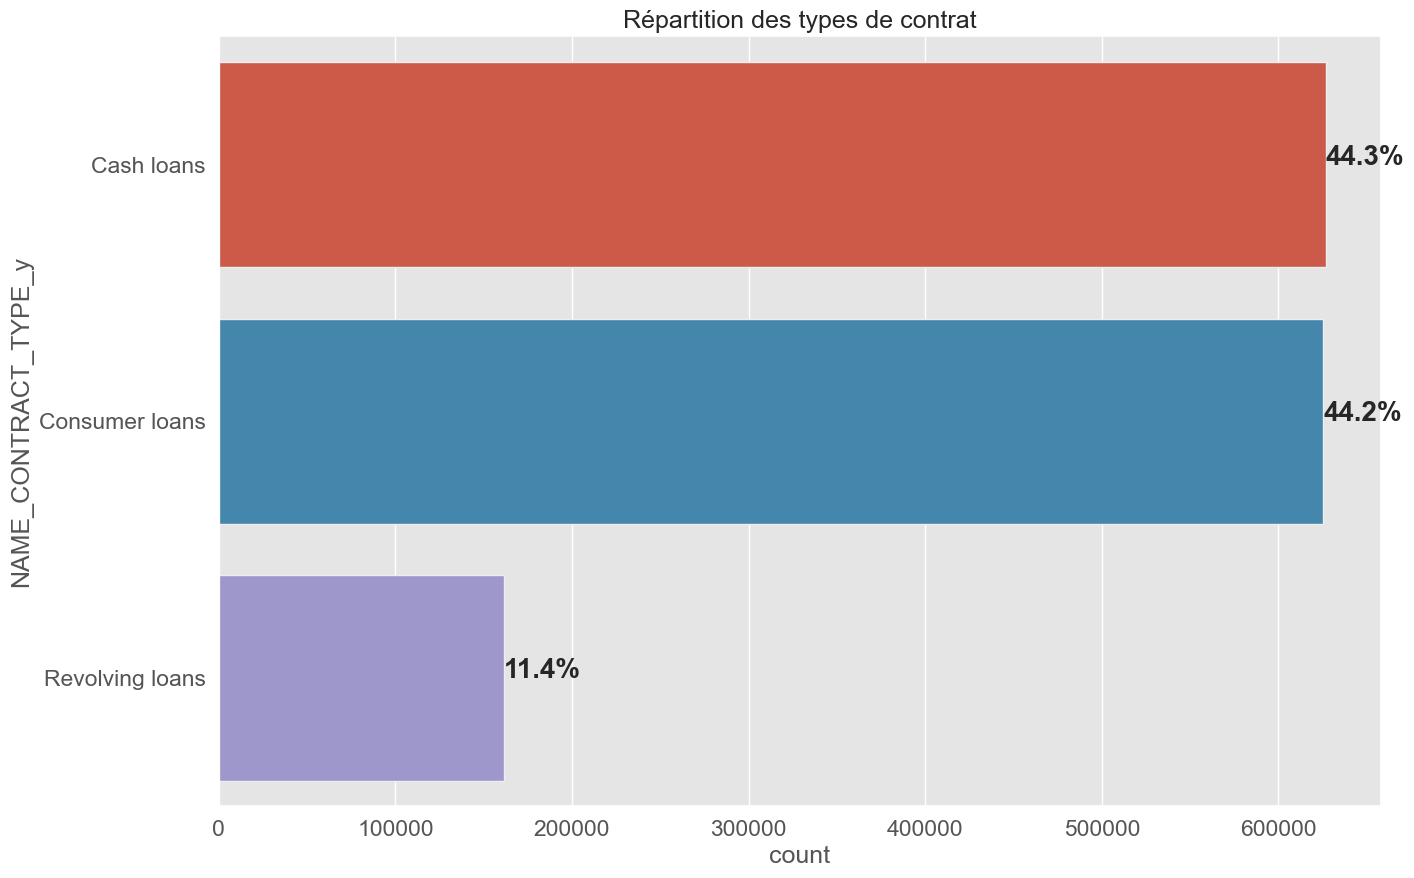

                                   -------------------------------------------------------


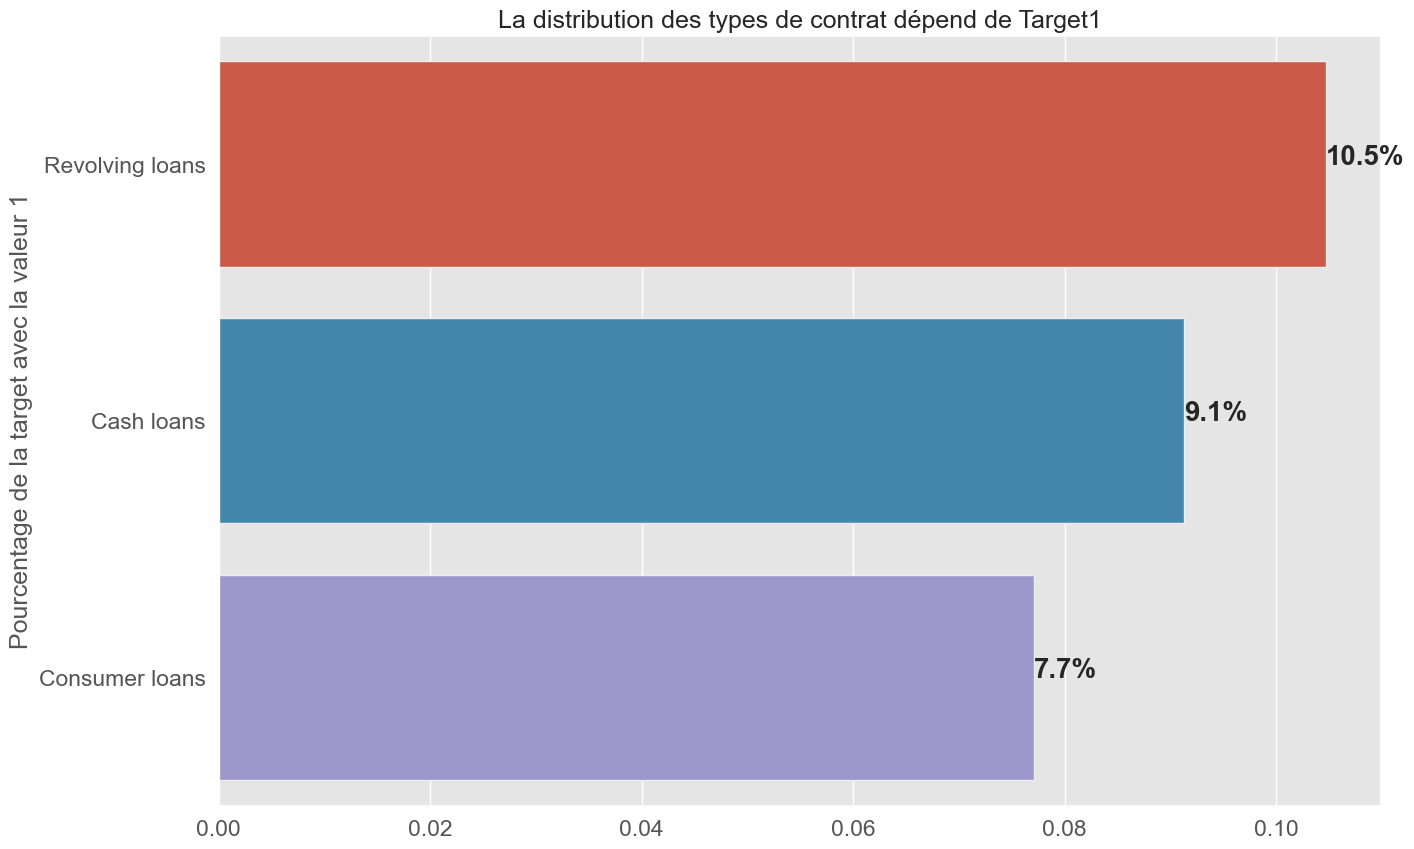

In [155]:
# Afficher la distribution de la variable 'NAME_CONTRACT_TYPE_y' dans le DataFrame 'application_prev_train'
plot_stat(application_prev_train, 'NAME_CONTRACT_TYPE_y', "Répartition des types de contrat", (15,10))
print("                                   -------------------------------------------------------")
# Afficher la distribution de la variable 'NAME_CONTRACT_TYPE_y' en fonction de la variable cible 'TARGET' dans le DataFrame 'application_prev_train'
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_TYPE_y', "La distribution des types de contrat dépend de Target1", (15,10))



**Name contract status** 
- Distribution du status des contrats 

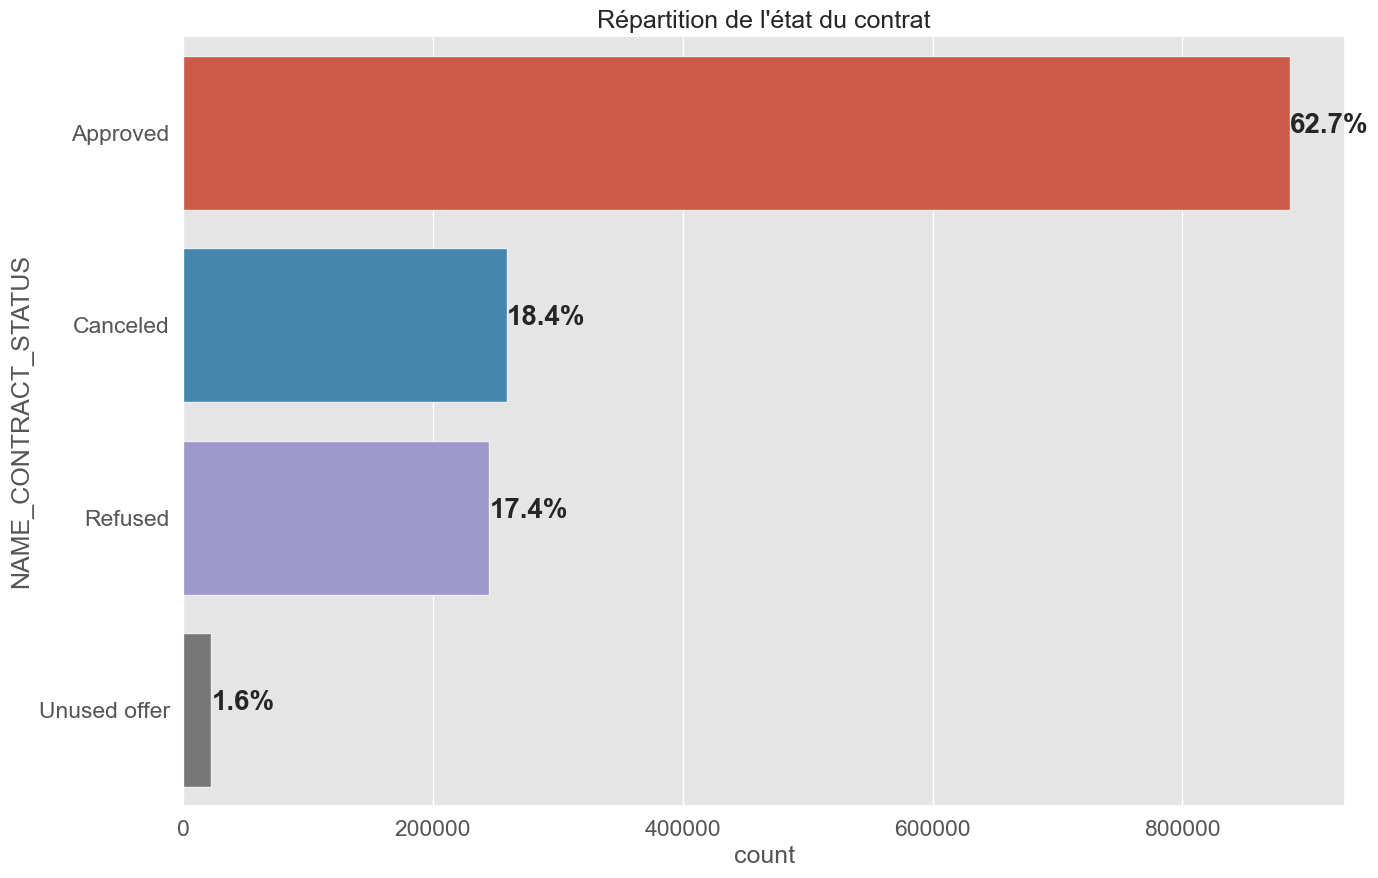

                                   -------------------------------------------------------


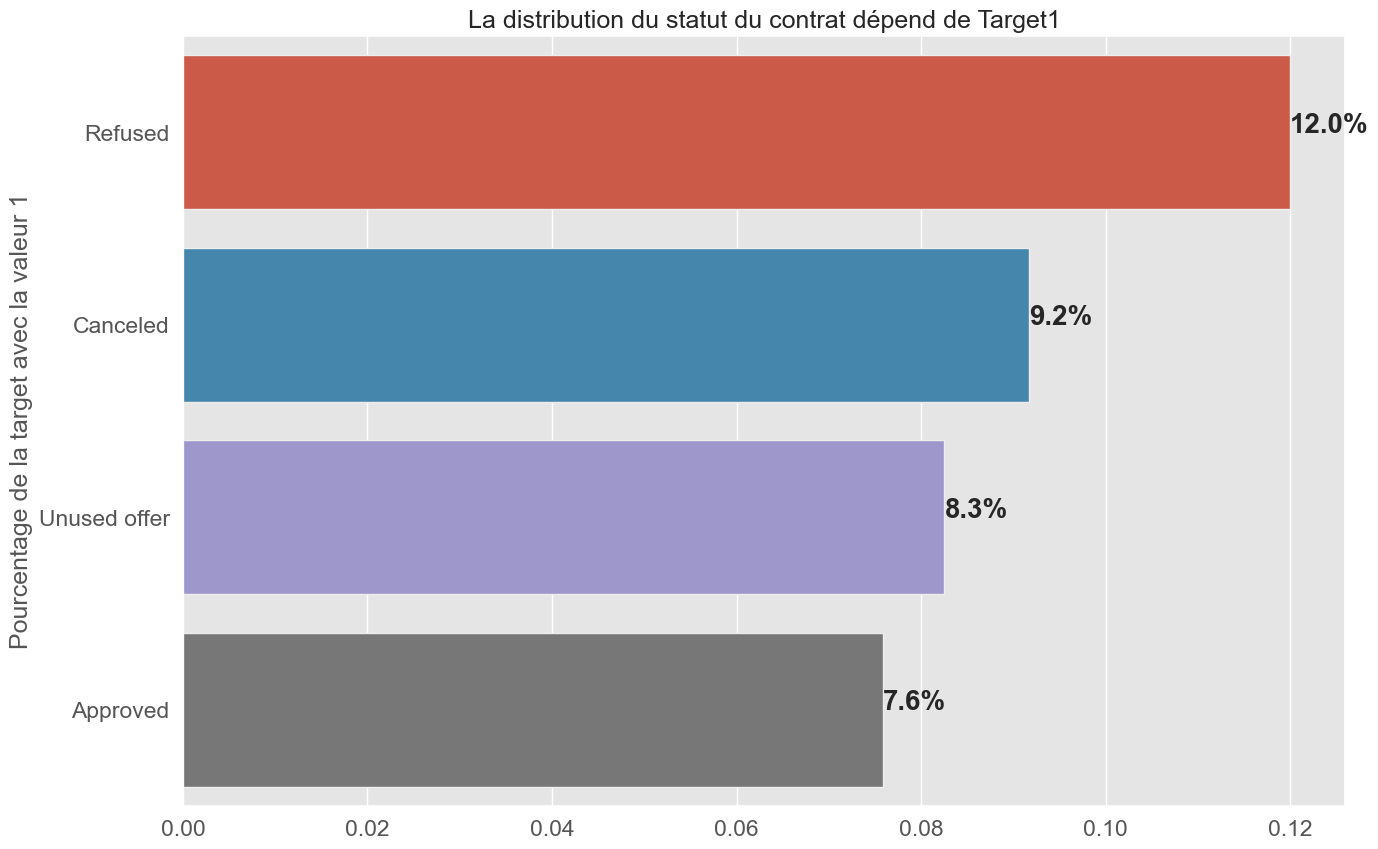

In [156]:
# Afficher la distribution de la variable 'NAME_CONTRACT_STATUS' dans le DataFrame 'application_prev_train'
plot_stat(application_prev_train, 'NAME_CONTRACT_STATUS', "Répartition de l'état du contrat", (15,10))
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_STATUS',"La distribution du statut du contrat dépend de Target1", (15,10))


**Name payment type** 
- Distribution du mode de paiement que le client a choisi pour payer la demande précédente

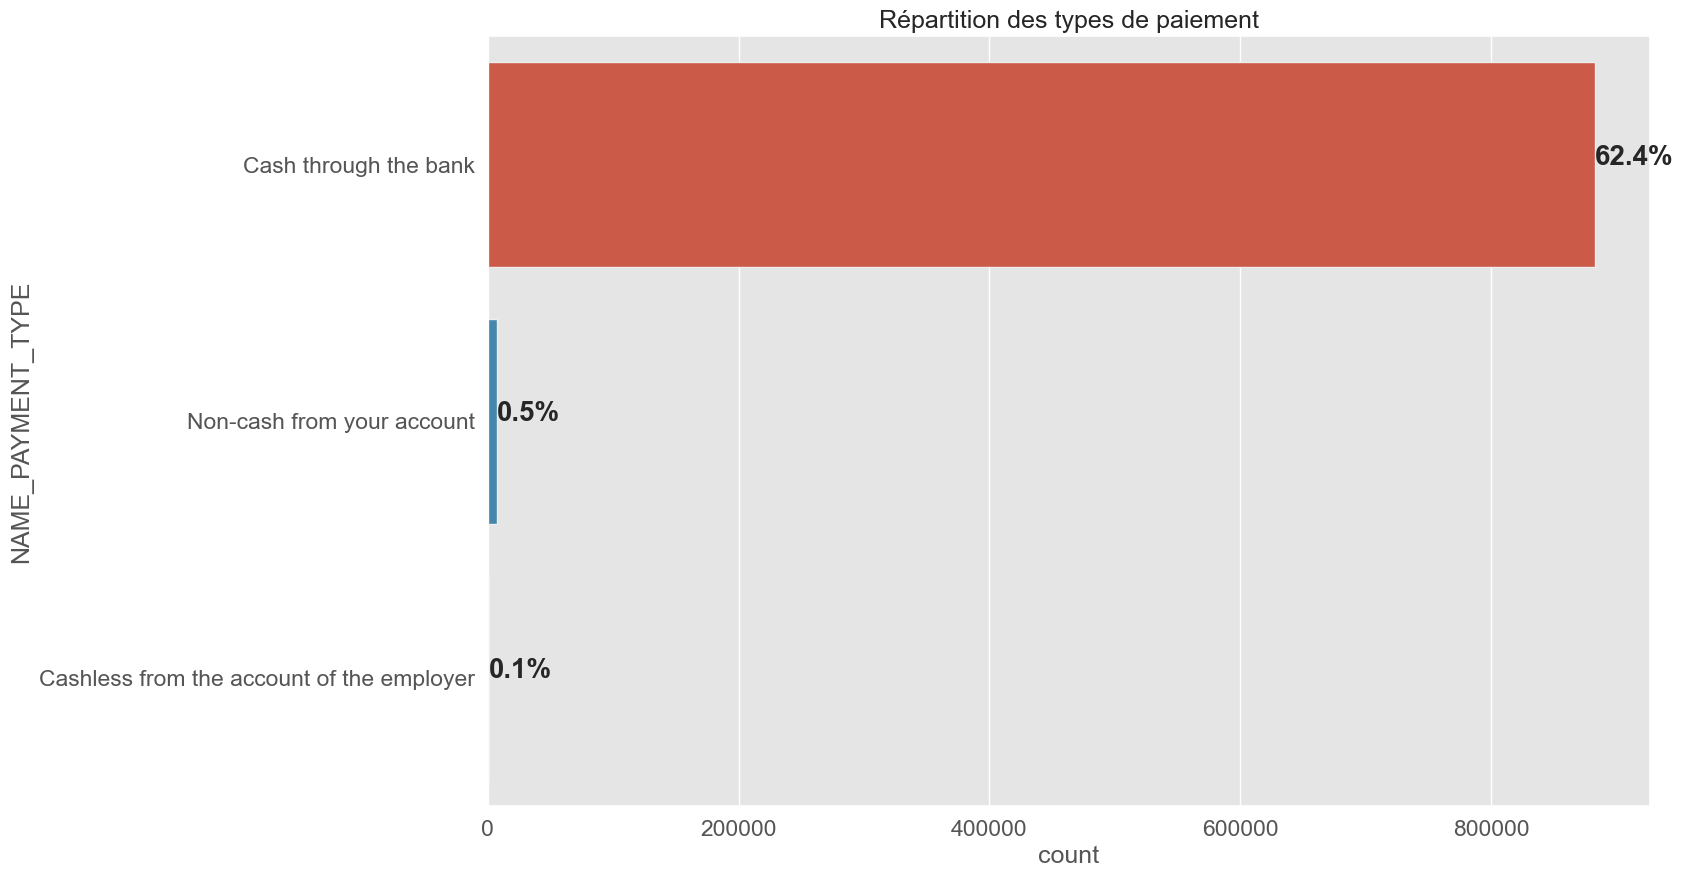

                                   -------------------------------------------------------


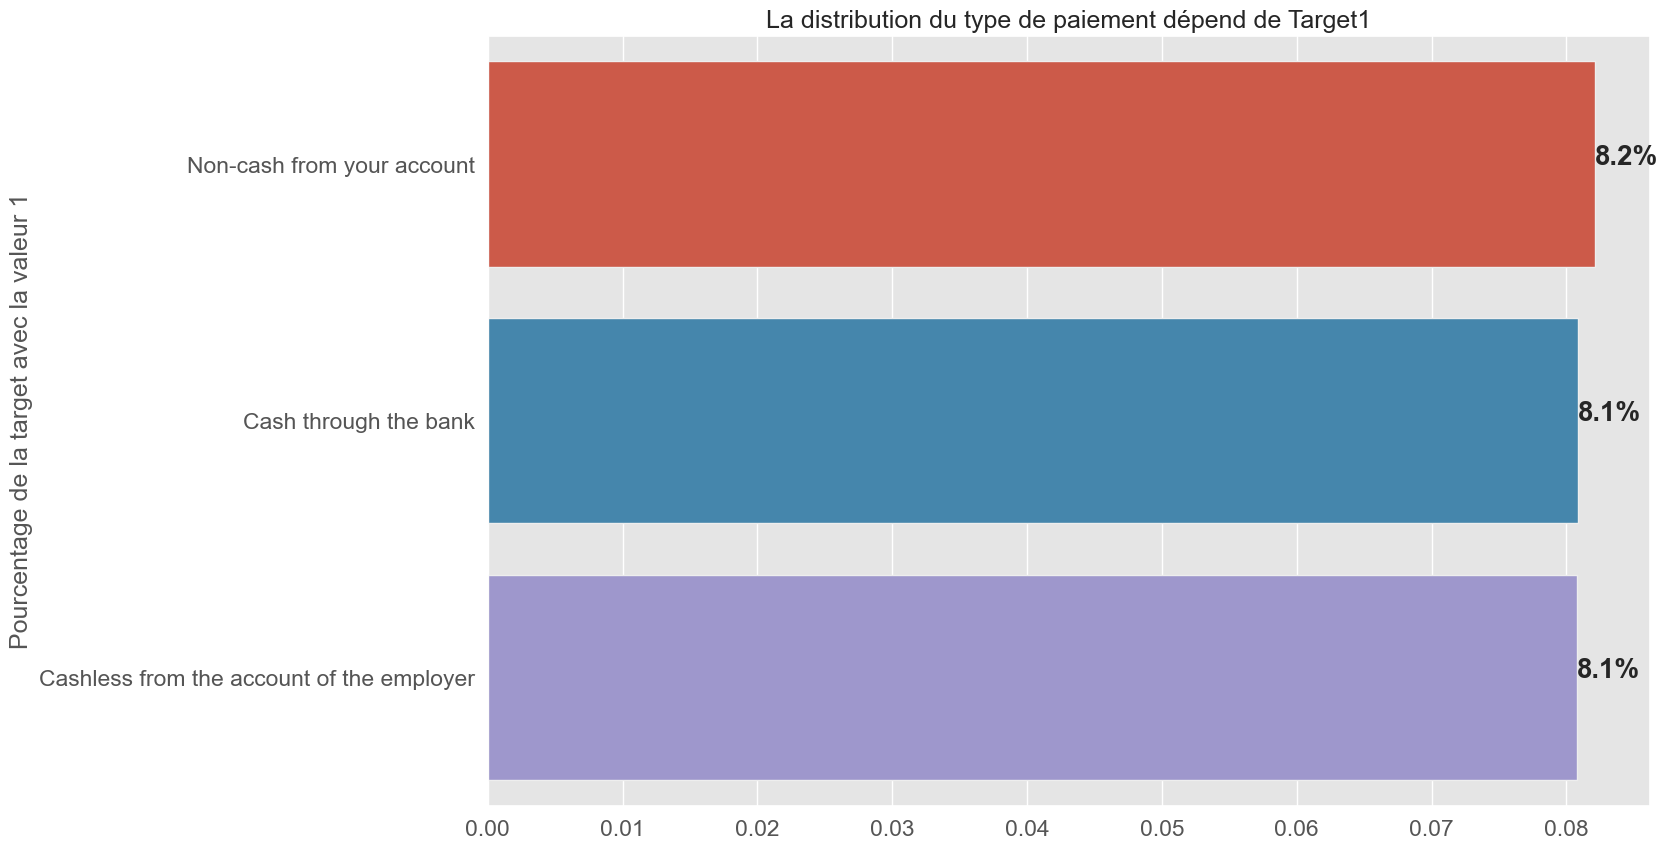

In [157]:
# Afficher la distribution de la variable 'NAME_PAYMENT_TYPE' dans le DataFrame 'application_prev_train'
plot_stat(application_prev_train, 'NAME_PAYMENT_TYPE', "Répartition des types de paiement", (15,10))
print("                                   -------------------------------------------------------")
# Afficher la distribution de la variable 'NAME_PAYMENT_TYPE' en fonction de la variable cible 'TARGET' dans le DataFrame 'application_prev_train'
plot_percent_target1(application_prev_train, 'NAME_PAYMENT_TYPE', "La distribution du type de paiement dépend de Target1", (15,10))

Le mode de paiement se fait majoritairement en Cash via la banque.

Le défaut de remboursement ne se dintingue sur aucun type de paiement, l'égalité est quasi parfaite.

**Name client type** 
- Le client était-il un ancien ou un nouveau client lors de la demande précédente

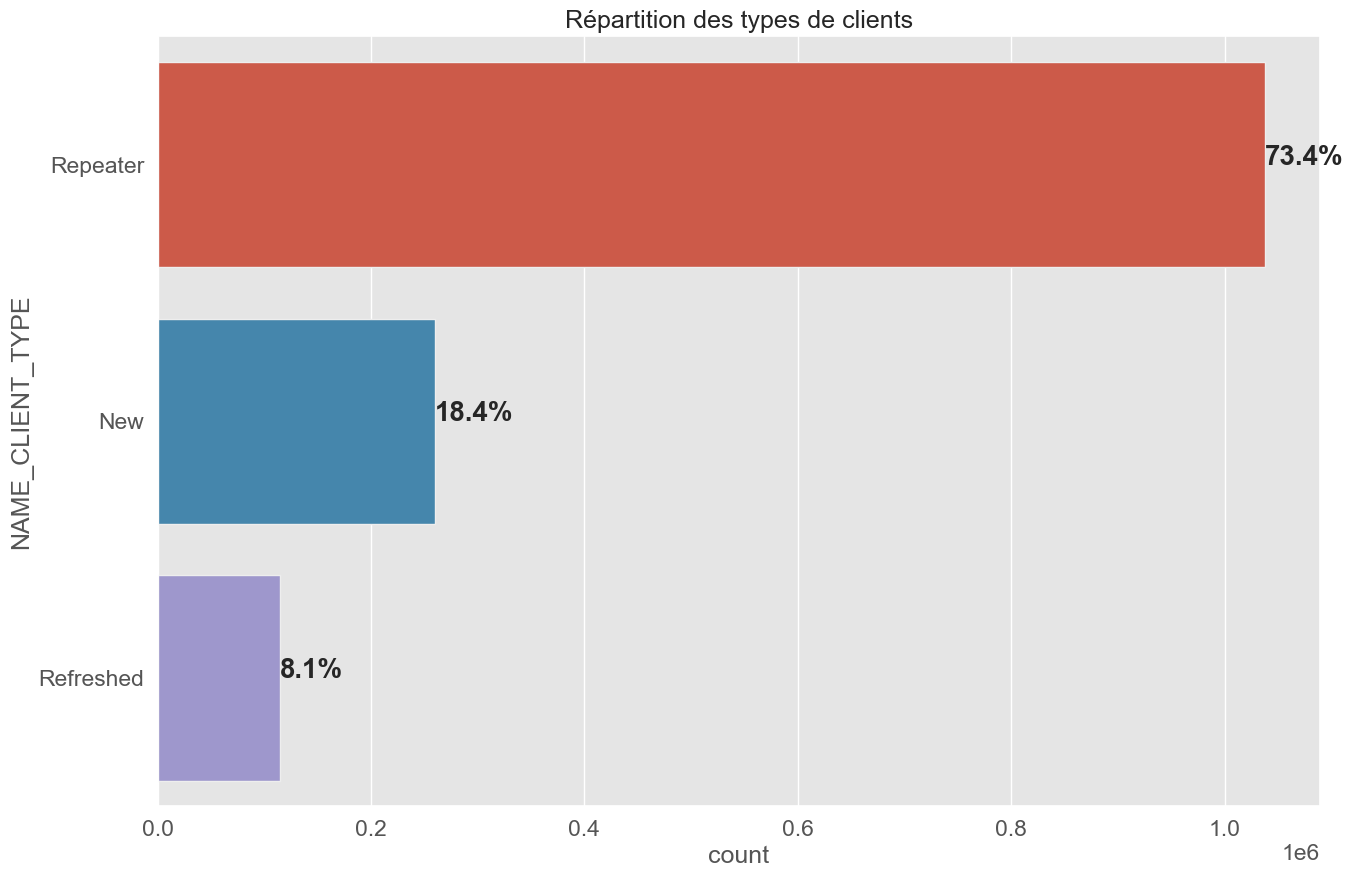

                                   -------------------------------------------------------


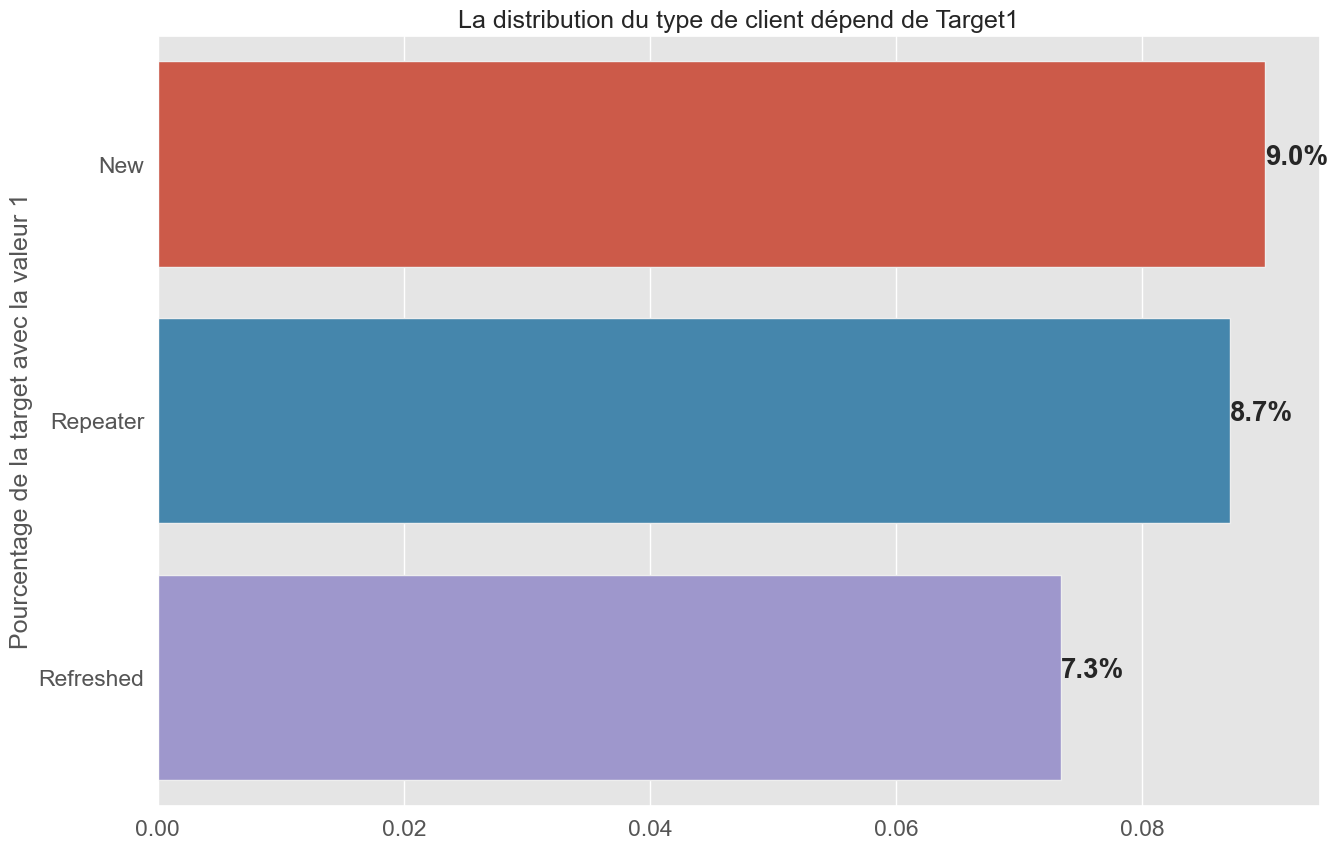

In [158]:
# Afficher la distribution de la variable 'NAME_CLIENT_TYPE' dans le DataFrame 'application_prev_train'
plot_stat(application_prev_train, 'NAME_CLIENT_TYPE', "Répartition des types de clients", (15,10))
print("                                   -------------------------------------------------------")
# Afficher la distribution de la variable 'NAME_CLIENT_TYPE' en fonction de la variable cible 'TARGET' dans le DataFrame 'application_prev_train'
plot_percent_target1(application_prev_train, 'NAME_CLIENT_TYPE', "La distribution du type de client dépend de Target1", (15,10))


Dans le jeu de données, les clients majoritaires sont ceux qui font régulièrement des demandes de prêts mais ce sont les nouveaux clients qui ont dû mal à rembourser leurs prêts.

### 7 - Création de nouvelles colonnes

In [160]:
# Fusionner les DataFrames app_train et app_test en un seul DataFrame data
data = pd.concat([app_train, app_test], ignore_index=True)

In [161]:
print('Train:' + str(app_train.shape))
print('Test:' + str(app_test.shape))
print('>>> Data:' + str(data.shape))

Train:(307511, 124)
Test:(48744, 123)
>>> Data:(356255, 124)


*bureau : bureau.csv*

In [162]:
display(bureau.head())
display(bureau.shape)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

(1716428, 17)

Calcul du nombre total des précédents crédits pour chaque client.

PREVIOUS_APPLICATION_COUNT : Nombre de demandes antérieures des clients au crédit immobilier

In [166]:
# Grouper les données du DataFrame 'bureau' par 'SK_ID_CURR' et compter le nombre d'occurrences de chaque 'SK_ID_CURR'
# Utilisation de 'as_index=False' pour éviter d'avoir 'SK_ID_CURR' comme index du DataFrame résultant
previous_application_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count()

# Renommer la colonne 'SK_ID_BUREAU' en 'PREVIOUS_APPLICATION_COUNT' pour refléter le nombre d'applications précédentes
previous_application_counts = previous_application_counts.rename(columns={'SK_ID_BUREAU': 'PREVIOUS_APPLICATION_COUNT'})

# Afficher les cinq premières lignes du DataFrame résultant pour vérifier le résultat
previous_application_counts.head()


SK_ID_CURR  PREVIOUS_APPLICATION_COUNT
0      100001                           7
1      100002                           8
2      100003                           4
3      100004                           2
4      100005                           3

In [167]:
# Fusionner les DataFrames 'data' et 'previous_application_counts' en utilisant la colonne 'SK_ID_CURR' comme clé de jointure
# Utilisation de 'how='left'' pour garder toutes les lignes du DataFrame 'data'
data = data.merge(previous_application_counts, on='SK_ID_CURR', how='left')

data.shape


(356255, 125)

In [168]:
# Créer un nouveau DataFrame vide appelé 'most_credit_type'
most_credit_type = pd.DataFrame()

# Copier les colonnes 'SK_ID_CURR' et 'CREDIT_TYPE' du DataFrame 'bureau' dans le DataFrame 'most_credit_type'
most_credit_type = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].copy()

# Afficher le DataFrame 'most_credit_type'
most_credit_type


SK_ID_CURR      CREDIT_TYPE
0            215354  Consumer credit
1            215354      Credit card
2            215354  Consumer credit
3            215354      Credit card
4            215354  Consumer credit
...             ...              ...
1716423      259355        Microloan
1716424      100044  Consumer credit
1716425      100044  Consumer credit
1716426      246829  Consumer credit
1716427      246829        Microloan

[1716428 rows x 2 columns]

In [171]:
def mode_perso(serie_values):
    # Calculer le décompte des valeurs dans la série
    count = serie_values.value_counts()
    # Renvoyer l'indice (la valeur) ayant le plus grand décompte (mode)
    return count.idxmax()

# On effectue un regroupement par 'SK_ID_CURR' et on applique la fonction 'mode_perso' pour obtenir le type de crédit le plus fréquent
most_credit_type_mode = most_credit_type.groupby(by="SK_ID_CURR").agg(mode_perso)
most_credit_type_mode

CREDIT_TYPE
SK_ID_CURR                 
100001      Consumer credit
100002          Credit card
100003      Consumer credit
100004      Consumer credit
100005      Consumer credit
...                     ...
456249      Consumer credit
456250      Consumer credit
456253      Consumer credit
456254      Consumer credit
456255      Consumer credit

[305811 rows x 1 columns]

In [170]:
# On réinitialise l'index du DataFrame 'most_credit_type_mode' pour transformer l'ancien index ('SK_ID_CURR') en colonne ordinaire
most_credit_type_mode = most_credit_type_mode.reset_index()

# On renomme la colonne 'CREDIT_TYPE' en 'MOST_CREDIT_TYPE' pour une meilleure clarté
most_credit_type_mode.rename(columns={'CREDIT_TYPE': 'MOST_CREDIT_TYPE'}, inplace=True)

# On effectue une jointure (fusion) entre le DataFrame 'data' et le DataFrame 'most_credit_type_mode' sur la colonne 'SK_ID_CURR'
# Cela ajoute la colonne 'MOST_CREDIT_TYPE' contenant le type de crédit le plus fréquent pour chaque emprunteur dans le DataFrame 'data'
left_df = data
right_df = most_credit_type_mode
data = pd.merge(left_df, right_df, on='SK_ID_CURR', how='left')

data.head()


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002     1.0         Cash loans           M            N   
1      100003     0.0         Cash loans           F            N   
2      100004     0.0    Revolving loans           M            Y   
3      100006     0.0         Cash loans           F            N   
4      100007     0.0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

*previous_application* : Toutes les demandes précédentes de prêts pour le **crédit immobilier** des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données.

In [201]:
display(previous_application.head())
display(previous_application.shape)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                     15.0                           Y   
1                     11.0                           Y   
2                     11.0                           Y   
3                      7.0                           Y   
4                      9.0                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                     1.0                0.0               0.182832   
1                     1.0                NaN                    NaN   
2                     1.0                NaN                    NaN   
3                     1.0                NaN                    NaN   
4                     1.0                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    NaN             Approved   
2                       NaN                    NaN             Approved   
3                       NaN                    NaN             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    NaN                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               NaN   
1         Repeater                 NaN           Cash            x-sell   
2         Repeater                 NaN           Cash            x-sell   
3         Repeater                 NaN           Cash            x-sell   
4         Repeater                 NaN           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  NaN   
2  Credit and cash offices                -1                  NaN   
3  Credit and cash offices                -1                  NaN   
4  Credit and cash offices                -1                  NaN   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

(1670214, 37)

PREVIOUS_LOANS_COUNT from previous_application.csv: Nombre total des précédents crédits pris par chaque client

In [202]:
# On groupe les données du DataFrame 'previous_application' par la colonne 'SK_ID_CURR',
# qui représente l'identifiant unique de chaque emprunteur.
# L'argument 'as_index=False' indique que la colonne 'SK_ID_CURR' ne doit pas être utilisée comme index.
previous_loan_counts = previous_application.groupby('SK_ID_CURR', as_index=False)

# On compte le nombre d'occurrences de chaque 'SK_ID_PREV' pour chaque emprunteur
# et renomme la colonne résultante en 'PREVIOUS_LOANS_COUNT' pour rendre le résultat plus explicite.
previous_loan_counts = previous_loan_counts['SK_ID_PREV'].count().rename(columns={'SK_ID_PREV': 'PREVIOUS_LOANS_COUNT'})

previous_loan_counts.head()


SK_ID_CURR  PREVIOUS_LOANS_COUNT
0      100001                     1
1      100002                     1
2      100003                     3
3      100004                     1
4      100005                     2

In [203]:
# On effectue une fusion entre le DataFrame 'data' et le DataFrame 'previous_loan_counts'
# sur la colonne 'SK_ID_CURR', qui est l'identifiant unique de chaque emprunteur.
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape


(356255, 127)

CREDIT_PERCENT_INCOME : le pourcentage du montant du crédit par rapport au revenu du client.

ANNUITY_CREDIT_PERCENT_INCOME : le pourcentage de l'annuité du prêt par rapport au revenu du client.

CREDIT_REFUND_TIME : la durée que va mettre un client à rembourser un prêt en année de crédit (l'annuité étant le montant annuel dû).

DAYS_EMPLOYED_PERCENT : le pourcentage des jours d'emploi par rapport à l'âge du client.

In [204]:
# Calcul du rapport entre le montant du crédit et le revenu total de l'emprunteur
data['CREDIT_PERCENT_INCOME'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']

# Calcul du rapport entre l'annuité et le revenu total de l'emprunteur
data['ANNUITY_CREDIT_PERCENT_INCOME'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']

# Calcul du temps de remboursement estimé en divisant le montant du crédit par l'annuité
data['CREDIT_REFUND_TIME'] =  data['AMT_CREDIT'] / data['AMT_ANNUITY']

# Calcul du pourcentage des jours d'emploi par rapport à l'âge en jours de l'emprunteur
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']


In [205]:
print('data shape : ', data.shape)

data shape :  (356255, 131)


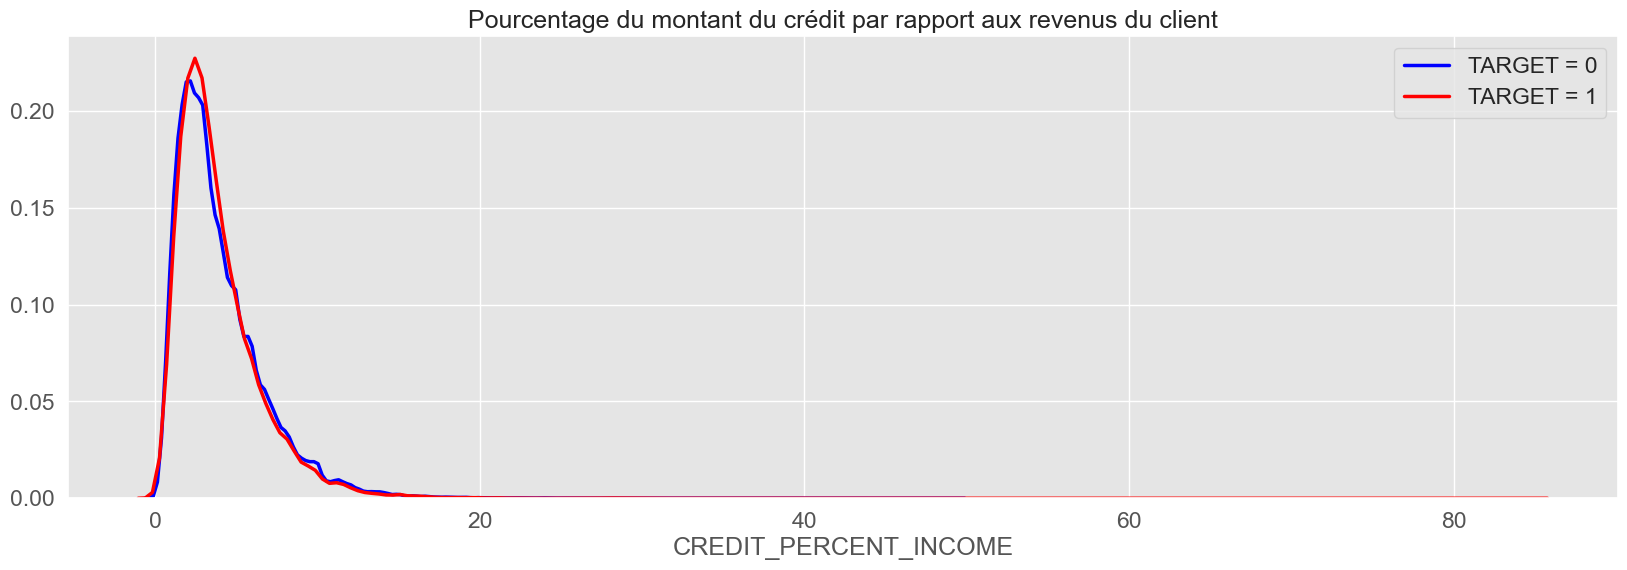

                                   -------------------------------------------------------


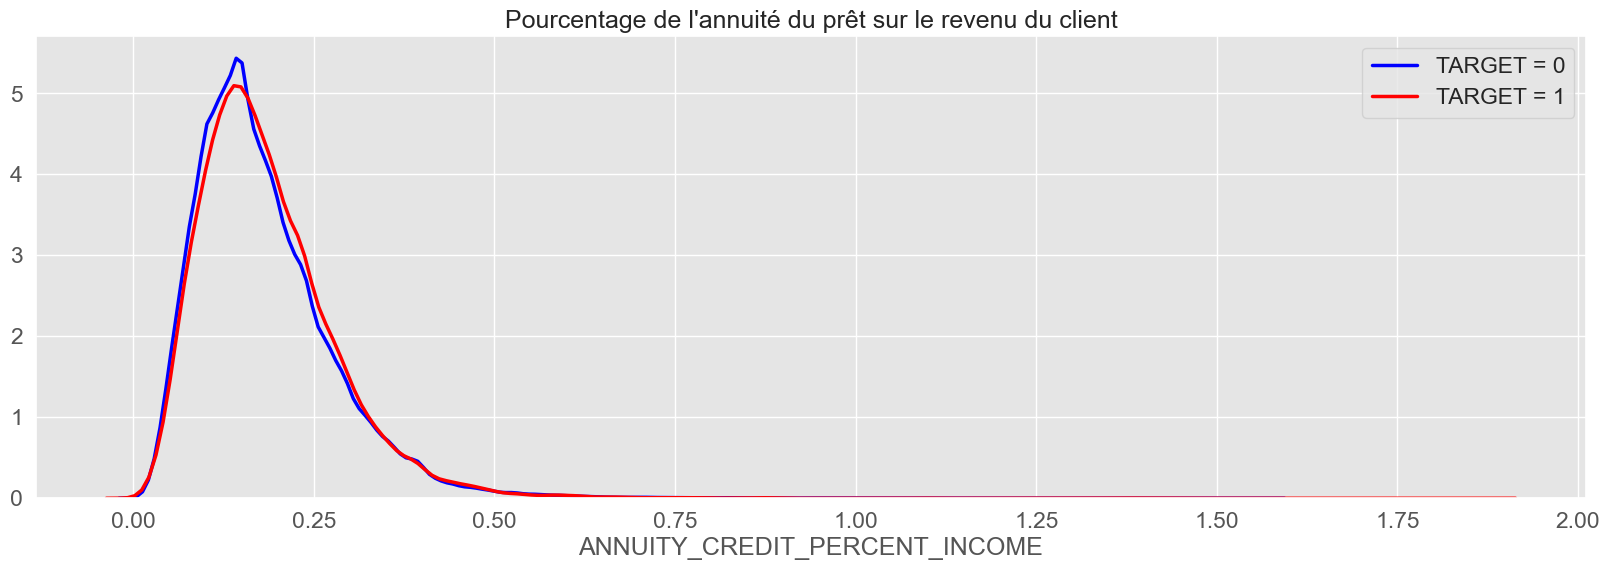

                                   -------------------------------------------------------


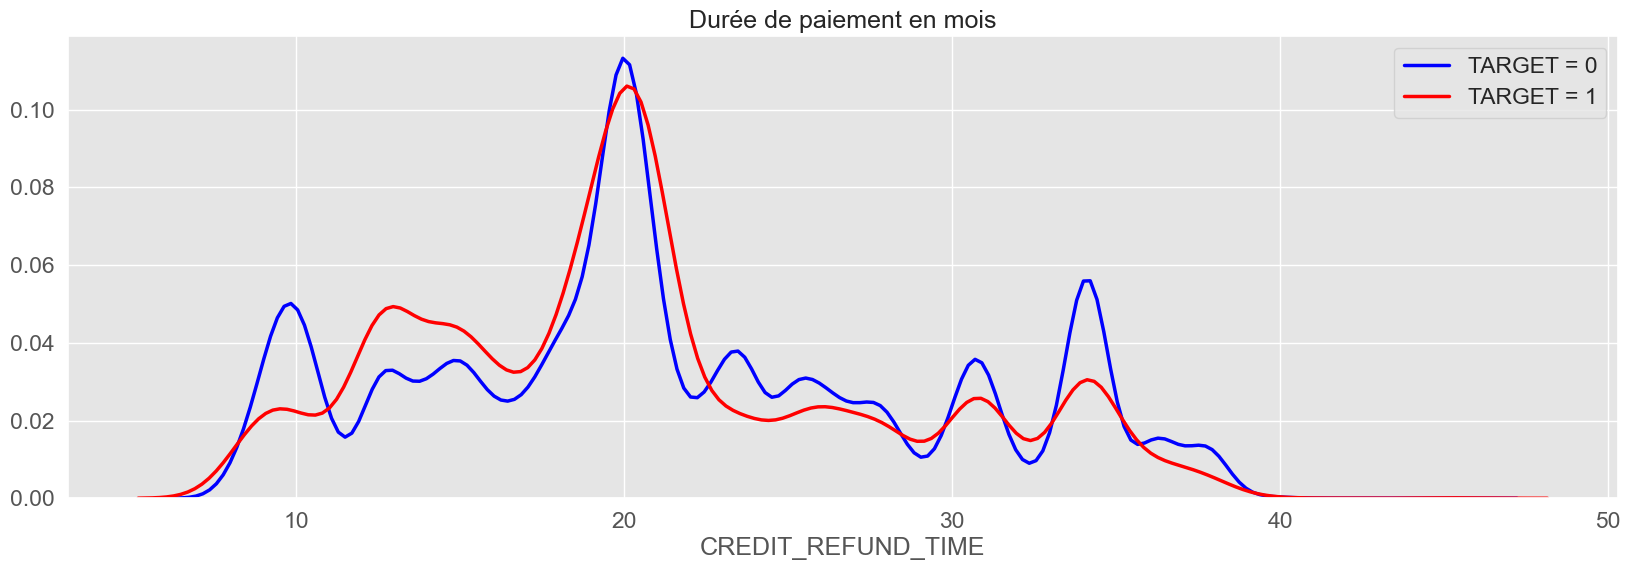

                                   -------------------------------------------------------


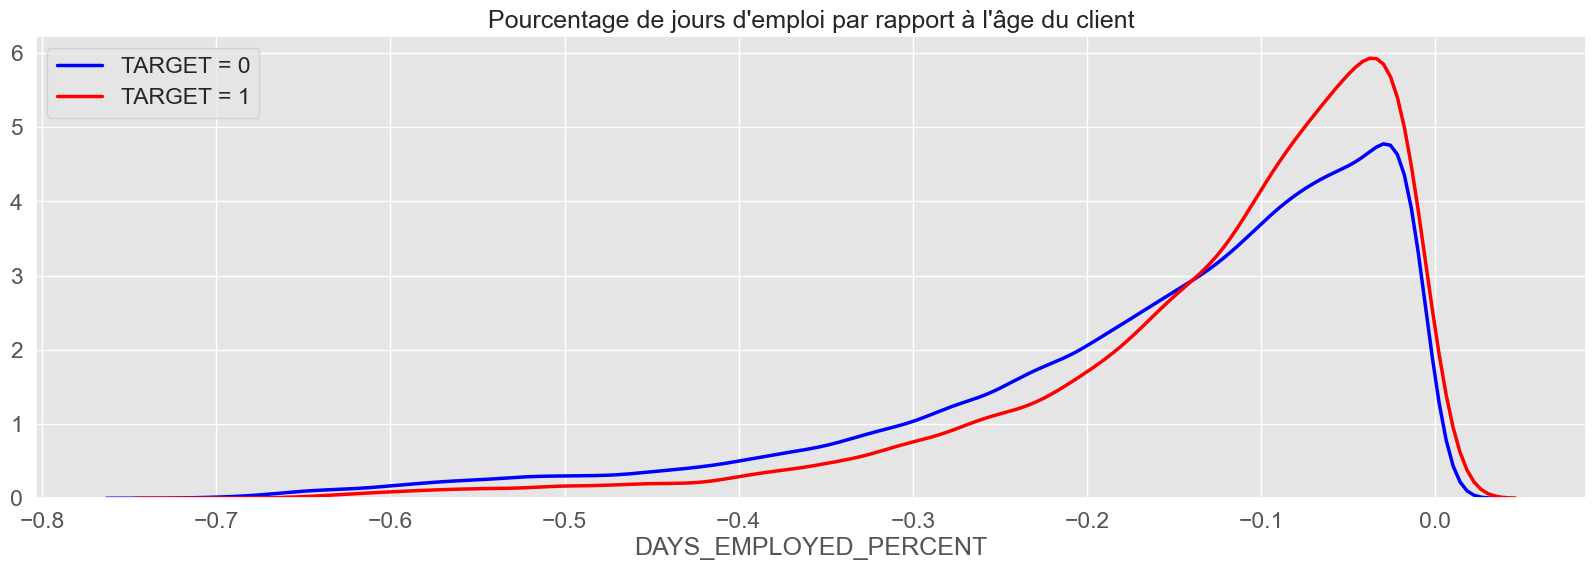

In [206]:
# Affichage de la distribution du pourcentage du montant du crédit par rapport au revenu total du client
plot_distribution(data,'CREDIT_PERCENT_INCOME', "Pourcentage du montant du crédit par rapport aux revenus du client", (20,6))
print("                                   -------------------------------------------------------")

# Affichage de la distribution du pourcentage de l'annuité du prêt par rapport au revenu total du client
plot_distribution(data,'ANNUITY_CREDIT_PERCENT_INCOME', "Pourcentage de l'annuité du prêt sur le revenu du client", (20,6))
print("                                   -------------------------------------------------------")

# Affichage de la distribution de la durée de remboursement estimée en mois
plot_distribution(data,'CREDIT_REFUND_TIME', "Durée de paiement en mois", (20,6))
print("                                   -------------------------------------------------------")

# Affichage de la distribution du pourcentage des jours d'emploi par rapport à l'âge du client
plot_distribution(data,'DAYS_EMPLOYED_PERCENT', "Pourcentage de jours d'emploi par rapport à l'âge du client", (20,6))


In [207]:
# Remplacer les espaces dans les noms de colonnes par des traits de soulignement (_)
data = data.replace(' ', '_', regex=True)

# Cette opération remplace tous les espaces dans les noms de colonnes du DataFrame "data"
# par des traits de soulignement en utilisant une expression régulière (regex=True).
# Cela facilite l'accès aux colonnes et évite des problèmes potentiels lors de l'utilisation

### 8 - Séparation de data en train et test comme à l'origine 

In [208]:
# Sélectionner les lignes de "data" correspondant aux clients présents dans le dataset entraînement "app_train"
data_train = data[data['SK_ID_CURR'].isin(app_train["SK_ID_CURR"])]

# Sélectionner les lignes de "data" correspondant aux clients présents dans le dataset test "app_test"
data_test = data[data['SK_ID_CURR'].isin(app_test["SK_ID_CURR"])]

# Supprimer la colonne "TARGET" dans le dataset test, car elle ne doit pas être utilisée comme variable cible
data_test = data_test.drop('TARGET', axis=1)


In [209]:
print('Training Features shape origin: ', app_train.shape)
print('Testing Features shape origin: ', app_test.shape)

Training Features shape origin:  (307511, 124)
Testing Features shape origin:  (48744, 123)


In [210]:
print('Training Features shape after merging: ', data_train.shape)
print('Testing Features shape after merging: ', data_test.shape)

Training Features shape after merging:  (307511, 131)
Testing Features shape after merging:  (48744, 130)


### 9 - Cleaning 

#### 9.1 Suppression des lignes qui ont un taux de remplissage inférieur à une limite

 ce code est un code de test avant de créer une fonction il permet de calcule le taux de remplissage pour chaque ligne dans l'ensemble de données d'entraînement data_train en considérant différents seuils de remplissage allant de 0 à 1

In [215]:
# Crée une copie de dataset d'entraînement
find_rate = data_train.copy()

# Remplace les chaînes de caractères '^nan$' (c'est-à-dire les chaînes contenant uniquement 'nan') par np.nan (valeur manquante)
find_rate = find_rate.replace(to_replace='^nan$', value=np.nan, regex=True)

# Détermine le nombre de lignes et de colonnes dans l'ensemble de données
nb_lines = find_rate.shape[0]
nb_columns = find_rate.shape[1]

# Calcule le taux de remplissage pour chaque ligne en divisant le nombre de valeurs non manquantes par le nombre total de colonnes
find_rate['taux_remplissage_lines'] = (data_train.apply(lambda x: x.count(), axis=1) / nb_columns)

# Crée deux listes pour stocker les taux de remplissage et le nombre de lignes supprimées pour chaque seuil de remplissage
filling_rate = []
remove_line = []

# Boucle pour tester différents taux de remplissage
for i in range(0, 11, 1):
    taux_remplissage = i / 10.0  # Convertit i en un taux de remplissage (de 0 à 1)

    # Ajoute le taux de remplissage en pourcentage à la liste filling_rate
    filling_rate.append(taux_remplissage * 100)

    # Sélectionne les lignes de "find_rate" ayant un taux de remplissage supérieur au seuil donné
    df_2 = find_rate[find_rate['taux_remplissage_lines'] > taux_remplissage]

    # Calcule le nombre de lignes supprimées en soustrayant le nombre de lignes sélectionnées (df_2.shape[0]) du nombre total de lignes (nb_lines)
    nb_lines_supp = nb_lines - df_2.shape[0]
    # Ajoute le nombre de lignes supprimées à la liste remove_line
    remove_line.append(nb_lines_supp)

    # Supprime la colonne 'taux_remplissage_lines' de "df_2"
    del df_2['taux_remplissage_lines']

# Crée un DataFrame "find_rate" contenant les listes filling_rate et remove_line sous les colonnes 'filling_rate' et 'remove_lines'
find_rate = pd.DataFrame(
    {
        'filling_rate': filling_rate,
        'remove_lines': remove_line
    })


In [218]:
find_rate

filling_rate  remove_lines
0            0.0             0
1           10.0             0
2           20.0             0
3           30.0             0
4           40.0             0
5           50.0             6
6           60.0         37003
7           70.0        152704
8           80.0        169492
9           90.0        212032
10         100.0        307511

<Axes: xlabel='filling_rate', ylabel='remove_lines'>

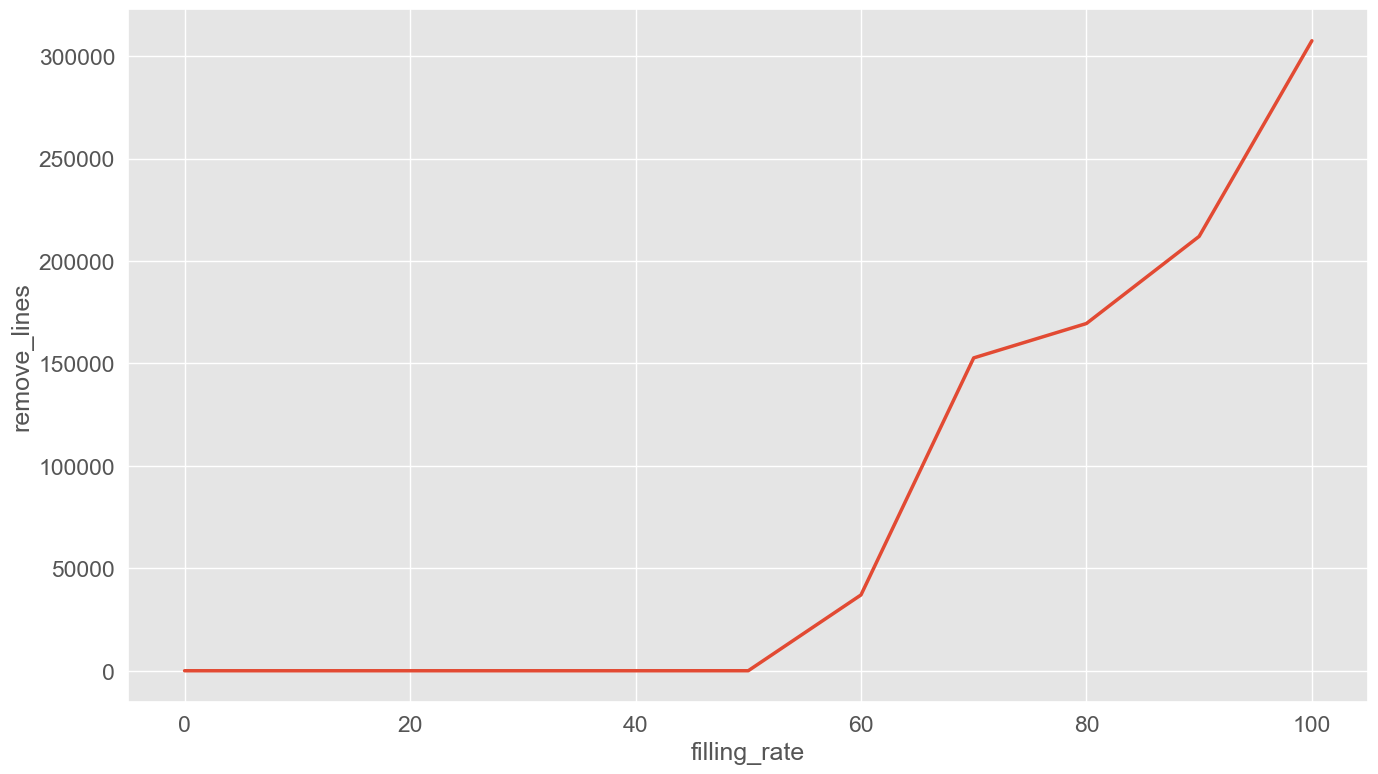

In [219]:
# Tracer un graphique de ligne en utilisant les données du DataFrame find_rate
sns.lineplot(data=find_rate, x="filling_rate", y="remove_lines")

# Le DataFrame find_rate contient deux colonnes : "filling_rate" et "remove_lines".
# "filling_rate" représente le taux de remplissage souhaité, exprimé en pourcentage (de 0 à 100%).
# "remove_lines" représente le nombre de lignes supprimées pour chaque taux de remplissage donné.

In [224]:
def filtration_line(dataframe, taux_remplissage):
    df = dataframe.copy()  # Crée une copie du DataFrame pour éviter de modifier l'original
    dataframe = dataframe.replace(to_replace='^nan$', value=np.nan, regex=True)  # Remplace les chaînes de caractères '^nan$' par np.nan (valeurs manquantes)

    nb_lines = dataframe.shape[0]  # Nombre de lignes dans le DataFrame

    # Calcule le taux de remplissage pour chaque ligne en divisant le nombre de valeurs non manquantes par le nombre total de colonnes
    df['taux_remplissage_lines'] = (dataframe.apply(lambda x: x.count(), axis=1) / nb_columns)

    # Sélectionne les lignes de "df" ayant un taux de remplissage supérieur au seuil donné
    df_2 = df[df['taux_remplissage_lines'] > taux_remplissage]

    # Calcule le nombre de lignes supprimées en soustrayant le nombre de lignes sélectionnées (df_2.shape[0]) du nombre total de lignes (nb_lines)
    nb_lines_supp = nb_lines - df_2.shape[0]

    # Affiche le nombre de lignes avec un taux de remplissage supérieur au seuil et le nombre de lignes supprimées
    print(f"Nombre de lignes avec un taux de remplissage supérieur à {taux_remplissage :.2%} : {df_2.shape[0]} lignes")
    print(f"Nombre de lignes supprimées : {nb_lines_supp} lignes")
    print(df_2.shape)

    # Supprime la colonne 'taux_remplissage_lines' de "df_2" pour ne pas la conserver dans le DataFrame de sortie
    del df_2['taux_remplissage_lines']

    return df_2  # Retourne le DataFrame filtré


In [225]:
# appliquer la fonction de filtrage sur taux de remplissage
app_train_clean_lines = filtration_line(data_train, 0.7)

Nombre de lignes avec un taux de remplissage supérieur à 70.00% : 154807 lignes
Nombre de lignes supprimées : 152704 lignes
(154807, 132)


In [226]:
app_train_clean_lines.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0       100002     1.0         Cash_loans           M            N   
1       100003     0.0         Cash_loans           F            N   
12      100016     0.0         Cash_loans           F            N   
13      100017     0.0         Cash_loans           M            Y   
14      100018     0.0         Cash_loans           F            N   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                Y             0          202500.0    406597.5      24700.5   
1                N             0          270000.0   1293502.5      35698.5   
12               Y             0           67500.0     80865.0       5881.5   
13               N             1          225000.0    918468.0      28966.5   
14               Y             0          189000.0    773680.5      32778.0   

    AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0          351000.0   Unaccompanied          Working   
1         1129500.0          Family    State_servant   
12          67500.0   Unaccompanied          Working   
13         697500.0   Unaccompanied          Working   
14         679500.0   Unaccompanied          Working   

              NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0   Secondary_/_secondary_special  Single_/_not_married  House_/_apartment   
1                Higher_education               Married  House_/_apartment   
12  Secondary_/_secondary_special               Married  House_/_apartment   
13  Secondary_/_secondary_special               Married  House_/_apartment   
14  Secondary_/_secondary_special               Married  House_/_apartment   

    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                     0.018801        9461         -637.0            -3648.0   
1                     0.003541       16765        -1188.0            -1186.0   
12                    0.031329       13439        -2717.0             -311.0   
13                    0.016612       14086        -3028.0             -643.0   
14                    0.010006       14583         -203.0             -615.0   

    DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -2120          NaN           1               1                0   
1              -291          NaN           1               1                0   
12            -3227          NaN           1               1                1   
13            -4911         23.0           1               1                0   
14            -2056          NaN           1               1                0   

    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                  1           1           0        Laborers              1.0   
1                  1           1           0      Core_staff              2.0   
12                 1           1           0        Laborers              2.0   
13                 1           0           0         Drivers              3.0   
14                 1           0           0        Laborers              2.0   

    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                      2                            2   
1                      1                            1   
12                     2                            2   
13                     2                            2   
14                     2                            1   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                   WEDNESDAY                       10   
1                      MONDAY                       11   
12                     FRIDAY                       10   
13                   THURSDAY                       13   
14                     MONDAY                        9   

    REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                            0                           0   
1                            0 

In [227]:
# appliquer la fonction de filtrage sur taux de remplissage
app_test_clean_lines = filtration_line(data_test, 0.7)

Nombre de lignes avec un taux de remplissage supérieur à 70.00% : 25345 lignes
Nombre de lignes supprimées : 23399 lignes
(25345, 131)


#### 9.2 Suppression des colonnes qui ont un taux de remplissage inférieur à une limite

 ce code est un code de test avant de créer une fonction il permet de calcule le taux de remplissage pour chaque colonne dans l'ensemble de données d'entraînement data_train en considérant différents seuils de remplissage allant de 0 à 1

In [228]:
# Copie du DataFrame app_train_clean_lines dans la variable find_rate
find_rate = app_train_clean_lines.copy()

# Remplacer toutes les chaînes de caractères '^nan$' par des NaN (valeurs manquantes) dans le DataFrame
find_rate = find_rate.replace(to_replace='^nan$', value=np.nan, regex=True)

# Nombre de colonnes dans le DataFrame find_rate
nb_colonne = find_rate.shape[1]

# Listes pour stocker le taux de remplissage et le nombre de colonnes supprimées
filling_rate = []
remove_col = []

# Boucle pour calculer le taux de remplissage souhaité et le nombre de colonnes supprimées
# pour chaque taux de remplissage
for i in range(0, 11, 1):
    # Calcul du taux de remplissage en pourcentage (de 0 à 100%)
    taux_remplissage = i / 10.0
    
    # Ajouter le taux de remplissage à la liste filling_rate (en pourcentage)
    filling_rate.append(taux_remplissage * 100)

    # Sélectionner les colonnes du DataFrame dont le taux de remplissage est supérieur au taux souhaité
    # Le taux de remplissage est calculé en utilisant la fonction isnull().mean() qui retourne le pourcentage
    # de valeurs manquantes dans chaque colonne.
    # Ainsi, la condition 1 - find_rate.isnull().mean() > taux_remplissage sélectionne les colonnes ayant
    # un taux de remplissage supérieur au taux souhaité.
    df = find_rate[find_rate.columns[1 - find_rate.isnull().mean() > taux_remplissage]]
    
    # Nombre de colonnes au final
    nb_colonne_supp = nb_colonne - df.shape[1]
    
    # Ajouter le nombre de colonnes supprimées à la liste remove_col
    remove_col.append(nb_colonne_supp)

# Créer un nouveau DataFrame find_rate qui contient les taux de remplissage et le nombre de colonnes supprimées
find_rate = pd.DataFrame(
    {'filling_rate': filling_rate,
     'remove_columns': remove_col
    })

# Afficher le DataFrame find_rate qui contient le taux de remplissage et le nombre de colonnes supprimées pour chaque taux
find_rate


filling_rate  remove_columns
0            0.0               0
1           10.0               0
2           20.0               0
3           30.0               0
4           40.0               1
5           50.0               2
6           60.0               5
7           70.0              19
8           80.0              19
9           90.0              40
10         100.0             131

<Axes: xlabel='filling_rate', ylabel='remove_columns'>

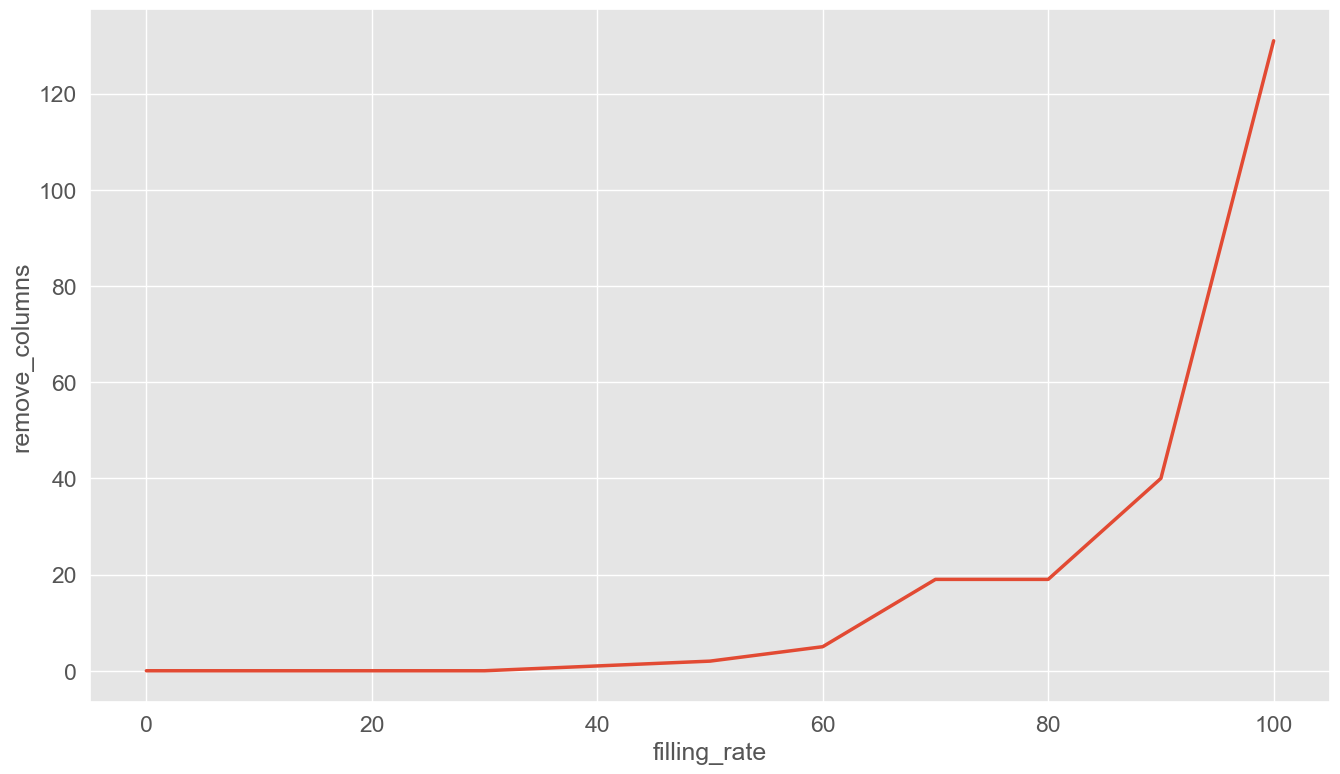

In [229]:
# Cette ligne génère un graphique en ligne (line plot) à partir des données stockées dans le DataFrame find_rate.
sns.lineplot(data=find_rate, x="filling_rate", y="remove_columns")

In [230]:
def filtration_columns(dataframe, taux_remplissage):
    # Remplacement de toutes les valeurs "nan" par np.nan dans le DataFrame
    dataframe = dataframe.replace(to_replace='^nan$', value=np.nan, regex=True)
    
    # Nombre de colonnes dans le DataFrame d'origine
    nb_colonne = dataframe.shape[1]
    
    # Sélection des colonnes ayant un taux de remplissage supérieur au taux donné
    # On utilise la méthode dataframe.isnull().mean() qui renvoie un DataFrame de la même taille que dataframe
    # avec True pour les valeurs manquantes et False pour les valeurs non manquantes.
    # Ensuite, on inverse les valeurs (de True à False et vice versa) en utilisant 1 - dataframe.isnull().mean()
    # pour obtenir les colonnes non manquantes. Enfin, on sélectionne les colonnes où le taux de remplissage est supérieur au taux donné.
    df = dataframe[dataframe.columns[1 - dataframe.isnull().mean() > taux_remplissage]]

    # Calcul du nombre de colonnes au début moins le nombre de colonnes restantes après la sélection
    nb_colonne_supp = nb_colonne - df.shape[1]

    # Affichage du nombre de colonnes avec un taux de remplissage supérieur au taux donné et du nombre de colonnes supprimées
    print(f"Nombre de colonnes avec un taux de remplissage supérieur à {taux_remplissage :.2%} : {df.shape[1]} colonnes.")
    print(f"Nombre de colonnes supprimées : {nb_colonne_supp} colonnes")

    # Retourne le DataFrame df qui contient uniquement les colonnes avec un taux de remplissage supérieur au taux donné
    return df


In [231]:
# appliquer la fonction de filtrage sur taux de remplissage
app_train_reduced = filtration_columns(app_train_clean_lines, 0.8)

Nombre de colonnes avec un taux de remplissage supérieur à 80.00% : 112 colonnes.
Nombre de colonnes supprimées : 19 colonnes


In [232]:
app_train_reduced.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0       100002     1.0         Cash_loans           M            N   
1       100003     0.0         Cash_loans           F            N   
12      100016     0.0         Cash_loans           F            N   
13      100017     0.0         Cash_loans           M            Y   
14      100018     0.0         Cash_loans           F            N   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                Y             0          202500.0    406597.5      24700.5   
1                N             0          270000.0   1293502.5      35698.5   
12               Y             0           67500.0     80865.0       5881.5   
13               N             1          225000.0    918468.0      28966.5   
14               Y             0          189000.0    773680.5      32778.0   

    AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0          351000.0   Unaccompanied          Working   
1         1129500.0          Family    State_servant   
12          67500.0   Unaccompanied          Working   
13         697500.0   Unaccompanied          Working   
14         679500.0   Unaccompanied          Working   

              NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0   Secondary_/_secondary_special  Single_/_not_married  House_/_apartment   
1                Higher_education               Married  House_/_apartment   
12  Secondary_/_secondary_special               Married  House_/_apartment   
13  Secondary_/_secondary_special               Married  House_/_apartment   
14  Secondary_/_secondary_special               Married  House_/_apartment   

    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                     0.018801        9461         -637.0            -3648.0   
1                     0.003541       16765        -1188.0            -1186.0   
12                    0.031329       13439        -2717.0             -311.0   
13                    0.016612       14086        -3028.0             -643.0   
14                    0.010006       14583         -203.0             -615.0   

    DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -2120           1               1                0   
1              -291           1               1                0   
12            -3227           1               1                1   
13            -4911           1               1                0   
14            -2056           1               1                0   

    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                  1           1           0              1.0   
1                  1           1           0              2.0   
12                 1           1           0              2.0   
13                 1           0           0              3.0   
14                 1           0           0              2.0   

    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                      2                            2   
1                      1                            1   
12                     2                            2   
13                     2                            2   
14                     2                            1   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                   WEDNESDAY                       10   
1                      MONDAY                       11   
12                     FRIDAY                       10   
13                   THURSDAY                       13   
14                     MONDAY                        9   

    REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                            0                           0   
1                            0                           0   
12                           0                           0   
13                           0                           0   
14                 

In [233]:
app_train_reduced.shape

(154807, 112)

ce code effectue une vérification pour chaque colonne spécifiée dans le DataFrame app_train_reduced pour s'assurer qu'elle existe dans le dataset

In [234]:
# Colonnes à vérifier et ajouter
columns_to_check = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'AGE']

for column in columns_to_check:
    if column in app_train_reduced.columns:
        print(f"La colonne '{column}' est présente dans le dataset.")
    else:
        app_train_reduced[column] = app_train_clean_lines[column]
        print(f"La colonne '{column}' a été ajoutée au dataset.")


La colonne 'EXT_SOURCE_1' a été ajoutée au dataset.
La colonne 'EXT_SOURCE_2' est présente dans le dataset.
La colonne 'EXT_SOURCE_3' est présente dans le dataset.
La colonne 'DAYS_EMPLOYED' est présente dans le dataset.
La colonne 'DAYS_BIRTH' est présente dans le dataset.
La colonne 'AGE' est présente dans le dataset.


In [235]:
app_train_reduced.shape

(154807, 113)

In [236]:
# Récupérer les noms de colonnes du DataFrame app_train_reduced
# et les stocker dans une liste appelée filter_columns.
filter_columns = list(app_train_reduced.columns)


In [237]:
def remove_columns(dataframe, filter_columns):
    """Filtre un dataframe en ne gardant que les colonnes spécifiées.
    
    Args:
        dataframe (pandas.DataFrame): Le DataFrame à filtrer.
        filter_columns (list): Liste des noms de colonnes à conserver.

    Returns:
        pandas.DataFrame: Un nouveau DataFrame contenant uniquement les colonnes spécifiées.
    """
    
    # Créer un nouveau DataFrame vide qui va contenir les colonnes sélectionnées.
    new = pd.DataFrame()

    # Parcourir chaque colonne dans la liste filter_columns.
    for column in filter_columns:
        try:
            # Essayer de copier la colonne du DataFrame d'origine vers le nouveau DataFrame.
            new[column] = dataframe[column]
        except:
            # Si la colonne spécifiée n'existe pas dans le DataFrame d'origine,
            # afficher un message d'erreur indiquant que la colonne n'est pas présente.
            print('...colonne non présente : ', column)
            print('\n')
    
    # Une fois toutes les colonnes sélectionnées copiées dans le nouveau DataFrame,
    # afficher un message indiquant que le filtrage est terminé avec succès.
    print("Toutes les colonnes sélectionnées ont été conservées dans le nouveau dataset.")

    # Renvoyer le nouveau DataFrame contenant les colonnes spécifiées.
    return new


In [238]:
# appliquer la fonction de filtrage
app_test_reduced = remove_columns(app_test_clean_lines, filter_columns)

...colonne non présente :  TARGET


Toutes les colonnes sélectionnées ont été conservées dans le nouveau dataset.


In [239]:
app_test_reduced

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
307511      100001         Cash_loans           F            N   
307514      100028         Cash_loans           F            N   
307516      100042         Cash_loans           F            Y   
307519      100066         Cash_loans           F            N   
307521      100074         Cash_loans           F            N   
...            ...                ...         ...          ...   
356247      456170         Cash_loans           F            Y   
356248      456189         Cash_loans           F            N   
356249      456202         Cash_loans           F            Y   
356252      456223         Cash_loans           F            Y   
356253      456224         Cash_loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
307511               Y             0          135000.0    568800.0   
307514               Y             2          315000.0   1575000.0   
307516               Y             0          270000.0    959688.0   
307519               Y             0          315000.0    364896.0   
307521               Y             0           67500.0    675000.0   
...                ...           ...               ...         ...   
356247               Y             0          157500.0    500490.0   
356248               Y             0          270000.0    360000.0   
356249               N             3          135000.0    252022.5   
356252               Y             1          202500.0    315000.0   
356253               N             0          225000.0    450000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
307511      20560.5         450000.0   Unaccompanied               Working   
307514      49018.5        1575000.0   Unaccompanied               Working   
307516      34600.5         810000.0   Unaccompanied         State_servant   
307519      28957.5         315000.0   Unaccompanied         State_servant   
307521      25447.5         675000.0   Unaccompanied             Pensioner   
...             ...              ...             ...                   ...   
356247      48888.0         450000.0        Children             Pensioner   
356248      28570.5         360000.0   Unaccompanied  Commercial_associate   
356249      23112.0         217561.5   Unaccompanied               Working   
356252      33205.5         315000.0   Unaccompanied  Commercial_associate   
356253      25128.0         450000.0          Family  Commercial_associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
307511               Higher_education               Married   
307514  Secondary_/_secondary_special               Married   
307516  Secondary_/_secondary_special               Married   
307519               Higher_education               Married   
307521  Secondary_/_secondary_special               Married   
...                               ...                   ...   
356247  Secondary_/_secondary_special  Single_/_not_married   
356248  Secondary_/_secondary_special             Separated   
356249  Secondary_/_secondary_special        Civil_marriage   
356252  Secondary_/_secondary_special               Married   
356253               Higher_education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
307511  House_/_apartment                    0.018850      -19241   
307514  House_/_apartment                    0.026392      -13976   
307516  House_/_apartment                    0.025164      -18604   
307519  House_/_apartment                    0.046220      -12744   
307521  House_/_apartment                    0.003122      -23670   
...                   ...                         ...         ...   
356247  House_/_apartment                    0.006671      -21780   
356248   Rented_apartment                    0.026392      -19397   
356249  House_/_apartment                    0.009175      

#### 9.3 Imputation des données manquantes

In [240]:
def imputation_pandas(dataframe):
    """Effectue l'imputation des valeurs manquantes dans un DataFrame.

    Args:
        dataframe (pandas.DataFrame): Le DataFrame à imputer.

    Returns:
        pandas.DataFrame: Un nouveau DataFrame avec les valeurs manquantes imputées.
    """

    # Crée une copie du DataFrame d'origine pour éviter de modifier les données d'origine.
    short_cleaned_impute = dataframe.copy()

    # Parcours chaque colonne du DataFrame.
    for col_name in dataframe:

        # Utilise la méthode d'interpolation linéaire pour remplir les valeurs manquantes.
        short_cleaned_impute[col_name] = dataframe[col_name].interpolate(
            method='linear', inplace=False, limit_direction="both"
        ).ffill().bfill()

    # Renvoie le nouveau DataFrame avec les valeurs manquantes imputées.
    return short_cleaned_impute


##### 9.3.1 Train

In [241]:
app_train_reduced.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O'), dtype('int32'),
       dtype('bool')], dtype=object)

In [242]:
# Sélectionne les colonnes numériques du DataFrame app_train_reduced et crée un nouveau DataFrame df_num_train.
df_num_train = app_train_reduced.select_dtypes('number').reset_index(drop=True)

# Sélectionne les colonnes catégorielles (ou object) du DataFrame app_train_reduced et crée un nouveau DataFrame df_categ_train.
df_categ_train = app_train_reduced.select_dtypes('object').reset_index(drop=True)


Imputation des colonne numérique par la méthode d'interpolation linéaire

In [243]:
# appliquer la fonction de l'interpolation linéaire pour remplir les valeurs manquantes sur le train 
df_num_imputed_train = imputation_pandas(df_num_train)
df_num_imputed_train

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002     1.0             0          202500.0    406597.5   
1           100003     0.0             0          270000.0   1293502.5   
2           100016     0.0             0           67500.0     80865.0   
3           100017     0.0             1          225000.0    918468.0   
4           100018     0.0             0          189000.0    773680.5   
...            ...     ...           ...               ...         ...   
154802      456251     0.0             0          157500.0    254700.0   
154803      456252     0.0             0           72000.0    269550.0   
154804      456253     0.0             0          153000.0    677664.0   
154805      456254     1.0             0          171000.0    370107.0   
154806      456255     0.0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801        9461   
1           35698.5        1129500.0                    0.003541       16765   
2            5881.5          67500.0                    0.031329       13439   
3           28966.5         697500.0                    0.016612       14086   
4           32778.0         679500.0                    0.010006       14583   
...             ...              ...                         ...         ...   
154802      27558.0         225000.0                    0.032561        9327   
154803      12001.5         225000.0                    0.025164       20775   
154804      29979.0         585000.0                    0.005002       14966   
154805      20205.0         319500.0                    0.005313       11961   
154806      49117.5         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...   

Imputation des valeurs manquantes pour les colonnes catégorielles en remplaçant les valeurs manquantes par le mode de chaque colonne (la valeur la plus fréquente)

In [244]:
# Imputation sur mode 
df_categ_train = df_categ_train.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [246]:
# Concaténation des DataFrames df_num_imputed_train (contenant les colonnes numériques avec les valeurs manquantes imputées)
# et df_categ_train (contenant les colonnes catégorielles avec les valeurs manquantes remplacées par les valeurs les plus fréquentes).
# L'argument axis=1 indique que la concaténation doit se faire sur les colonnes.
# Le DataFrame résultant, app_train_final, contient désormais toutes les colonnes du jeu de données d'entraînement avec les valeurs manquantes traitées.
app_train_final = pd.concat([df_num_imputed_train, df_categ_train], axis=1)
app_train_final


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002     1.0             0          202500.0    406597.5   
1           100003     0.0             0          270000.0   1293502.5   
2           100016     0.0             0           67500.0     80865.0   
3           100017     0.0             1          225000.0    918468.0   
4           100018     0.0             0          189000.0    773680.5   
...            ...     ...           ...               ...         ...   
154802      456251     0.0             0          157500.0    254700.0   
154803      456252     0.0             0           72000.0    269550.0   
154804      456253     0.0             0          153000.0    677664.0   
154805      456254     1.0             0          171000.0    370107.0   
154806      456255     0.0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801        9461   
1           35698.5        1129500.0                    0.003541       16765   
2            5881.5          67500.0                    0.031329       13439   
3           28966.5         697500.0                    0.016612       14086   
4           32778.0         679500.0                    0.010006       14583   
...             ...              ...                         ...         ...   
154802      27558.0         225000.0                    0.032561        9327   
154803      12001.5         225000.0                    0.025164       20775   
154804      29979.0         585000.0                    0.005002       14966   
154805      20205.0         319500.0                    0.005313       11961   
154806      49117.5         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...   

In [247]:
# Réinitialisation de l'index du DataFrame app_train_final
app_train_final = app_train_final.reset_index()

# Suppression de la colonne 'index' créée par la réinitialisation de l'index.
# Cela permet de supprimer la colonne inutile qui a été ajoutée lors de la réinitialisation.
del app_train_final['index']


##### 9.3.2 Test

In [248]:
# Sélection des colonnes numériques dans le DataFrame app_test_reduced.
# Le paramètre 'drop=True' indique que l'ancien index est supprimé et un nouvel index continu est créé.
df_num_test = app_test_reduced.select_dtypes('number').reset_index(drop=True)

# Sélection des colonnes catégorielles dans le DataFrame app_test_reduced.
# Le paramètre 'drop=True' indique que l'ancien index est supprimé et un nouvel index continu est créé.
df_categ_test = app_test_reduced.select_dtypes('object').reset_index(drop=True)


In [249]:
# appliquer la fonction de l'interpolation linéaire pour remplir les valeurs manquantes sur le train 
df_num_imputed_test = imputation_pandas(df_num_test)
df_num_imputed_test

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100001             0          135000.0    568800.0      20560.5   
1          100028             2          315000.0   1575000.0      49018.5   
2          100042             0          270000.0    959688.0      34600.5   
3          100066             0          315000.0    364896.0      28957.5   
4          100074             0           67500.0    675000.0      25447.5   
...           ...           ...               ...         ...          ...   
25340      456170             0          157500.0    500490.0      48888.0   
25341      456189             0          270000.0    360000.0      28570.5   
25342      456202             3          135000.0    252022.5      23112.0   
25343      456223             1          202500.0    315000.0      33205.5   
25344      456224             0          225000.0    450000.0      25128.0   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             450000.0                    0.018850      -19241   -2329.000000   
1            1575000.0                    0.026392      -13976   -1866.000000   
2             810000.0                    0.025164      -18604  -12009.000000   
3             315000.0                    0.046220      -12744   -1013.000000   
4             675000.0                    0.003122      -23670   -1010.000000   
...                ...                         ...         ...            ...   
25340         450000.0                    0.006671      -21780   -1307.333333   
25341         360000.0                    0.026392      -19397    -119.000000   
25342         217561.5                    0.009175      -11708    -369.000000   
25343         315000.0                    0.026392      -15922   -3037.000000   
25344         450000.0                    0.018850      -13968   -2731.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0                -5170.0             -812           1               1   
1                -2000.0            -4208           1               1   
2                -6116.0            -2027           1               1   
3                -1686.0            -3171           1               1   
4                -7490.0            -4136           1               0   
...                  ...              ...         ...             ...   
25340           -10745.0            -5249           1               0   
25341            -4386.0            -2945           1               1   
25342             -174.0            -4178           1               1   
25343            -2681.0            -1504           1               1   
25344            -1461.0            -1364           1               1   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0                    0                 1           0           1   
1                    0                 1           1           0   
2                    0                 1           1           0   
3                    0                 1           0           0   
4                    0                 1           1           0   
...                ...               ...         ...         ...   
25340                0                 1           1           0   
25341                0                 1           0           0   
25342                0                 1           1           0   
25343                0                 1           1           0   
25344                1                 1           1           0   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                  2.0                     2                            2   
1                  4.0                     2                            2   
2                  2.0                     2                            2   
3                  2.0                     1                            1   
4                 

Imputation des valeurs manquantes pour les colonnes catégorielles en remplaçant les valeurs manquantes par le mode de chaque colonne (la valeur la plus fréquente)

In [250]:
# Imputation sur mode 
df_categ_test = df_categ_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [251]:
# Concaténation des DataFrames df_num_imputed_test (contenant les colonnes numériques avec les valeurs manquantes imputées)
# et df_categ_test (contenant les colonnes catégorielles avec les valeurs manquantes remplacées par les valeurs les plus fréquentes).
app_test_final = pd.concat([df_num_imputed_test, df_categ_test], axis=1)
app_test_final

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100001             0          135000.0    568800.0      20560.5   
1          100028             2          315000.0   1575000.0      49018.5   
2          100042             0          270000.0    959688.0      34600.5   
3          100066             0          315000.0    364896.0      28957.5   
4          100074             0           67500.0    675000.0      25447.5   
...           ...           ...               ...         ...          ...   
25340      456170             0          157500.0    500490.0      48888.0   
25341      456189             0          270000.0    360000.0      28570.5   
25342      456202             3          135000.0    252022.5      23112.0   
25343      456223             1          202500.0    315000.0      33205.5   
25344      456224             0          225000.0    450000.0      25128.0   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             450000.0                    0.018850      -19241   -2329.000000   
1            1575000.0                    0.026392      -13976   -1866.000000   
2             810000.0                    0.025164      -18604  -12009.000000   
3             315000.0                    0.046220      -12744   -1013.000000   
4             675000.0                    0.003122      -23670   -1010.000000   
...                ...                         ...         ...            ...   
25340         450000.0                    0.006671      -21780   -1307.333333   
25341         360000.0                    0.026392      -19397    -119.000000   
25342         217561.5                    0.009175      -11708    -369.000000   
25343         315000.0                    0.026392      -15922   -3037.000000   
25344         450000.0                    0.018850      -13968   -2731.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
0                -5170.0             -812           1               1   
1                -2000.0            -4208           1               1   
2                -6116.0            -2027           1               1   
3                -1686.0            -3171           1               1   
4                -7490.0            -4136           1               0   
...                  ...              ...         ...             ...   
25340           -10745.0            -5249           1               0   
25341            -4386.0            -2945           1               1   
25342             -174.0            -4178           1               1   
25343            -2681.0            -1504           1               1   
25344            -1461.0            -1364           1               1   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0                    0                 1           0           1   
1                    0                 1           1           0   
2                    0                 1           1           0   
3                    0                 1           0           0   
4                    0                 1           1           0   
...                ...               ...         ...         ...   
25340                0                 1           1           0   
25341                0                 1           0           0   
25342                0                 1           1           0   
25343                0                 1           1           0   
25344                1                 1           1           0   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                  2.0                     2                            2   
1                  4.0                     2                            2   
2                  2.0                     2                            2   
3                  2.0                     1                            1   
4                 

In [252]:
# Réinitialisation de l'index du DataFrame app_test_final
app_test_final = app_test_final.reset_index()

# Suppression de la colonne 'index' créée par la réinitialisation de l'index.
# Cela permet de supprimer la colonne inutile qui a été ajoutée lors de la réinitialisation.
del app_test_final['index']

In [253]:
# Convertir la colonne 'SK_ID_CURR' dans le DataFrame 'app_train_final' en type 'object'
app_train_final['SK_ID_CURR'] = app_train_final['SK_ID_CURR'].astype('object')

# Convertir la colonne 'TARGET' dans le DataFrame 'app_train_final' en type 'object'
app_train_final['TARGET'] = app_train_final['TARGET'].astype('object')

# Convertir la colonne 'SK_ID_CURR' dans le DataFrame 'app_test_final' en type 'object'
app_test_final['SK_ID_CURR'] = app_test_final['SK_ID_CURR'].astype('object')


#### 9.4 Effet de l'imputation sur Days_emloyed

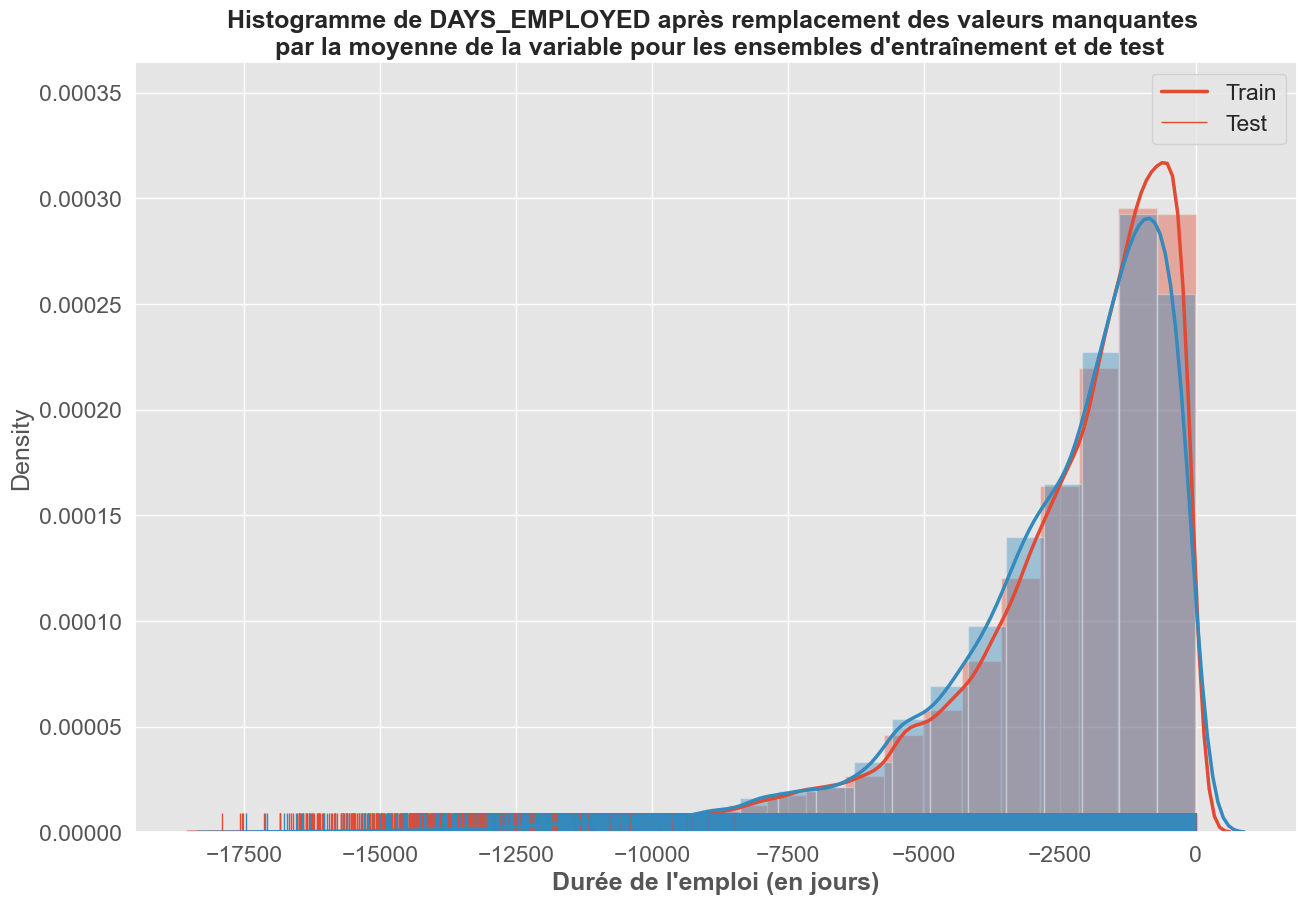

In [255]:
# Créer une figure 
plt.figure(figsize=(15, 10))

# Tracer l'histogramme et la distribution des valeurs de 'DAYS_EMPLOYED' dans le DataFrame 'app_train_final'
# Le paramètre hist=True indique que nous voulons afficher l'histogramme
# Le paramètre rug=True ajoute une petite barre à chaque point de données, aidant à visualiser leur distribution
# Le paramètre bins=25 spécifie le nombre de compartiments dans l'histogramme
sns.distplot(app_train_final['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)

# Tracer l'histogramme et la distribution des valeurs de 'DAYS_EMPLOYED' dans le DataFrame 'app_test_final'
# Cette ligne ajoute un deuxième histogramme pour le jeu de données de test dans la même figure
sns.distplot(app_test_final['DAYS_EMPLOYED'], hist=True, rug=True, bins=25)

# Définir le titre du graphique avec une police en gras et une taille de 18
plt.title('Histogramme de DAYS_EMPLOYED après remplacement des valeurs manquantes \n par la moyenne de la variable pour les ensembles d\'entraînement et de test', weight='bold', size=18)

# Définir le label de l'axe des abscisses avec une police en gras
plt.xlabel('Durée de l\'emploi (en jours)', weight="bold")

# Définir les étiquettes pour les légendes
labels = ["Train", "Test"]

# Ajouter une légende pour différencier les histogrammes de l'ensemble d'entraînement et de l'ensemble de test
plt.legend(labels)

# Afficher le graphique
plt.show()


### 10 - Standarisation (Train + Test)

In [256]:
# Sélectionner toutes les colonnes numériques du DataFrame 'app_train_final'
df_num_train = app_train_final.select_dtypes(['number']).reset_index(drop=True)

# Sélectionner toutes les colonnes catégorielles du DataFrame 'app_train_final'
df_categ_train = app_train_final.select_dtypes('object').reset_index(drop=True)

# Sélectionner toutes les colonnes numériques du DataFrame 'app_test_final'
df_num_test = app_test_final.select_dtypes(['number']).reset_index(drop=True)

# Sélectionner toutes les colonnes catégorielles du DataFrame 'app_test_final'
df_categ_test = app_test_final.select_dtypes('object').reset_index(drop=True)


In [257]:
from sklearn.preprocessing import StandardScaler

In [258]:
# Créer un objet StandardScaler pour normaliser les données numériques
scaler = StandardScaler()

# Adapter (fit) le scaler aux données d'entraînement (df_num_train)
scaler.fit(df_num_train)

# Transformer (scale) les données d'entraînement (df_num_train) en utilisant le scaler
# et créer un nouveau DataFrame 'df_num_train_train' avec les données normalisées.
df_num_train_train = pd.DataFrame(scaler.transform(df_num_train), index=df_num_train.index, columns=df_num_train.columns)

# Transformer (scale) les données de test (df_num_test) en utilisant le scaler
# et créer un nouveau DataFrame 'df_num_test_test' avec les données normalisées.
df_num_test_test = pd.DataFrame(scaler.transform(df_num_test), index=df_num_test.index, columns=df_num_test.columns)


In [259]:
# Concaténer les DataFrames 'df_categ_train' et 'df_num_train_train' le long de l'axe des colonnes (axis=1)
# pour obtenir un seul DataFrame 'df_app_train' contenant toutes les données d'entraînement.
df_app_train = pd.concat([df_categ_train, df_num_train_train], axis=1)

# Concaténer les DataFrames 'df_categ_test' et 'df_num_test_test' le long de l'axe des colonnes (axis=1)
# pour obtenir un seul DataFrame 'df_app_test' contenant toutes les données de test.
df_app_test = pd.concat([df_categ_test, df_num_test_test], axis=1)


In [260]:
df_app_train

SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0          100002    1.0         Cash_loans           M            N   
1          100003    0.0         Cash_loans           F            N   
2          100016    0.0         Cash_loans           F            N   
3          100017    0.0         Cash_loans           M            Y   
4          100018    0.0         Cash_loans           F            N   
...           ...    ...                ...         ...          ...   
154802     456251    0.0         Cash_loans           M            N   
154803     456252    0.0         Cash_loans           F            N   
154804     456253    0.0         Cash_loans           F            N   
154805     456254    1.0         Cash_loans           F            N   
154806     456255    0.0         Cash_loans           F            N   

       FLAG_OWN_REALTY NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0                    Y   Unaccompanied               Working   
1                    N          Family         State_servant   
2                    Y   Unaccompanied               Working   
3                    N   Unaccompanied               Working   
4                    Y   Unaccompanied               Working   
...                ...             ...                   ...   
154802               N   Unaccompanied               Working   
154803               Y   Unaccompanied             Pensioner   
154804               Y   Unaccompanied               Working   
154805               Y   Unaccompanied  Commercial_associate   
154806               N   Unaccompanied  Commercial_associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary_/_secondary_special  Single_/_not_married   
1                    Higher_education               Married   
2       Secondary_/_secondary_special               Married   
3       Secondary_/_secondary_special               Married   
4       Secondary_/_secondary_special               Married   
...                               ...                   ...   
154802  Secondary_/_secondary_special             Separated   
154803  Secondary_/_secondary_special                 Widow   
154804               Higher_education             Separated   
154805  Secondary_/_secondary_special               Married   
154806               Higher_education               Married   

        NAME_HOUSING_TYPE WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  \
0       House_/_apartment                  WEDNESDAY  Business_Entity_Type_3   
1       House_/_apartment                     MONDAY                  School   
2       House_/_apartment                     FRIDAY  Business_Entity_Type_2   
3       House_/_apartment                   THURSDAY           Self-employed   
4       House_/_apartment                     MONDAY       Transport:_type_2   
...                   ...                        ...                     ...   
154802       With_parents                   THURSDAY                Services   
154803  House_/_apartment                     MONDAY  Business_Entity_Type_3   
154804  House_/_apartment                   THURSDAY                  School   
154805  House_/_apartment                  WEDNESDAY  Business_Entity_Type_1   
154806  House_/_apartment                   THURSDAY  Business_Entity_Type_3   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
0       block_of_flats       Stone,_brick                  No   
1       block_of_flats              Block                  No   
2       block_of_flats              Panel                  No   
3       block_of_flats              Panel                  No   
4       block_of_flats              Panel                  No   
...                ...                ...                 ...   
154802  block_of_flats       Stone,_brick                  No   
154803  block_of_flats       Stone,_brick                  No   
154804  block_of_flats              Panel                  No   
15480

In [261]:
df_app_train.shape

(154807, 112)

In [262]:
df_app_test.shape

(25345, 111)

### 11 - Encoding (Train + Test)

#### 11.1 Avec Standardisation des colonnes numériques 

Pour les variables catégorielles avec de nombreuses classes, one hot encoding est l'approche la plus sûre car elle n'impose pas de valeurs arbitraires aux catégories. Le seul inconvénient du one hot encoding est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories.

Mettons en œuvre la politique décrite ci-dessus : pour toute variable catégorielle (dtype == object) avec 2 catégories uniques, nous utiliserons l'encodage par label, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons l'encodage one-hot.

In [264]:
# Initialisation de l'objet LabelEncoder qui permettra d'encoder les variables binaires (2 catégories).
le = LabelEncoder()

# Compteur pour enregistrer le nombre de colonnes encodées par LabelEncoder.
le_count = 0

# Compteur pour enregistrer le nombre de colonnes encodées par One-Hot Encoding.
oh_count = 0

# Parcours de toutes les colonnes du DataFrame 'df_app_train'.
for col in df_app_train:
    #' Les colonnes 'TARGET' et SK_ID_CURR' sont ignorées car elles ne sont pas catégorielles.
    if col == 'TARGET' or col == 'SK_ID_CURR':
        pass
    else:
        # Vérification si la colonne est de type 'object', c'est-à-dire catégorielle.
        if df_app_train[col].dtype == 'object':
            # Si la colonne a au plus 2 catégories uniques, elle est encodée avec LabelEncoder.
            if len(list(df_app_train[col].unique())) <= 2:
                
                # Adapter le LabelEncoder aux catégories uniques de la colonne 'col'.
                le.fit(df_app_train[col])
                
                # Encoder les valeurs de la colonne 'col' dans les DataFrames 'df_app_train' et 'df_app_test'.
                df_app_train[col] = le.transform(df_app_train[col])
                df_app_test[col] = le.transform(df_app_test[col])

                # Incrémenter le compteur de colonnes encodées par LabelEncoder.
                le_count += 1
            else:
                # Si la colonne a plus de 2 catégories uniques, elle est encodée par One-Hot Encoding.
                df_app_train = pd.get_dummies(df_app_train, prefix=[col], columns=[col])
                df_app_test = pd.get_dummies(df_app_test, prefix=[col], columns=[col])

                # Incrémenter le compteur de colonnes encodées par One-Hot Encoding.
                oh_count += 1

# Afficher le nombre total de colonnes encodées par LabelEncoder.
print('%d colonnes ont été encodées par LabelEncoder.' % le_count)

# Afficher la taille des données d'entraînement après l'encodage.
print('Taille des données d\'entraînement : ', df_app_train.shape)

# Afficher la taille des données de test après l'encodage.
print('Taille des données de test : ', df_app_test.shape)

# Afficher le nombre total de colonnes encodées par One-Hot Encoding.
print('%d colonnes ont été encodées par One-Hot Encoding.' % oh_count)


5 colonnes ont été encodées par LabelEncoder.
Taille des données d'entraînement :  (154807, 218)
Taille des données de test :  (25345, 210)
10 colonnes ont été encodées par One-Hot Encoding.


Il doit y avoir les mêmes caractéristiques (colonnes) dans les données d'entrainement et de test. L'encodage a créé plus de colonnes dans les données d'apprentissage car certaines variables catégorielles avaient plus de catégories non représentées que dans les données de test. Pour supprimer les colonnes dans les données d'apprentissage qui ne sont pas dans les données de test, nous devons aligner les cadres de données. Tout d'abord, nous extrayons la colonne cible des données de formation (car elle ne figure pas dans les données de test mais nous devons conserver cette information). Lorsque nous effectuons l'alignement, nous devons nous assurer de définir axis = 1 pour aligner les cadres de données sur les colonnes et non sur les lignes.

In [266]:
# Extraire la colonne 'TARGET' du DataFrame 'df_app_train' pour la stocker dans la variable 'train_labels'.
train_labels = df_app_train['TARGET']

# Aligner les colonnes du DataFrame 'df_app_train' avec celles du DataFrame 'df_app_test'.
# Cela garantit que les deux DataFrames ont les mêmes colonnes après l'encodage.
# 'join = 'inner'' signifie que seules les colonnes communes seront conservées.
df_app_train, df_app_test = df_app_train.align(df_app_test, join='inner', axis=1)

# Remettre la colonne 'TARGET' dans le DataFrame 'df_app_train'.
df_app_train['TARGET'] = train_labels

# Afficher la taille des données d'entraînement après l'alignement.
print('Taille des données d\'entraînement : ', df_app_train.shape)

# Afficher la taille des données de test après l'alignement.
print('Taille des données de test : ', df_app_test.shape)


Taille des données d'entraînement :  (154807, 211)
Taille des données de test :  (25345, 210)


In [267]:
df_app_train

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0          100002                   0            1             0   
1          100003                   0            0             0   
2          100016                   0            0             0   
3          100017                   0            1             1   
4          100018                   0            0             0   
...           ...                 ...          ...           ...   
154802     456251                   0            1             0   
154803     456252                   0            0             0   
154804     456253                   0            0             0   
154805     456254                   0            0             0   
154806     456255                   0            0             0   

        FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0                     1                    0     -0.573222          0.069058   
1                     0                    0     -0.573222          0.282931   
2                     1                    0     -0.573222         -0.358688   
3                     0                    0      0.890172          0.140349   
4                     1                    0     -0.573222          0.026283   
...                 ...                  ...           ...               ...   
154802                0                    0     -0.573222         -0.073524   
154803                1                    0     -0.573222         -0.344430   
154804                1                    0     -0.573222         -0.087782   
154805                1                    0     -0.573222         -0.030750   
154806                0                    0     -0.573222         -0.073524   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0        -0.513860    -0.222911        -0.544493                   -0.226831   
1         1.597394     0.500488         1.467988                   -1.206771   
2        -1.289258    -1.460739        -1.277362                    0.577670   
3         0.704634     0.057687         0.351236                   -0.367401   
4         0.359971     0.308390         0.304704                   -0.791613   
...            ...          ...              ...                         ...   
154802   -0.875448    -0.034957        -0.870213                    0.656785   
154803   -0.840098    -1.058193        -0.870213                    0.181777   
154804    0.131407     0.124285         0.060415                   -1.112951   
154805   -0.600725    -0.518604        -0.625923                   -1.092980   
154806    0.125065     1.383128         0.293071                    1.533914   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0        -1.521797       0.784979           0.435145         0.592401   
1         0.151362       0.546259           1.116256         1.801065   
2        -0.610539      -0.116181           1.358324        -0.139141   
3        -0.462328      -0.250921           1.266477        -1.251984   
4        -0.348478       0.973010           1.274223         0.634695   
...            ...            ...                ...              ...   
154802   -1.552493       0.958713          -0.894985         0.683596   
154803    1.069950      -0.706050           0.230425        -0.709440   
154804   -0.260742      -2.370813          -0.419425        -1.409923   
154805   -0.949111      -1.012575           0.735586         1.378132   
154806    0.172208       0.514198           0.025704         1.722426   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0         0.002542        0.458151         -0.46321          0.047807   
1         0.002542        0.458151         -0.46321          0.047807   
2         0.002542        0.458151          2.15885          0.047807   
3         0.002542        0.458151         -0.46321          0.047807   
4         0.002542        

#### 11.2 Sans Standardisation des colonnes numériques 

In [270]:
# Initialisation de l'objet LabelEncoder qui permettra d'encoder les variables binaires (2 catégories).
le = LabelEncoder()

# Compteur pour enregistrer le nombre de colonnes encodées par LabelEncoder.
le_count = 0

# Compteur pour enregistrer le nombre de colonnes encodées par One-Hot Encoding.
oh_count = 0

# Parcours de toutes les colonnes du DataFrame 'df_app_train'.
for col in app_train_final:
    #' Les colonnes 'TARGET' et SK_ID_CURR' sont ignorées car elles ne sont pas catégorielles.
    if col == 'TARGET' or col == 'SK_ID_CURR':
        pass
    else:
        # Vérification si la colonne est de type 'object', c'est-à-dire catégorielle.
        if app_train_final[col].dtype == 'object':
            # Si la colonne a au plus 2 catégories uniques, elle est encodée avec LabelEncoder.
            if len(list(app_train_final[col].unique())) <= 2:
                
                # Adapter le LabelEncoder aux catégories uniques de la colonne 'col'.
                le.fit(app_train_final[col])
                
                # Encoder les valeurs de la colonne 'col' dans les DataFrames 'df_app_train' et 'df_app_test'.
                app_train_final[col] = le.transform(app_train_final[col])
                app_test_final[col] = le.transform(app_test_final[col])

                # Incrémenter le compteur de colonnes encodées par LabelEncoder.
                le_count += 1
            else:
                # Si la colonne a plus de 2 catégories uniques, elle est encodée par One-Hot Encoding.
                app_train_final = pd.get_dummies(app_train_final, prefix=[col], columns=[col])
                app_test_final = pd.get_dummies(app_test_final, prefix=[col], columns=[col])

                # Incrémenter le compteur de colonnes encodées par One-Hot Encoding.
                oh_count += 1

# Afficher le nombre total de colonnes encodées par LabelEncoder.
print('%d colonnes ont été encodées par LabelEncoder.' % le_count)

# Afficher la taille des données d'entraînement après l'encodage.
print('Taille des données d\'entraînement : ', app_train_final.shape)

# Afficher la taille des données de test après l'encodage.
print('Taille des données de test : ', app_test_final.shape)

# Afficher le nombre total de colonnes encodées par One-Hot Encoding.
print('%d colonnes ont été encodées par One-Hot Encoding.' % oh_count)


5 colonnes ont été encodées par LabelEncoder.
Taille des données d'entraînement :  (154807, 218)
Taille des données de test :  (25345, 210)
10 colonnes ont été encodées par One-Hot Encoding.


In [271]:
# Extraire la colonne 'TARGET' du DataFrame 'df_app_train' pour la stocker dans la variable 'train_labels'.
train_labels = app_train_final['TARGET']

# Aligner les colonnes du DataFrame 'df_app_train' avec celles du DataFrame 'df_app_test'.
# Cela garantit que les deux DataFrames ont les mêmes colonnes après l'encodage.
# 'join = 'inner'' signifie que seules les colonnes communes seront conservées.
app_train_final, app_test_final = app_train_final.align(app_test_final, join='inner', axis=1)

# Remettre la colonne 'TARGET' dans le DataFrame 'df_app_train'.
app_train_final['TARGET'] = train_labels

# Afficher la taille des données d'entraînement après l'alignement.
print('Taille des données d\'entraînement : ', app_train_final.shape)

# Afficher la taille des données de test après l'alignement.
print('Taille des données de test : ', app_test_final.shape)


Taille des données d'entraînement :  (154807, 211)
Taille des données de test :  (25345, 210)


In [272]:
app_train_final

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100002             0          202500.0    406597.5      24700.5   
1          100003             0          270000.0   1293502.5      35698.5   
2          100016             0           67500.0     80865.0       5881.5   
3          100017             1          225000.0    918468.0      28966.5   
4          100018             0          189000.0    773680.5      32778.0   
...           ...           ...               ...         ...          ...   
154802     456251             0          157500.0    254700.0      27558.0   
154803     456252             0           72000.0    269550.0      12001.5   
154804     456253             0          153000.0    677664.0      29979.0   
154805     456254             0          171000.0    370107.0      20205.0   
154806     456255             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801        9461   
1             1129500.0                    0.003541       16765   
2               67500.0                    0.031329       13439   
3              697500.0                    0.016612       14086   
4              679500.0                    0.010006       14583   
...                 ...                         ...         ...   
154802         225000.0                    0.032561        9327   
154803         225000.0                    0.025164       20775   
154804         585000.0                    0.005002       14966   
154805         319500.0                    0.005313       11961   
154806         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...                   ...   
154802           0              1.0                     1   
154803           0     

In [273]:
# Enregistrer le DataFrame 'app_train_final' dans un fichier CSV nommé "train_imputed_without_standardisation.csv".
# L'argument 'index=False' indique que nous ne souhaitons pas sauvegarder l'index des lignes dans le fichier CSV.
app_train_final.to_csv("train_imputed_without_standardisation.csv", index=False)

# Enregistrer le DataFrame 'app_test_final' dans un fichier CSV nommé "test_imputed_without_standardisation.csv".
# L'argument 'index=False' indique que nous ne souhaitons pas sauvegarder l'index des lignes dans le fichier CSV.
app_test_final.to_csv("test_imputed_without_standardisation.csv", index=False)


### 12 - Sauvegarde CSV

In [274]:
# Enregistrer le DataFrame 'df_app_train' et 'df_app_test' dans un fichier CSV 
# L'argument 'index=False' indique que nous ne souhaitons pas sauvegarder l'index des lignes dans le fichier CSV.
df_app_train.to_csv("df_train_imputed.csv", index=False)
df_app_test.to_csv("df_test_imputed.csv", index=False)

In [275]:
# Enregistrer le DataFrame 'app_train_reduced' et 'app_test_reduced' dans un fichier CSV 
# L'argument 'index=False' indique que nous ne souhaitons pas sauvegarder l'index des lignes dans le fichier CSV.
app_train_reduced.to_csv("real_data_clean_train.csv", index=False)
app_test_reduced.to_csv("real_data_clean_test.csv", index=False)

In [276]:
# dataset qui contient un taux de remplissage / réduction colonnes 
# et lignes sans la Standardisation et l'encodage
app_train_reduced

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002     1.0         Cash_loans           M            N   
1           100003     0.0         Cash_loans           F            N   
12          100016     0.0         Cash_loans           F            N   
13          100017     0.0         Cash_loans           M            Y   
14          100018     0.0         Cash_loans           F            N   
...            ...     ...                ...         ...          ...   
307506      456251     0.0         Cash_loans           M            N   
307507      456252     0.0         Cash_loans           F            N   
307508      456253     0.0         Cash_loans           F            N   
307509      456254     1.0         Cash_loans           F            N   
307510      456255     0.0         Cash_loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
12                   Y             0           67500.0     80865.0   
13                   N             1          225000.0    918468.0   
14                   Y             0          189000.0    773680.5   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State_servant   
12           5881.5          67500.0   Unaccompanied               Working   
13          28966.5         697500.0   Unaccompanied               Working   
14          32778.0         679500.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial_associate   
307510      49117.5         675000.0   Unaccompanied  Commercial_associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary_/_secondary_special  Single_/_not_married   
1                    Higher_education               Married   
12      Secondary_/_secondary_special               Married   
13      Secondary_/_secondary_special               Married   
14      Secondary_/_secondary_special               Married   
...                               ...                   ...   
307506  Secondary_/_secondary_special             Separated   
307507  Secondary_/_secondary_special                 Widow   
307508               Higher_education             Separated   
307509  Secondary_/_secondary_special               Married   
307510               Higher_education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House_/_apartment                    0.018801        9461   
1       House_/_apartment                    0.003541       16765   
12      House_/_apartment                    0.031329       13439   
13      House_/_apartment                    0.016612       14086   
14      House_/_apartment                    0.010006       14583   
...                   ...                         ...         ...   
307506       With_parents                    0.032561        9327   
307507  House_/_apartment       

In [277]:
# dataset final avec l'encodage des colonnes "object" 
# et sans la Standardisation des colonnes "numérique"
app_train_final

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0          100002             0          202500.0    406597.5      24700.5   
1          100003             0          270000.0   1293502.5      35698.5   
2          100016             0           67500.0     80865.0       5881.5   
3          100017             1          225000.0    918468.0      28966.5   
4          100018             0          189000.0    773680.5      32778.0   
...           ...           ...               ...         ...          ...   
154802     456251             0          157500.0    254700.0      27558.0   
154803     456252             0           72000.0    269550.0      12001.5   
154804     456253             0          153000.0    677664.0      29979.0   
154805     456254             0          171000.0    370107.0      20205.0   
154806     456255             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801        9461   
1             1129500.0                    0.003541       16765   
2               67500.0                    0.031329       13439   
3              697500.0                    0.016612       14086   
4              679500.0                    0.010006       14583   
...                 ...                         ...         ...   
154802         225000.0                    0.032561        9327   
154803         225000.0                    0.025164       20775   
154804         585000.0                    0.005002       14966   
154805         319500.0                    0.005313       11961   
154806         675000.0                    0.046220       16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0              -637.0            -3648.0            -2120           1   
1             -1188.0            -1186.0             -291           1   
2             -2717.0             -311.0            -3227           1   
3             -3028.0             -643.0            -4911           1   
4              -203.0             -615.0            -2056           1   
...               ...                ...              ...         ...   
154802         -236.0            -8456.0            -1982           1   
154803        -4078.5            -4388.0            -4090           1   
154804        -7921.0            -6737.0            -5150           1   
154805        -4786.0            -2562.0             -931           1   
154806        -1262.0            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
154802               1                0                 1           0   
154803               0                0                 1           1   
154804               1                0                 1           0   
154805               1                0                 1           0   
154806               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0              1.0                     2   
1                0              2.0                     1   
2                0              2.0                     2   
3                0              3.0                     2   
4                0              2.0                     2   
...            ...              ...                   ...   
154802           0              1.0                     1   
154803           0     

In [278]:
# dataset final avec l'encodage des colonnes "object" 
# et la Standardisation des colonnes "numérique"
df_app_train

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0          100002                   0            1             0   
1          100003                   0            0             0   
2          100016                   0            0             0   
3          100017                   0            1             1   
4          100018                   0            0             0   
...           ...                 ...          ...           ...   
154802     456251                   0            1             0   
154803     456252                   0            0             0   
154804     456253                   0            0             0   
154805     456254                   0            0             0   
154806     456255                   0            0             0   

        FLAG_OWN_REALTY  EMERGENCYSTATE_MODE  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0                     1                    0     -0.573222          0.069058   
1                     0                    0     -0.573222          0.282931   
2                     1                    0     -0.573222         -0.358688   
3                     0                    0      0.890172          0.140349   
4                     1                    0     -0.573222          0.026283   
...                 ...                  ...           ...               ...   
154802                0                    0     -0.573222         -0.073524   
154803                1                    0     -0.573222         -0.344430   
154804                1                    0     -0.573222         -0.087782   
154805                1                    0     -0.573222         -0.030750   
154806                0                    0     -0.573222         -0.073524   

        AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0        -0.513860    -0.222911        -0.544493                   -0.226831   
1         1.597394     0.500488         1.467988                   -1.206771   
2        -1.289258    -1.460739        -1.277362                    0.577670   
3         0.704634     0.057687         0.351236                   -0.367401   
4         0.359971     0.308390         0.304704                   -0.791613   
...            ...          ...              ...                         ...   
154802   -0.875448    -0.034957        -0.870213                    0.656785   
154803   -0.840098    -1.058193        -0.870213                    0.181777   
154804    0.131407     0.124285         0.060415                   -1.112951   
154805   -0.600725    -0.518604        -0.625923                   -1.092980   
154806    0.125065     1.383128         0.293071                    1.533914   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0        -1.521797       0.784979           0.435145         0.592401   
1         0.151362       0.546259           1.116256         1.801065   
2        -0.610539      -0.116181           1.358324        -0.139141   
3        -0.462328      -0.250921           1.266477        -1.251984   
4        -0.348478       0.973010           1.274223         0.634695   
...            ...            ...                ...              ...   
154802   -1.552493       0.958713          -0.894985         0.683596   
154803    1.069950      -0.706050           0.230425        -0.709440   
154804   -0.260742      -2.370813          -0.419425        -1.409923   
154805   -0.949111      -1.012575           0.735586         1.378132   
154806    0.172208       0.514198           0.025704         1.722426   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0         0.002542        0.458151         -0.46321          0.047807   
1         0.002542        0.458151         -0.46321          0.047807   
2         0.002542        0.458151          2.15885          0.047807   
3         0.002542        0.458151         -0.46321          0.047807   
4         0.002542        